In [1]:
import os
os.environ['DRJIT_LIBLLVM_PATH'] = 'C:\\Program Files\\LLVM\\bin\\LLVM-C.dll'
#print(os.environ['DRJIT_LIBLLVM_PATH'])
import sionna
import mitsuba as mi
import drjit as dr
import tensorflow as tf
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import time
from IPython.display import display, HTML
# Import Sionna RT components
from sionna.rt import load_scene, Transmitter, Receiver, PlanarArray, Camera, Antenna, AntennaArray
# For link-level simulations
from sionna.channel import cir_to_ofdm_channel, subcarrier_frequencies, OFDMChannel, ApplyOFDMChannel, CIRDataset
from sionna.nr import PUSCHConfig, PUSCHTransmitter, PUSCHReceiver
from sionna.utils import compute_ber, ebnodb2no, PlotBER
from sionna.ofdm import KBestDetector, LinearDetector
from sionna.mimo import StreamManagement
from Movement import *
from Visualization import *
from helper import *
from Channel import *
from Codebook import *
import math

In [2]:
#tf.random.set_seed(10)
itu_metal_scattering_coefficient = 0.707 # To define the  scattering coefficient based on Sionna R = sqrt(1-S**2)
itu_concrete_scattering_coefficient = 0.707 # To define the  scattering coefficient based on Sionna R = sqrt(1-S**2)

c = 299792458.0 # m/s
# tx and rx in cartesian coordinate
tx_position = [0,0.25,.94]
rx_position = [0,-0.25,.94]

N_r = 16
L_r = 16

N_t = 16
L_t = 16


initial_position_cartesian = cylindrical_to_cartesian([3, math.radians(-25), 0])
initial_position_cartesian 

array([ 2.71892336, -1.26785479,  0.        ])

In [3]:
scene = load_scene('C:\\Users\\dehghani\\Documents\\test_scene\\scene.xml')

In [4]:
#scene.tx_array = AntennaArray(antenna=Antenna("iso", "V"),
                     #positions=tf.Variable([[0,0,0], [0, 1, 1], [0, 1, 3]]))
#scene.rx_array = AntennaArray(antenna=Antenna("iso", "V"),
                     #positions=tf.Variable([[0,0,0], [0, 1, 1]]))



# Create transmitter
#tx = Transmitter(name = "tx",
                 #position = tx_position)

#tx.look_at([1.5,1,0.94]) 

# Add transmitter instance to scene
#scene.add(tx)

# Create a receiver
#rx = Receiver(name = "rx",
              #position = rx_position)

#rx.look_at([1.5,1,0.94]) 

# Add receiver instance to scene
#scene.add(rx)

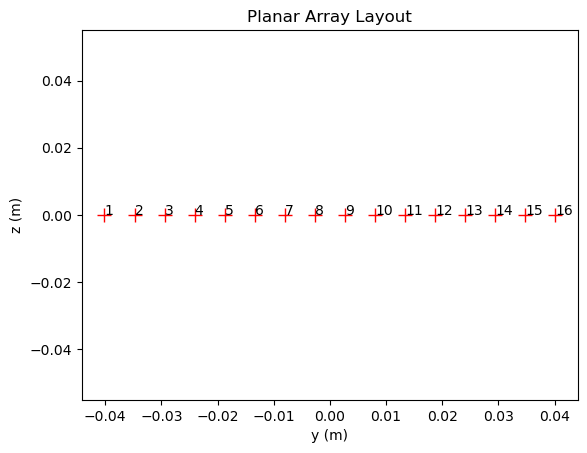

In [5]:
scene.frequency = 28e9

scene.synthetic_array = True # If set to False, ray tracing will be done per antenna element (slower for large arrays)

scene.tx_array = PlanarArray(num_rows=1,
                          num_cols = N_t,
                          vertical_spacing = 0.5,
                          horizontal_spacing= 0.5,
                          pattern="iso",
                          polarization="H")


scene.rx_array = PlanarArray(num_rows=1,
                          num_cols = N_r,
                          vertical_spacing= 0.5,
                          horizontal_spacing= 0.5,
                          pattern="iso",
                          polarization="H")

scene.rx_array.show()

# Create transmitter
tx = Transmitter(name = "tx",
                 position = tx_position)


# Add transmitter instance to scene
scene.add(tx)

# Create a receiver
rx = Receiver(name = "rx",
              position = rx_position)

# Add receiver instance to scene
scene.add(rx)

In [6]:
for rm in scene.radio_materials.values():
    if rm.name=='itu_metal' :
        print(f'Before: rm.name: {rm.name} and   rm.scattering_coefficient = { rm.scattering_coefficient}')
        rm.scattering_coefficient= itu_metal_scattering_coefficient
        print(f'After: rm.name: {rm.name} and   rm.scattering_coefficient = { rm.scattering_coefficient}')
        
    if rm.name=='itu_concrete' :
        rm.scattering_coefficient = itu_concrete_scattering_coefficient

   #     rm.scattering_pattern = BackscatteringPattern(alpha_r=20, alpha_i=30, lambda_=0.5)

Before: rm.name: itu_metal and   rm.scattering_coefficient = 0.0
After: rm.name: itu_metal and   rm.scattering_coefficient = 0.7070000171661377


In [7]:
params = mi.traverse(scene._scene)
positions = dr.unravel(mi.Point3f, params['mesh-Robot.vertex_positions'])

positions.x += initial_position_cartesian[0]
positions.y += initial_position_cartesian[1]
positions.z += initial_position_cartesian[2]

params['mesh-Robot.vertex_positions'] = dr.ravel(positions)
params.update()

[(PLYMesh[
    name = "Robot.ply",
    bbox = BoundingBox3f[
      min = [2.16892, -1.51785, 0.84],
      max = [3.26892, -1.01785, 1.04]
    ],
    vertex_count = 14,
    vertices = [280 B of vertex data],
    face_count = 12,
    faces = [144 B of face data],
    face_normals = 1
  ],
  {'vertex_positions'}),
 (Scene[
    children = [
      PathIntegrator[
        max_depth = 12,
        rr_depth = 5
      ],
      TwoSided[
        brdf[0] = SmoothDiffuse[
          reflectance = SRGBReflectanceSpectrum[
            value = [[0.8, 0.043496, 0.011812]]
          ]
        ],
        brdf[1] = SmoothDiffuse[
          reflectance = SRGBReflectanceSpectrum[
            value = [[0.8, 0.043496, 0.011812]]
          ]
        ]
      ],
      ConstantBackgroundEmitter[
        radiance = SRGBReflectanceSpectrum[
          value = [[1, 1, 1]]
        ],
        bsphere = BoundingSphere3f[
          center = [0, 0, 0.94],
          radius = 0.612427
        ]
      ],
      PLYMesh[
      

In [8]:
scene._solver_paths = Solver(scene)
paths = scene.compute_paths(method='fibonacci', max_depth=1, num_samples=1e7, reflection=False, scattering=True,
                                    diffraction=False, los=False)
paths.normalize_delays = False
a, tau = paths.cir(los=False, reflection=False, diffraction=False, scattering=True)

In [9]:
scene.preview(paths, show_devices=True, show_paths=True) 

Renderer(camera=PerspectiveCamera(aspect=1.31, children=(DirectionalLight(intensity=0.25, position=(0.0, 0.0, …

In [10]:
# a = [batch_size, num_rx, num_rx_ant, num_tx, num_tx_ant, max_num_paths, num_time_steps], tf.complex
a

<tf.Tensor: shape=(1, 1, 16, 1, 16, 14, 1), dtype=complex64, numpy=
array([[[[[[[-7.86784824e-07+1.92677953e-06j],
            [ 1.73998330e-06-1.04314074e-06j],
            [ 1.15534317e-06-1.99929809e-06j],
            ...,
            [ 4.54287738e-06-1.40522695e-06j],
            [-1.04991500e-07-2.55551868e-06j],
            [ 2.39471342e-06+4.04212278e-06j]],

           [[ 1.61734283e-06+1.30985177e-06j],
            [-4.57844806e-07-1.97637587e-06j],
            [-1.71142187e-06-1.55017574e-06j],
            ...,
            [-2.46078139e-06-4.06902382e-06j],
            [-2.54786914e-06-2.23747293e-07j],
            [ 3.23195263e-06-3.40996985e-06j]],

           [[ 1.72122679e-06-1.16999468e-06j],
            [-2.02142974e-06-1.71774616e-07j],
            [-1.87559442e-06+1.34690561e-06j],
            ...,
            [-3.35426307e-06+3.37065558e-06j],
            [-5.48787625e-07+2.49810569e-06j],
            [-4.16459807e-06-2.17474849e-06j]],

           ...,

           [

In [11]:
# Azimuth angle of arrival and departure
azimuth_departure_list = []
azimuth_arrival_list = []

for path_idx in range(a.shape[-2]):
    azimuth_departure_list.append(np.rad2deg(paths.phi_t[0,0,0,path_idx]))
    azimuth_arrival_list.append(np.rad2deg(paths.phi_r[0,0,0,path_idx]))

# Transmitting Codebook


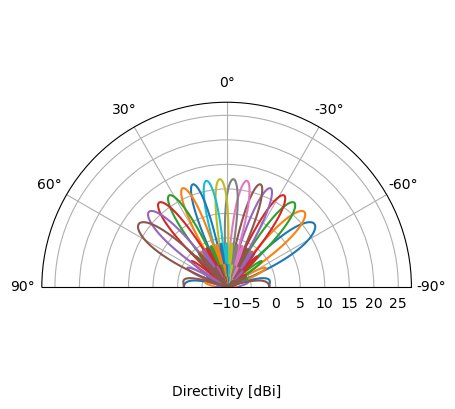

array([-52.83802756, -45.79295722, -38.74788688, -31.70281654,
       -24.6577462 , -17.61267585, -10.56760551,  -3.52253517,
         3.52253517,  10.56760551,  17.61267585,  24.6577462 ,
        31.70281654,  38.74788688,  45.79295722,  52.83802756])

In [12]:
transmitting_codebook = Codebook(L_max = L_t , N1 = N_t, az_min = -60, az_max = 60)
transmitting_codebook_vectors, beam_degs = transmitting_codebook.beamforming_vectors()
transmitting_codebook.plot_beamforming_polar(transmitting_codebook_vectors)
beam_degs

In [13]:
# Reverse the order of arrays
reversed_vectors = reversed(transmitting_codebook_vectors)
transmitting_codebook_vectors = list(reversed_vectors)
transmitting_codebook_vectors

[array([ 2.50000000e-01+0.j        , -2.07867403e-01+0.13889256j,
         9.56708581e-02-0.23096988j,  4.87725805e-02+0.24519632j,
        -1.76776695e-01-0.1767767j ,  2.45196320e-01+0.04877258j,
        -2.30969883e-01+0.09567086j,  1.38892558e-01-0.2078674j ,
        -2.45084105e-16+0.25j      , -1.38892558e-01-0.2078674j ,
         2.30969883e-01+0.09567086j, -2.45196320e-01+0.04877258j,
         1.76776695e-01-0.1767767j , -4.87725805e-02+0.24519632j,
        -9.56708581e-02-0.23096988j,  2.07867403e-01+0.13889256j]),
 array([ 0.25      +0.j        , -0.15859832+0.19325261j,
        -0.04877258-0.24519632j,  0.22048032+0.11784918j,
        -0.23096988+0.09567086j,  0.07257117-0.23923508j,
         0.13889256+0.2078674j , -0.24879618-0.02450429j,
         0.1767767 -0.1767767j ,  0.02450429+0.24879618j,
        -0.2078674 -0.13889256j,  0.23923508-0.07257117j,
        -0.09567086+0.23096988j, -0.11784918-0.22048032j,
         0.24519632+0.04877258j, -0.19325261+0.15859832j]),
 arr

# Receiving Codebook

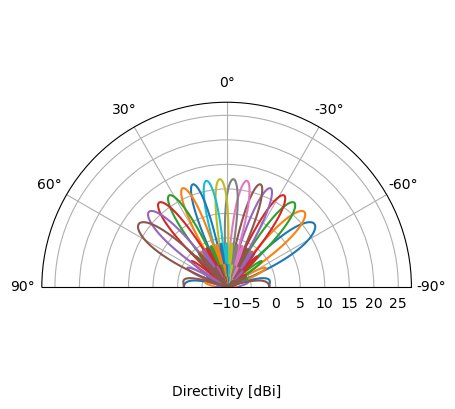

array([-52.83802756, -45.79295722, -38.74788688, -31.70281654,
       -24.6577462 , -17.61267585, -10.56760551,  -3.52253517,
         3.52253517,  10.56760551,  17.61267585,  24.6577462 ,
        31.70281654,  38.74788688,  45.79295722,  52.83802756])

In [14]:
receiving_codebook = Codebook(L_max = L_r , N1 = N_r, az_min = -60, az_max = 60)
receiving_codebook_vectors, beam_degs = receiving_codebook.beamforming_vectors()
receiving_codebook.plot_beamforming_polar(receiving_codebook_vectors)
beam_degs

In [15]:
receiving_codebook_vectors

[array([ 2.50000000e-01+0.j        , -2.07867403e-01-0.13889256j,
         9.56708581e-02+0.23096988j,  4.87725805e-02-0.24519632j,
        -1.76776695e-01+0.1767767j ,  2.45196320e-01-0.04877258j,
        -2.30969883e-01-0.09567086j,  1.38892558e-01+0.2078674j ,
        -2.45084105e-16-0.25j      , -1.38892558e-01+0.2078674j ,
         2.30969883e-01-0.09567086j, -2.45196320e-01-0.04877258j,
         1.76776695e-01+0.1767767j , -4.87725805e-02-0.24519632j,
        -9.56708581e-02+0.23096988j,  2.07867403e-01-0.13889256j]),
 array([ 0.25      +0.j        , -0.15859832-0.19325261j,
        -0.04877258+0.24519632j,  0.22048032-0.11784918j,
        -0.23096988-0.09567086j,  0.07257117+0.23923508j,
         0.13889256-0.2078674j , -0.24879618+0.02450429j,
         0.1767767 +0.1767767j ,  0.02450429-0.24879618j,
        -0.2078674 +0.13889256j,  0.23923508+0.07257117j,
        -0.09567086-0.23096988j, -0.11784918+0.22048032j,
         0.24519632-0.04877258j, -0.19325261-0.15859832j]),
 arr

In [16]:
# Removing the redundant dimesions from a --> (batch size (rays), receiving antennas, transmitting antennas)
a_reshaped = tf.squeeze(a, [0,1,3,6])
a_reshaped = tf.transpose(a_reshaped, perm=[2, 0, 1]) 

In [17]:
# Generating a matrix out of transmitting_codebook_vectors --> # (batch size, N_t, L_t)
transmitting_codebook_matrix = np.stack(transmitting_codebook_vectors, axis = -1)  # (N_t, L_t)
# Add the dummy batch dimension
transmitting_codebook_matrix = np.expand_dims(transmitting_codebook_matrix, axis=0).astype(np.complex64)  # (batch size, N_t, L_t)
transmitting_codebook_matrix

array([[[ 2.50000000e-01+0.00000000e+00j,
          2.50000000e-01+0.00000000e+00j,
          2.50000000e-01+0.00000000e+00j,
          2.50000000e-01+0.00000000e+00j,
          2.50000000e-01+0.00000000e+00j,
          2.50000000e-01+0.00000000e+00j,
          2.50000000e-01+0.00000000e+00j,
          2.50000000e-01+0.00000000e+00j,
          2.50000000e-01+0.00000000e+00j,
          2.50000000e-01+0.00000000e+00j,
          2.50000000e-01+0.00000000e+00j,
          2.50000000e-01+0.00000000e+00j,
          2.50000000e-01+0.00000000e+00j,
          2.50000000e-01+0.00000000e+00j,
          2.50000000e-01+0.00000000e+00j,
          2.50000000e-01+0.00000000e+00j],
        [-2.07867399e-01+1.38892561e-01j,
         -1.58598319e-01+1.93252608e-01j,
         -9.56708565e-02+2.30969876e-01j,
         -2.45042853e-02+2.48796180e-01j,
          7.25711659e-02+2.39235088e-01j,
          1.38892561e-01+2.07867399e-01j,
          2.07867399e-01+1.38892561e-01j,
          2.45196313e-01+4.877258

In [18]:
# Beam forming at the Transmitter by applying the weights 
# (batch size, N_r, N_t) * (batch size, N_t, L_t) = (batch size, N_r, L_t))

beam_formed_transmitting_signal = tf.matmul(a_reshaped, transmitting_codebook_matrix) 
beam_formed_transmitting_signal # (batch size, N_r, L_t)

<tf.Tensor: shape=(14, 16, 16), dtype=complex64, numpy=
array([[[-3.05645699e-07+5.28975818e-07j,
         -1.09799680e-06+1.25935770e-07j,
         -7.56523320e-07-8.08286245e-07j, ...,
         -3.48824244e-07+1.31152433e-07j,
         -5.23050403e-09-3.37544037e-09j,
          2.51288839e-08+3.85426631e-07j],
        [ 1.76987783e-07+5.84730685e-07j,
         -6.58901570e-07+8.87303486e-07j,
         -1.10709243e-06-6.71320777e-10j, ...,
         -1.42821364e-07+3.44211116e-07j,
         -6.03887429e-09+1.50893698e-09j,
          2.98422549e-07+2.45212050e-07j],
        [ 5.47689865e-07+2.70684836e-07j,
          1.96900601e-07+1.08751385e-06j,
         -7.57504722e-07+8.07368224e-07j, ...,
          1.53505653e-07+3.39581788e-07j,
         -3.02811287e-09+5.43843726e-09j,
          3.82984183e-07-5.00812121e-08j],
        ...,
        [-3.85779742e-07-4.73717733e-07j,
          2.72594093e-07-1.07105075e-06j,
          1.02441663e-06-4.19793878e-07j, ...,
          1.40948941e-09-3

In [19]:
# Generating a matrix out of receiving_codebook_vectors --> # (batch size, N_r, L_r)
receiving_codebook_matrix = np.stack(receiving_codebook_vectors, axis = -1)  # (N_r, L_r)
# Add the dummy batch dimension
receiving_codebook_matrix = np.expand_dims(receiving_codebook_matrix, axis=0).astype(np.complex64)  # (batch size, N_r, L_r)

In [20]:
# Beam forming at the receiver by applying the weights 
# (batch size, N_r, L_r).T.conj() * (batch size (rays), N_r, L_t) = (batch size, L_r, N_t))

beam_formed_receiving_signal = tf.matmul(receiving_codebook_matrix, beam_formed_transmitting_signal, adjoint_a=True) 
beam_formed_receiving_signal # (batch size, L_r, L_t)

<tf.Tensor: shape=(14, 16, 16), dtype=complex64, numpy=
array([[[-1.59414810e-07+1.09783542e-07j,
         -3.31311810e-07-1.13325797e-07j,
         -1.06520844e-07-3.34193459e-07j, ...,
         -1.17653570e-07-9.92278615e-09j,
         -1.03735331e-09-1.67780234e-09j,
         -4.52396165e-08+1.13704338e-07j],
        [-1.89548956e-07-6.48355751e-08j,
         -1.10059602e-07-3.45292676e-07j,
          2.12144244e-07-2.94595679e-07j, ...,
         -6.42890825e-08-1.03924236e-07j,
          7.54285745e-10-1.89669702e-09j,
         -1.22416211e-07+3.24961604e-08j],
        [-2.19744614e-08-6.89398121e-08j,
          7.64911974e-08-1.06219964e-07j,
          1.31107342e-07-1.84013516e-09j, ...,
          1.63169069e-08-4.10101642e-08j,
          7.12273296e-10-1.89287669e-10j,
         -3.57652752e-08-2.85213311e-08j],
        ...,
        [-3.97200530e-08-3.35011308e-09j,
         -3.79363669e-08-6.13252453e-08j,
          2.67047966e-08-6.71197284e-08j, ...,
         -1.74340578e-08-1

In [21]:
# tau = [batch_size, num_rx, num_tx, max_num_paths]
tau = tf.squeeze(tau)
tau

<tf.Tensor: shape=(14,), dtype=float32, numpy=
array([2.0236691e-08, 2.0565569e-08, 1.8958515e-08, 2.2474525e-08,
       2.2522597e-08, 1.7359929e-08, 2.0544633e-08, 1.8679295e-08,
       1.8387968e-08, 1.9689006e-08, 1.6447075e-08, 1.6888531e-08,
       1.7788917e-08, 1.7038840e-08], dtype=float32)>

In [22]:
# Reshape the tensor to a 2D array
reshaped_array = tf.reshape(beam_formed_receiving_signal, (tau.shape[0], L_r * L_t))
columns = [f'{i},{j}' for i in range(1, L_r + 1) for j in range(1, L_t + 1)]
df1 = pd.DataFrame(reshaped_array.numpy(), columns=columns)
df1 = df1.set_index(pd.Index(tau))
df1

1,1                         1,2  \
2.023669e-08 -1.594148e-07+1.097835e-07j -3.313118e-07-1.133258e-07j   
2.056557e-08  2.081310e-07+6.181492e-08j  1.155766e-07+3.171767e-07j   
1.895851e-08  1.820659e-09-3.215263e-08j  2.199962e-07-1.446311e-07j   
2.247453e-08 -1.261189e-07-1.488202e-07j  3.179898e-08-1.360277e-07j   
2.252260e-08  1.086286e-07+1.585475e-07j -4.376977e-08+1.269703e-07j   
1.735993e-08 -1.831718e-08+4.481478e-08j -1.823041e-09+4.651481e-10j   
2.054463e-08  1.778443e-07-1.224067e-07j  3.204606e-07+1.097090e-07j   
1.867929e-08  3.260580e-09+5.644791e-09j  8.566948e-08-1.977233e-07j   
1.838797e-08 -2.904686e-08-2.901538e-08j -2.326676e-08+1.574109e-07j   
1.968901e-08  6.133632e-08-1.199853e-07j  3.366308e-07-5.625111e-08j   
1.644707e-08 -5.517006e-07+1.781708e-07j -1.382725e-06-9.877374e-07j   
1.688853e-08 -8.500567e-09+9.177943e-08j  1.370227e-07-8.321307e-08j   
1.778892e-08  7.378043e-08-1.930264e-09j -2.831586e-08-3.616408e-08j   
1.703884e-08  1.337683e-07-1.206109e-07j -6.789475e-08-1.368909e-08j   

                                     1,3                         1,4  \
2.023669e-08 -1.065208e-07-3.341935e-07j  5.815449e-09-8.075411e-09j   
2.056557e-08 -1.561648e-07+2.366909e-07j  1.142106e-07-6.277958e-09j   
1.895851e-08  4.532268e-07+1.659977e-07j  1.628129e-07+5.515244e-07j   
2.247453e-08 -5.137927e-08+2.223884e-08j -3.558870e-07-2.057426e-07j   
2.252260e-08  5.837220e-08-1.845184e-08j  3.325129e-07+2.406592e-07j   
1.735993e-08  7.647012e-08+6.216062e-08j -1.578988e-08+3.553614e-07j   
2.054463e-08  8.738076e-08+2.743969e-07j  6.259103e-08-8.686958e-08j   
1.867929e-08  4.501661e-07-1.050590e-07j  5.095210e-07+4.321212e-07j   
1.838797e-08 -3.673323e-07+1.965894e-07j -6.566389e-07-3.101510e-07j   
1.968901e-08  3.183867e-07+3.069389e-07j -3.236264e-08+2.495666e-07j   
1.644707e-08 -5.758704e-08-3.225969e-06j -6.054051e-06+4.659755e-06j   
1.688853e-08  1.035238e-06+4.217761e-07j -2.808515e-07-1.094193e-06j   
1.778892e-08  6.653610e-08-2.419493e-07j  6.034227e-07-2.338883e-07j   
1.703884e-08 -6.053909e-07-1.288624e-06j -5.398289e-07+1.003681e-06j   

                                     1,5                         1,6  \
2.023669e-08 -1.929218e-06+1.798497e-06j  7.682346e-07+1.416329e-07j   
2.056557e-08  2.580480e-06+3.674272e-07j -4.523869e-07-8.346249e-07j   
1.895851e-08 -1.950752e-07-2.144809e-06j -7.204846e-08+6.432664e-08j   
2.247453e-08 -1.307268e-06-1.147766e-06j -1.183021e-07+1.432740e-06j   
2.252260e-08  1.163856e-06+1.254455e-06j  2.640563e-07-1.413291e-06j   
1.735993e-08  8.259846e-08-3.364248e-07j  9.375943e-08-3.935238e-08j   
2.054463e-08  1.909601e-06-1.779261e-06j -9.235431e-07-1.705206e-07j   
1.867929e-08 -1.187231e-06-1.495290e-06j  4.748448e-09-1.773749e-08j   
1.838797e-08  1.291829e-06+9.570479e-07j  5.648815e-11+1.083494e-07j   
1.968901e-08  8.171642e-07-2.422747e-06j -4.545720e-07+1.470313e-07j   
1.644707e-08 -5.419551e-07+2.682653e-07j  6.035685e-07+3.088921e-07j   
1.688853e-08 -1.696789e-08-3.087614e-07j  6.320587e-08-5.248949e-08j   
1.778892e-08 -8.708637e-07+1.525590e-07j -1.236800e-07-1.173717e-07j   
1.703884e-08 -2.300561e-07+2.788464e-07j -1.478129e-07-7.645436e-09j   

                                     1,7                         1,8  \
2.023669e-08  3.170497e-07+1.261429e-07j  1.877985e-07+1.217057e-07j   
2.056557e-08 -1.178999e-07-3.806667e-07j -2.683169e-08-2.570733e-07j   
1.895851e-08 -4.153740e-08+2.447634e-08j -3.112368e-08+1.087420e-08j   
2.247453e-08 -1.232552e-07+4.306850e-07j -1.241908e-07+2.414389e-07j   
2.252260e-08  1.650404e-07-4.119421e-07j  1.465505e-07-2.249542e-07j   
1.735993e-08  5.676172e-08-1.156697e-08j  4.161843e-08-1.946105e-10j   
2.054463e-08 -3.672195e-07-1.462170e-07j -2.152516e-07-1.395784e-07j   
1.867929e-08  4.156133e-09-8.434087e-09j  3.948068e-09-5.146732e-09j   
1.838797e-08 -1.107387e-08+5.582049e-08j -1.514307e-08+3.661132e-08j   
1.968901e-08 -2.202924e-07+2.577585e-08j -1.476555e-07-1.181773e-08j   
1.

In [23]:
channel_magnitude_df = abs_complex_columns(df1)

C:\Users\dehghani\Documents\Repo\helper.py:429: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  abs_df[col] = abs_values
C:\Users\dehghani\Documents\Repo\helper.py:429: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  abs_df[col] = abs_values
C:\Users\dehghani\Documents\Repo\helper.py:429: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, u

In [24]:
#m = channel_magnitude_df.query('index > 11e-9').max()
m = channel_magnitude_df.max()
m

1,1      5.797571e-07
1,2      1.699280e-06
1,3      3.226483e-06
1,4      7.639689e-06
1,5      2.637513e-06
             ...     
16,12    3.064585e-07
16,13    3.074691e-07
16,14    2.849898e-07
16,15    9.137623e-08
16,16    1.845741e-07
Length: 256, dtype: float64

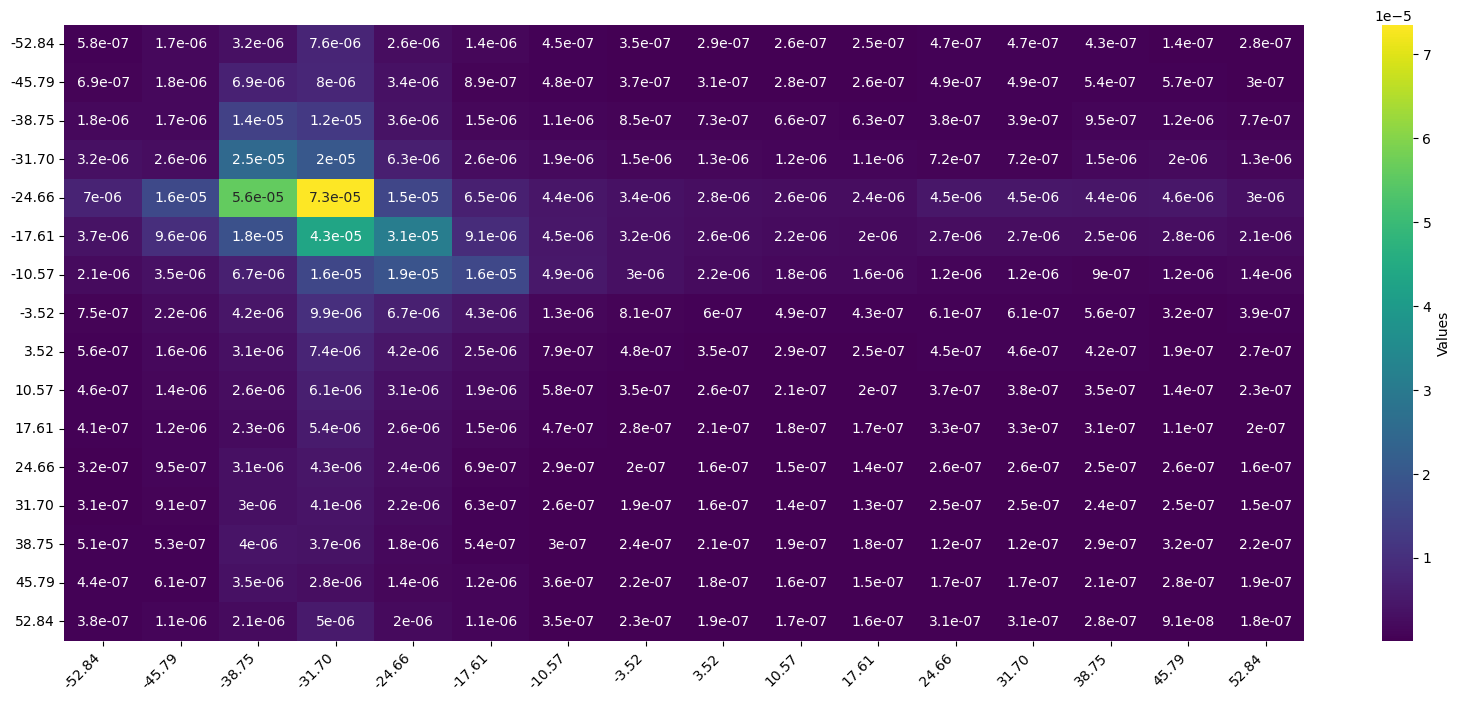

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns

# Reshape the data into a 2D array --> L_t*L_r
data_matrix = m.values.reshape(L_t, L_r)

# Convert index labels to integers
index_labels = [tuple(map(int, index.split(','))) for index in m.index]
rows, cols = zip(*index_labels)

plt.figure(figsize=(20, 8))  
# Create a heatmap using seaborn
sns.heatmap(data_matrix, cmap='viridis', annot=True, cbar_kws={'label': 'Values'})

#plt.xticks(np.arange(L_r) + 0.5, range(1, L_r+1))
#plt.yticks(np.arange(L_t) + 0.5, range(1, L_t+1))
plt.xticks(np.arange(L_r) + 0.5, ["{:.2f}".format(deg) for deg in beam_degs], rotation=45, ha='right')
plt.yticks(np.arange(L_t) + 0.5, ["{:.2f}".format(deg) for deg in beam_degs], rotation=0, ha='right')
# Display the heatmap
plt.show()

C:\Users\dehghani\AppData\Local\Temp\ipykernel_32396\518806875.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots(1, 1, figsize=(12, 4))


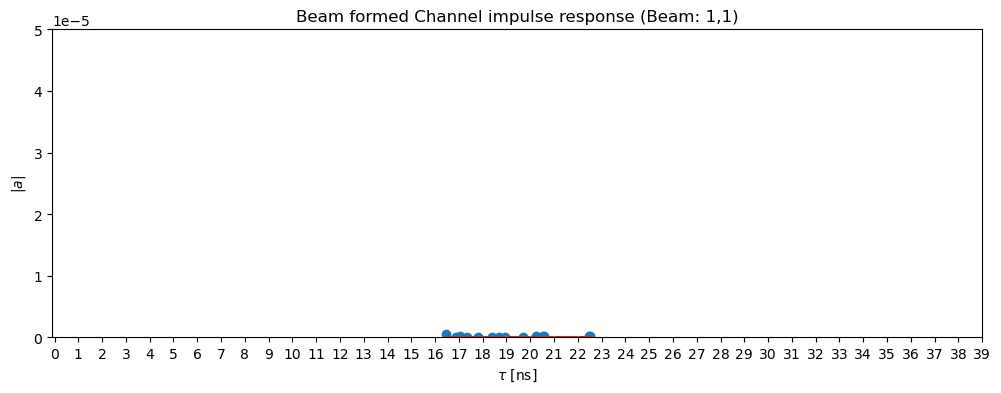

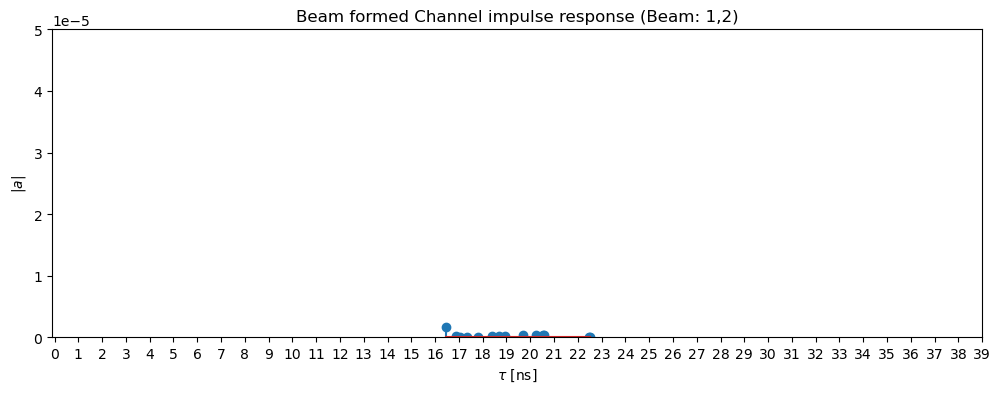

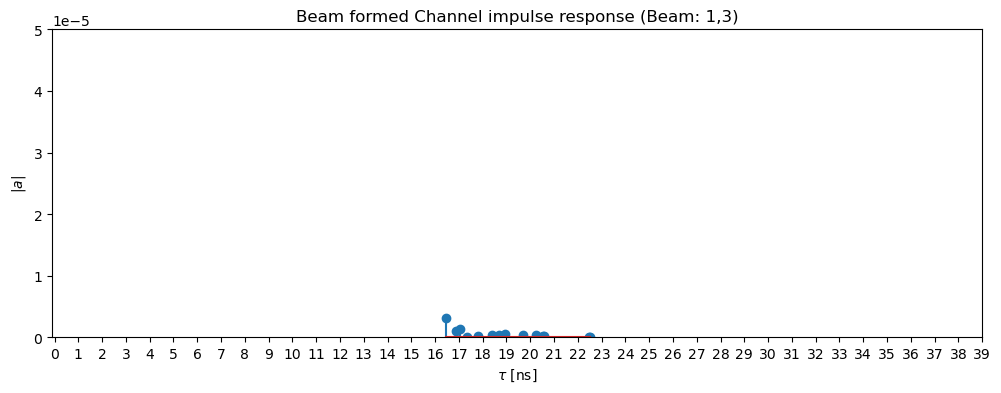

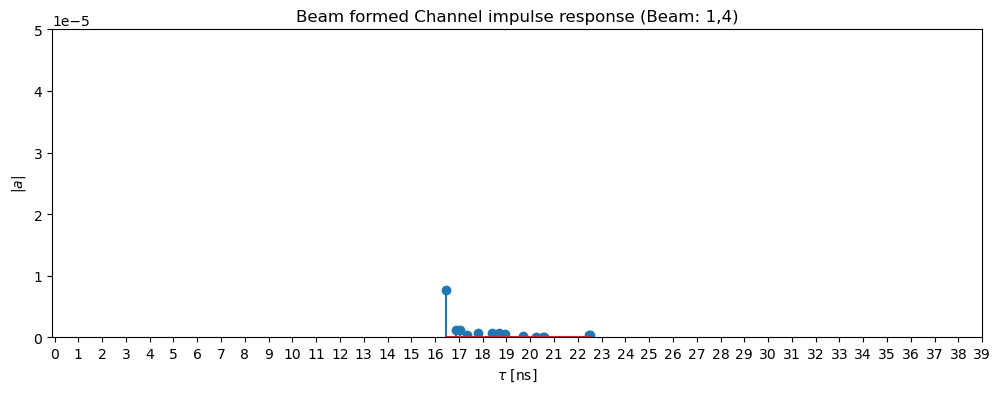

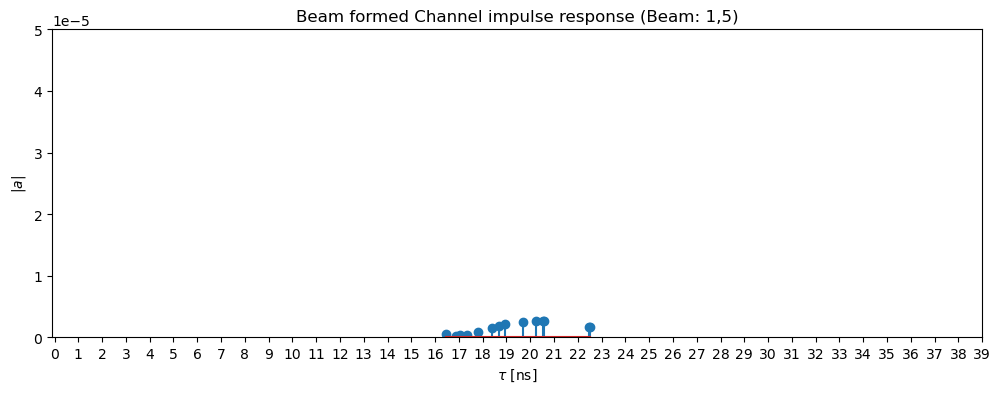

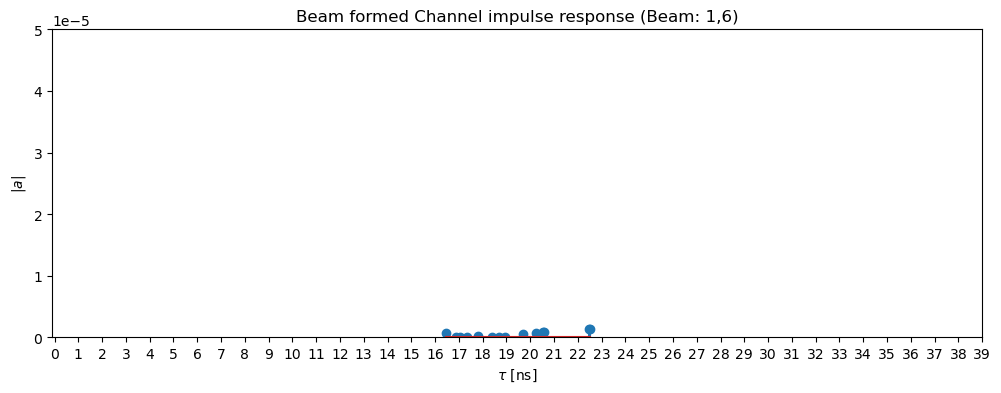

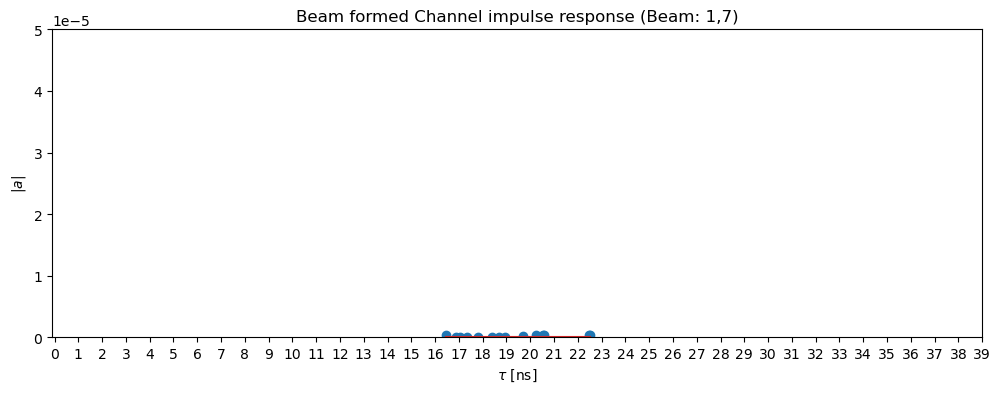

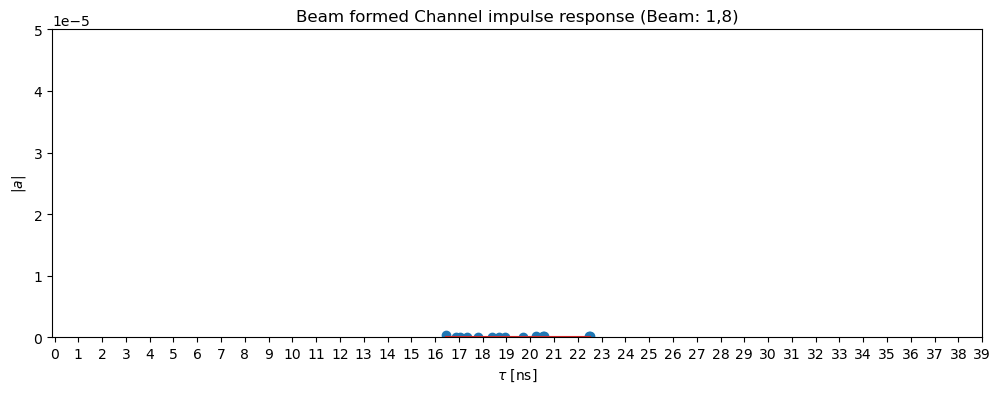

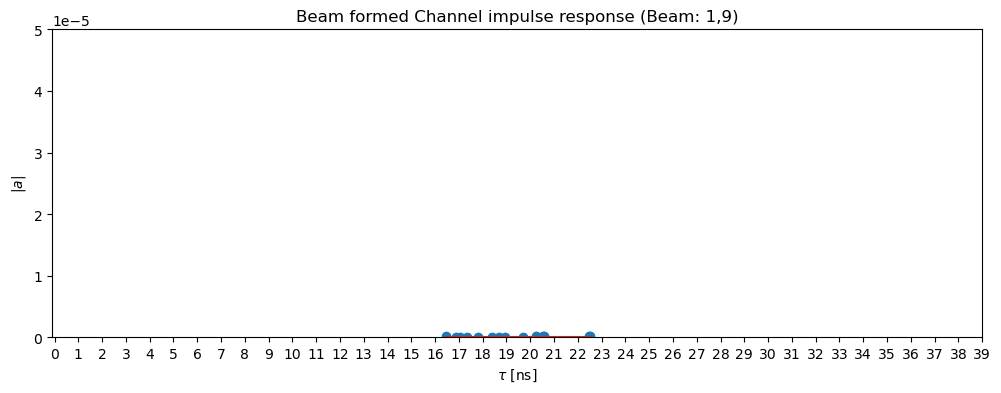

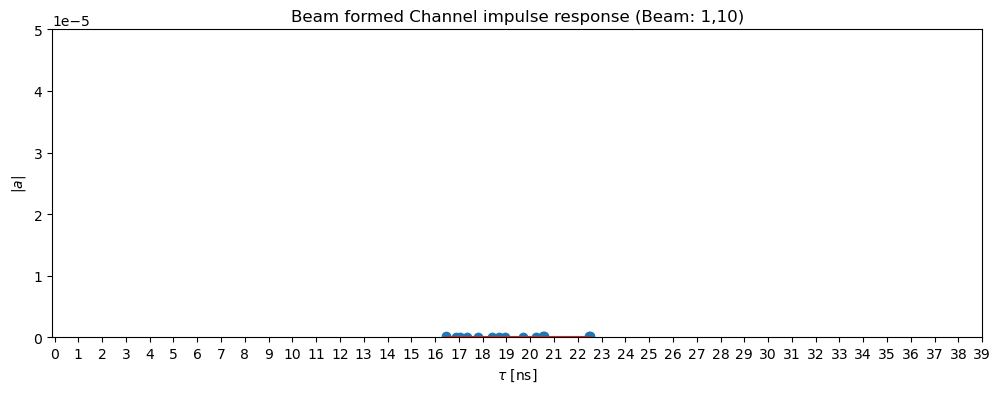

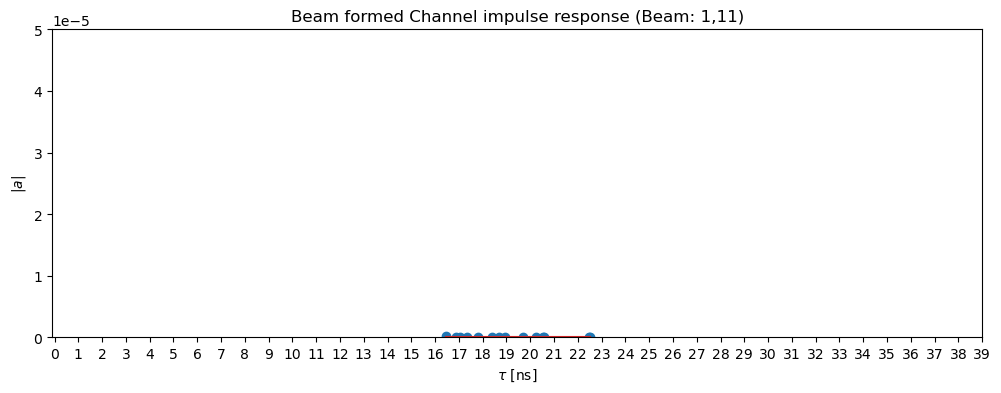

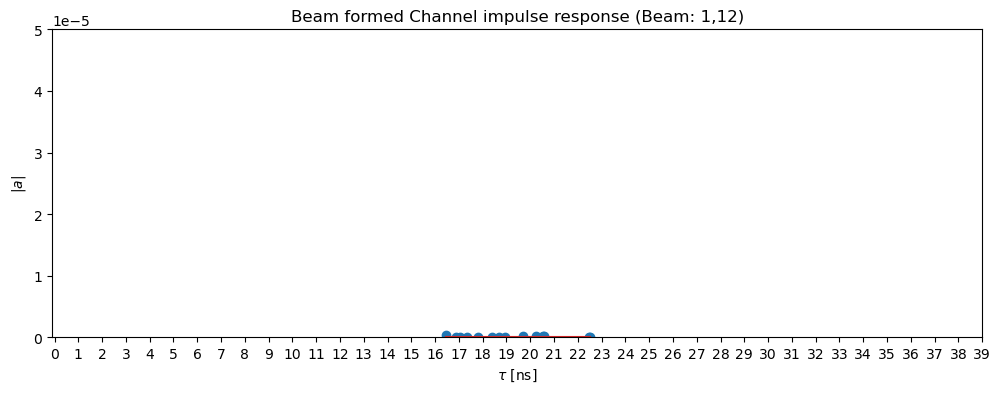

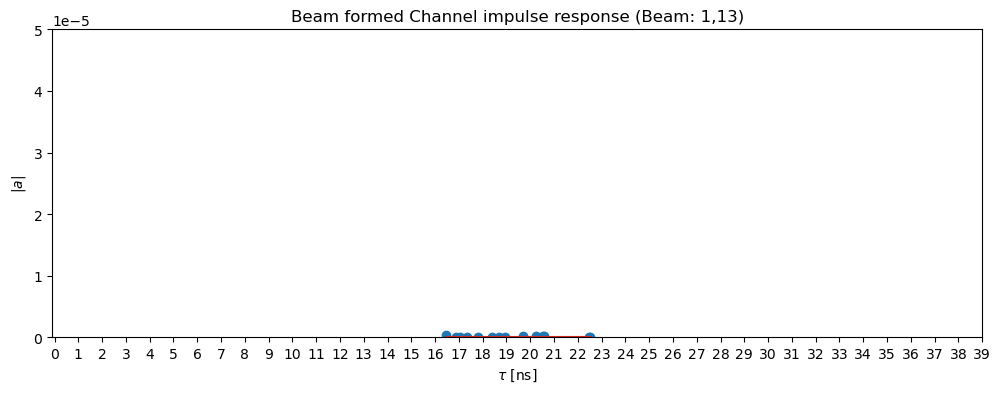

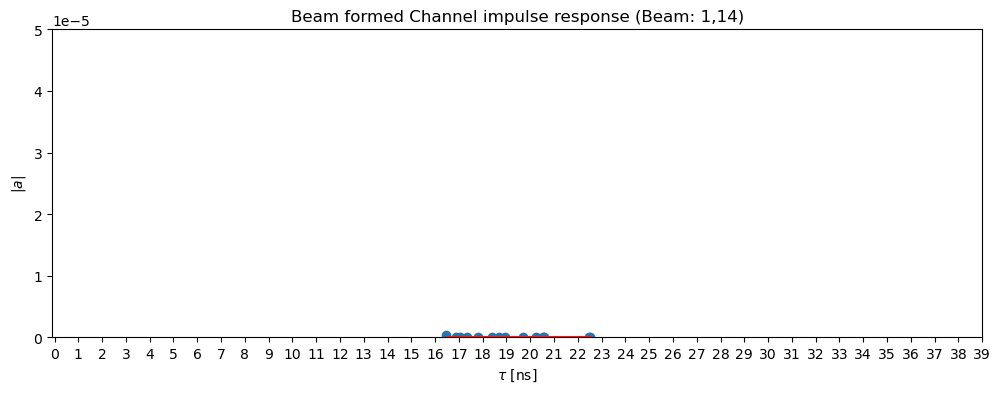

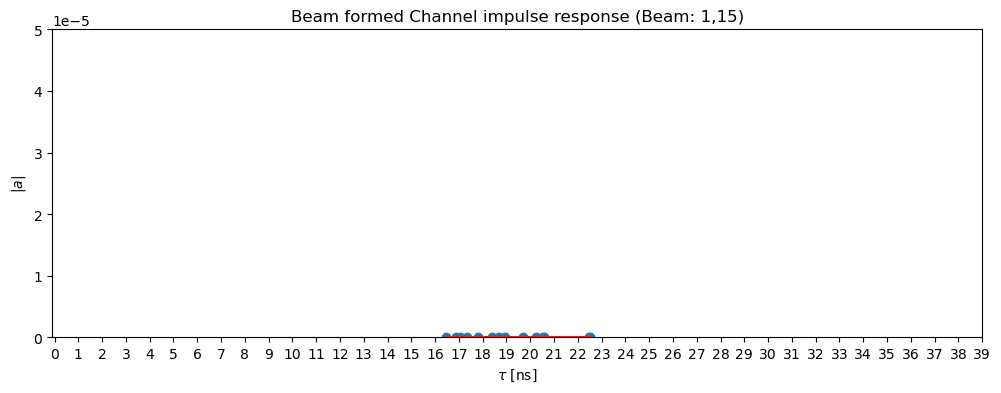

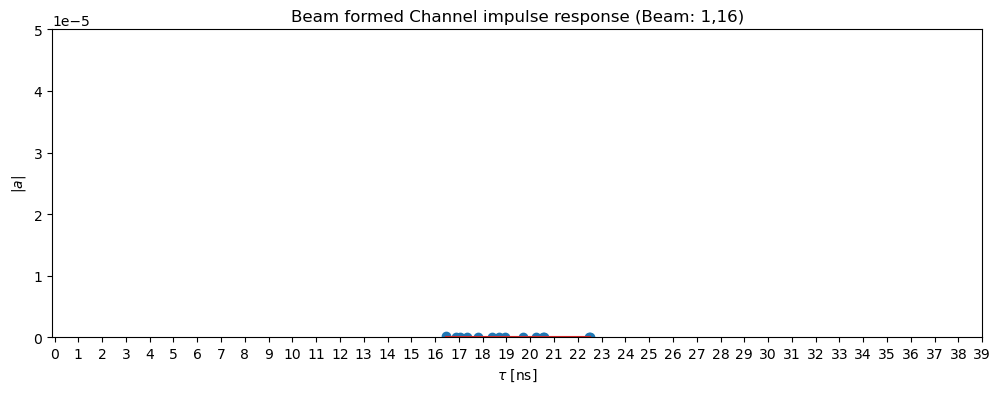

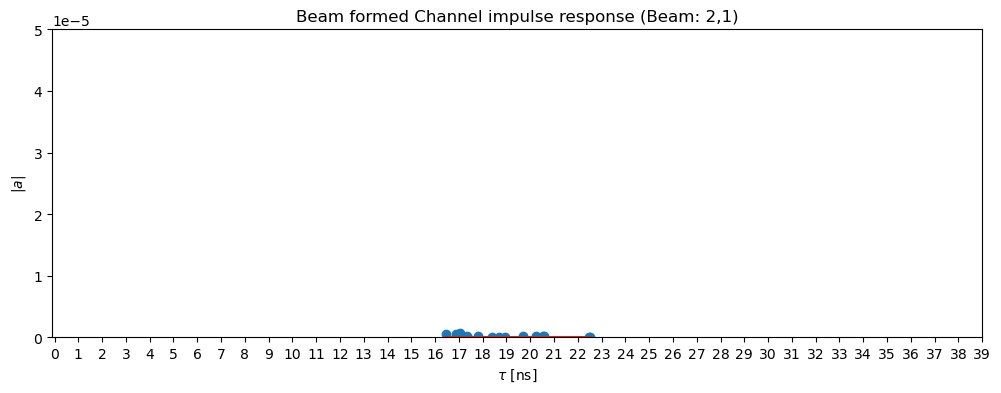

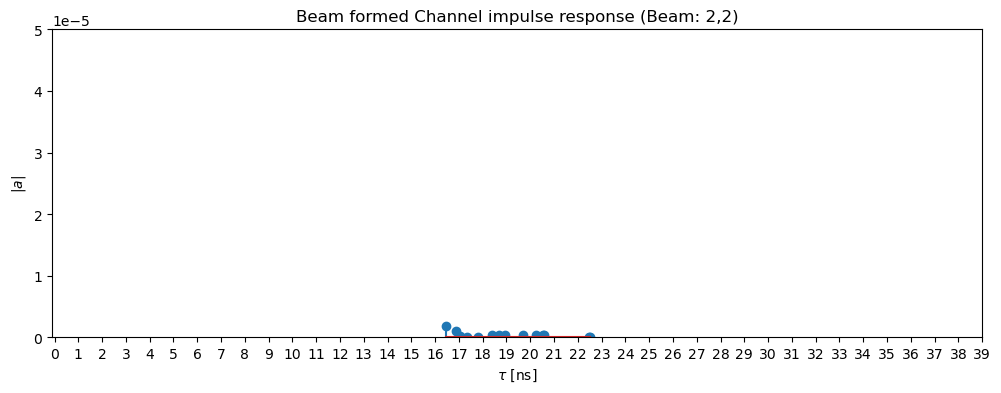

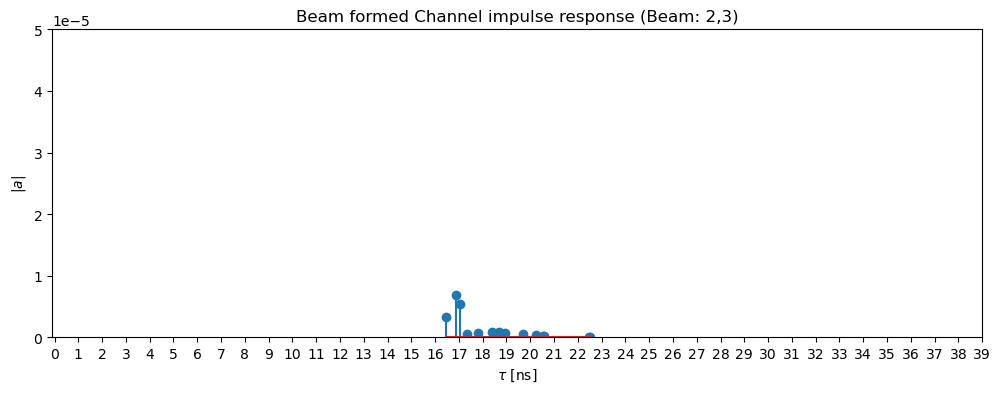

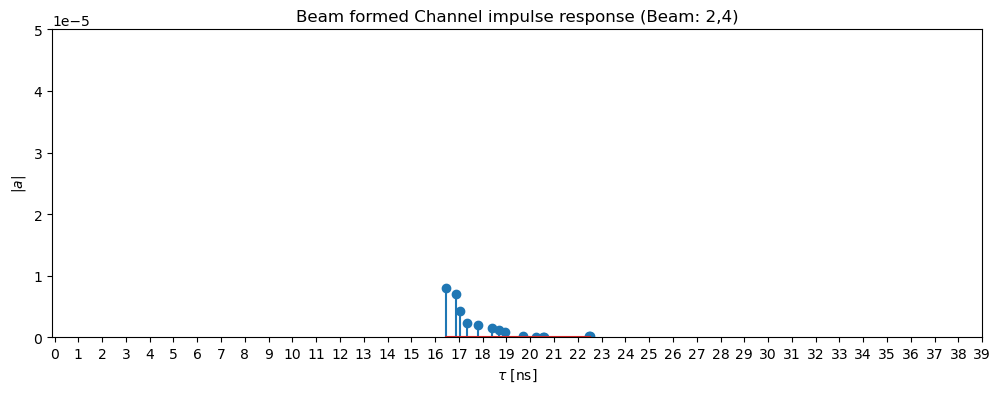

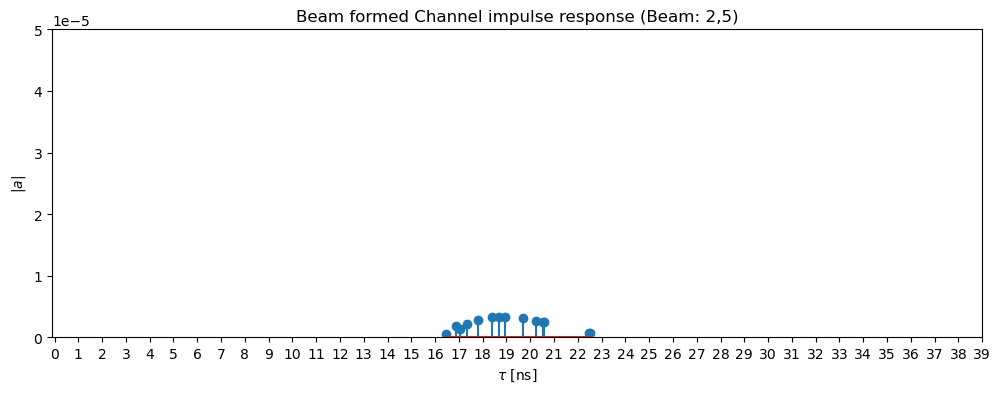

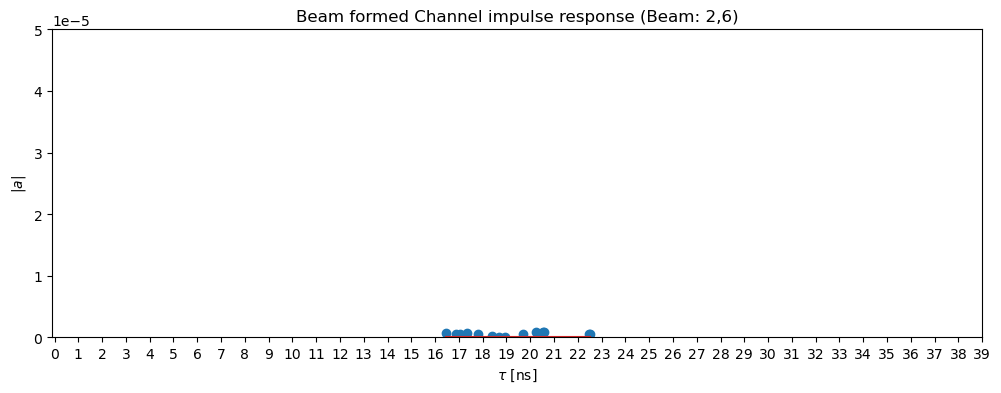

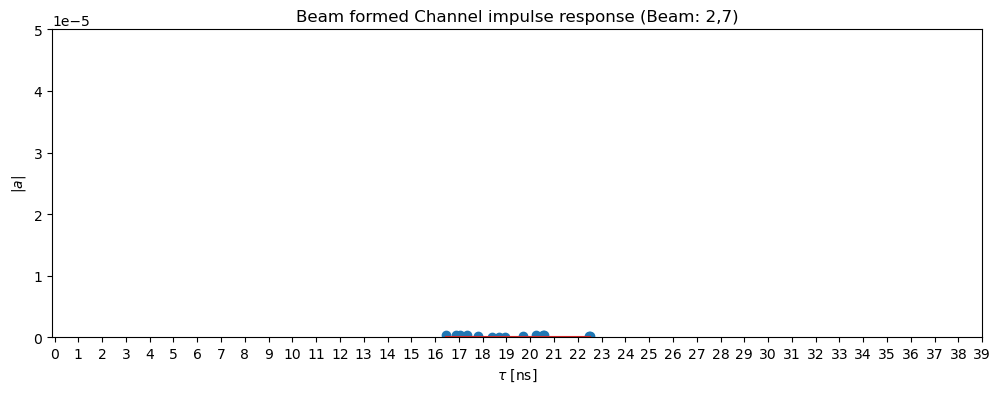

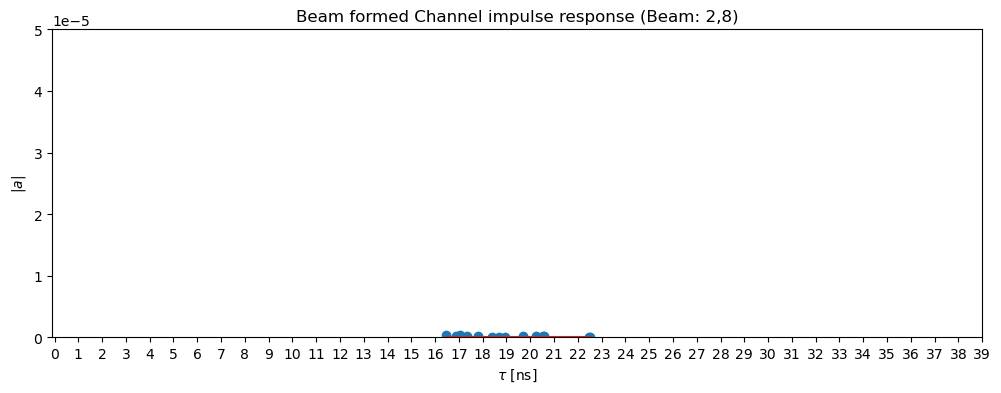

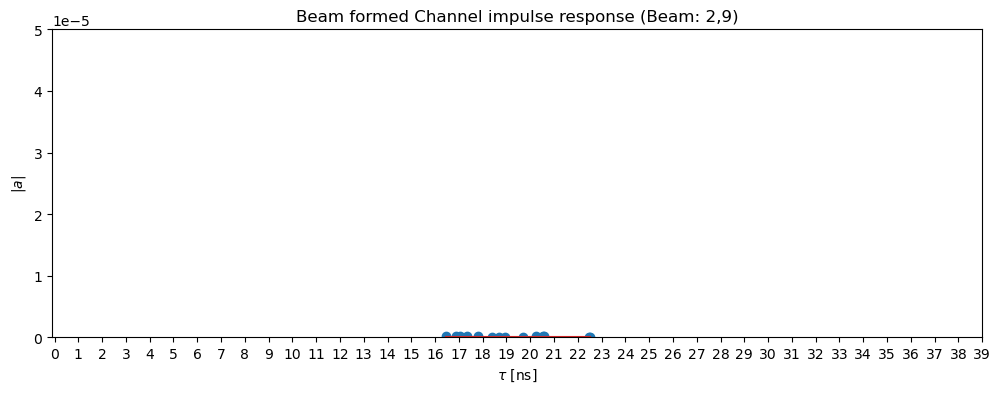

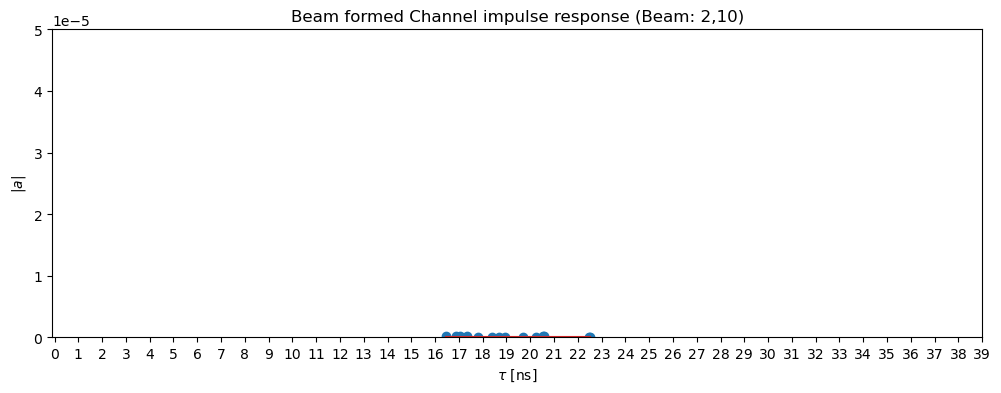

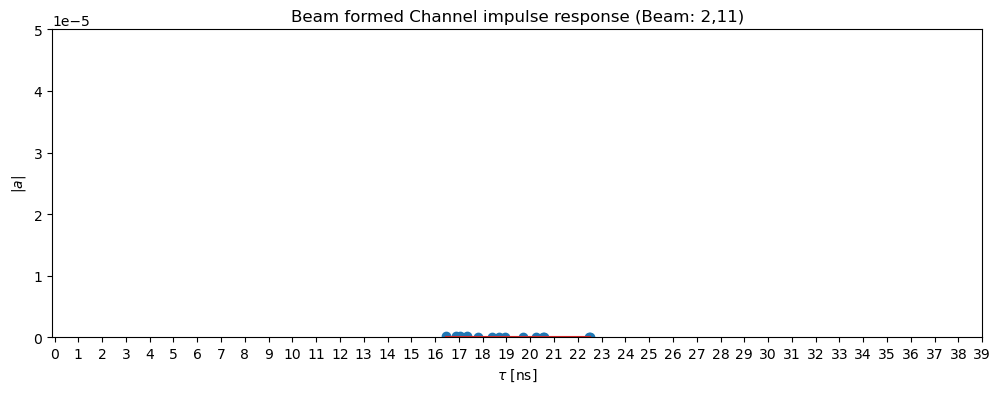

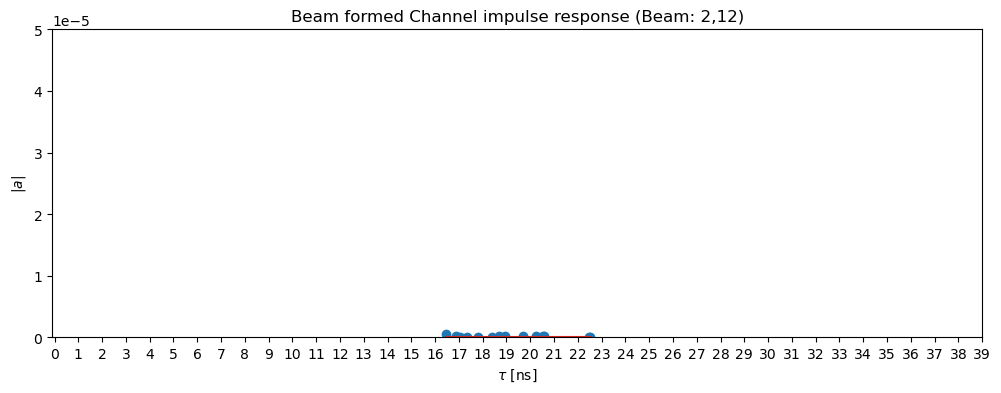

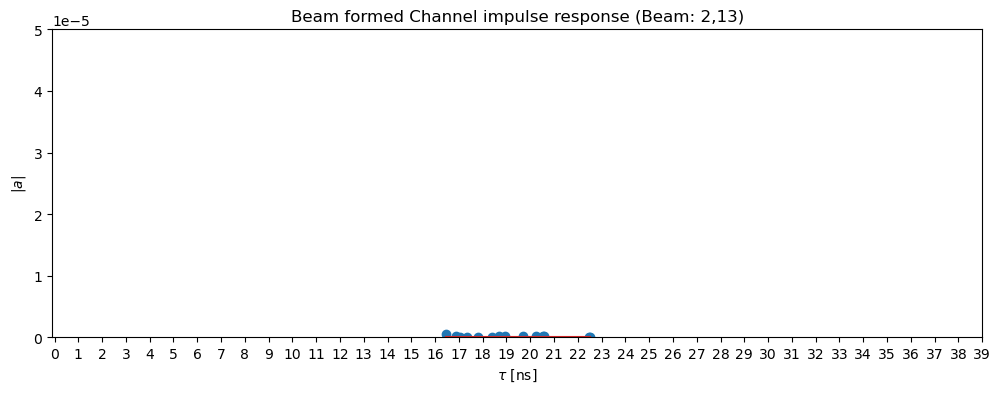

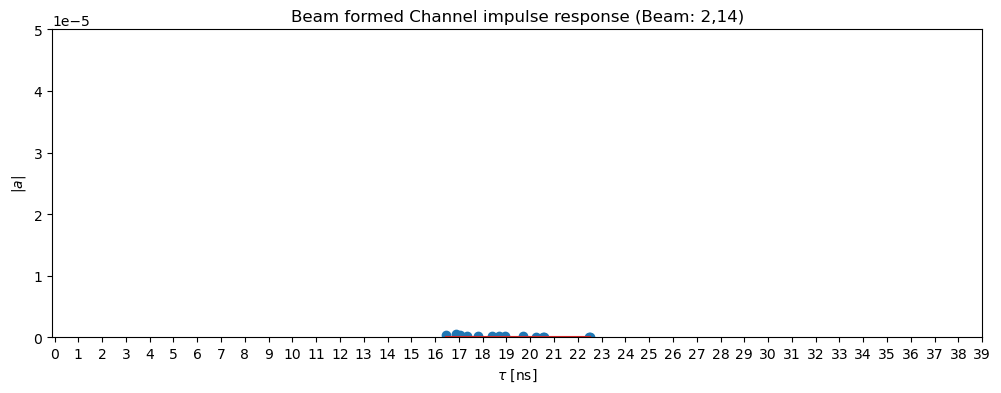

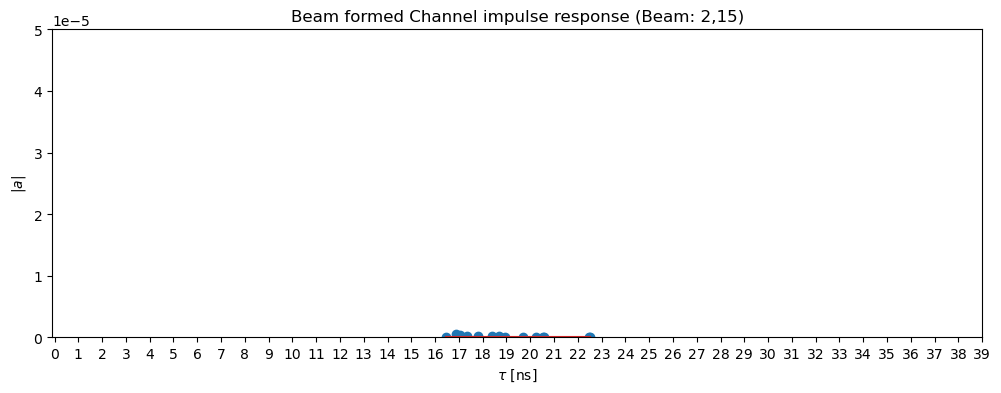

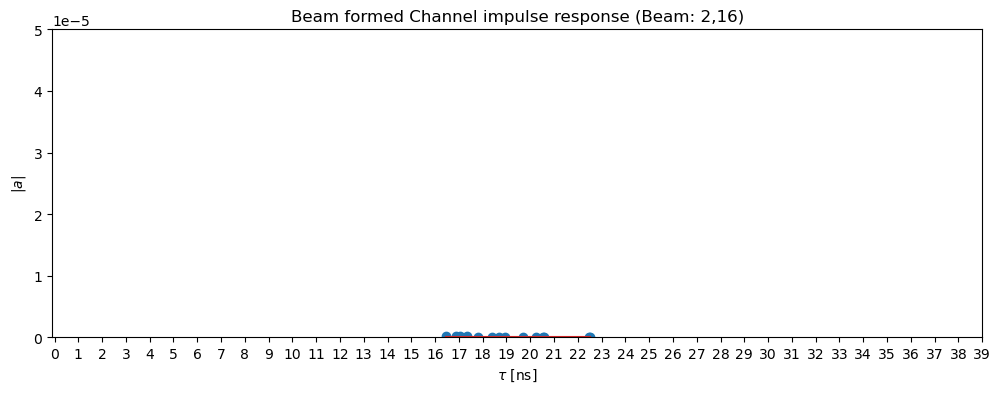

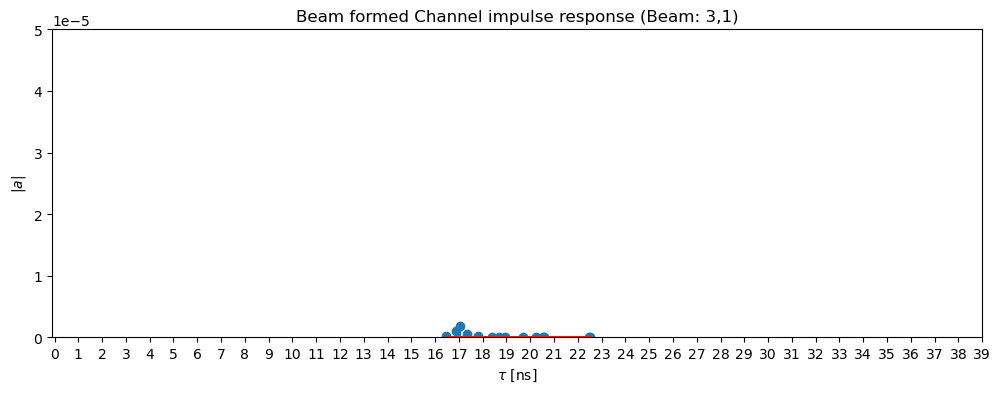

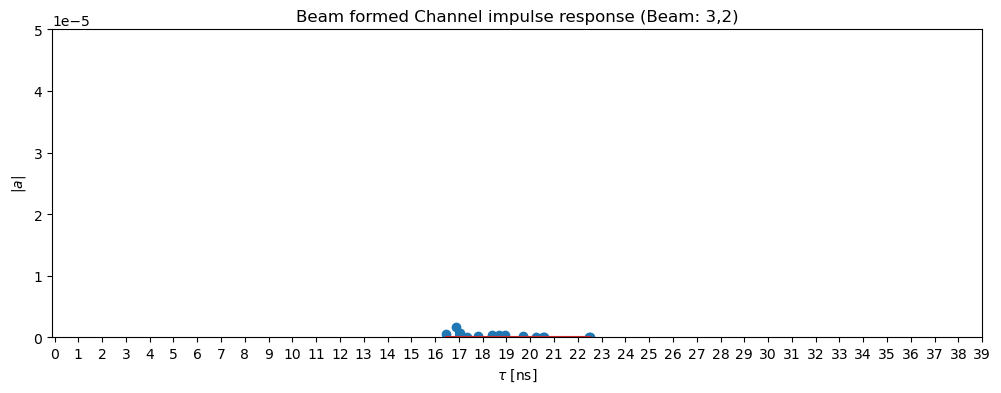

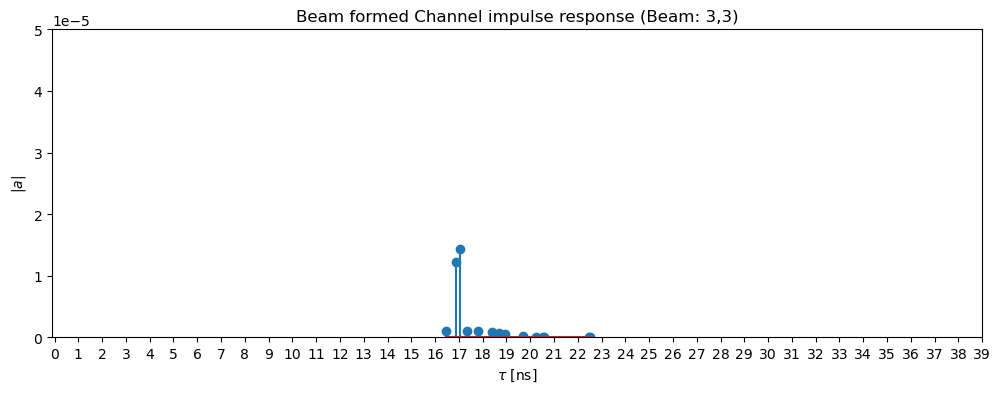

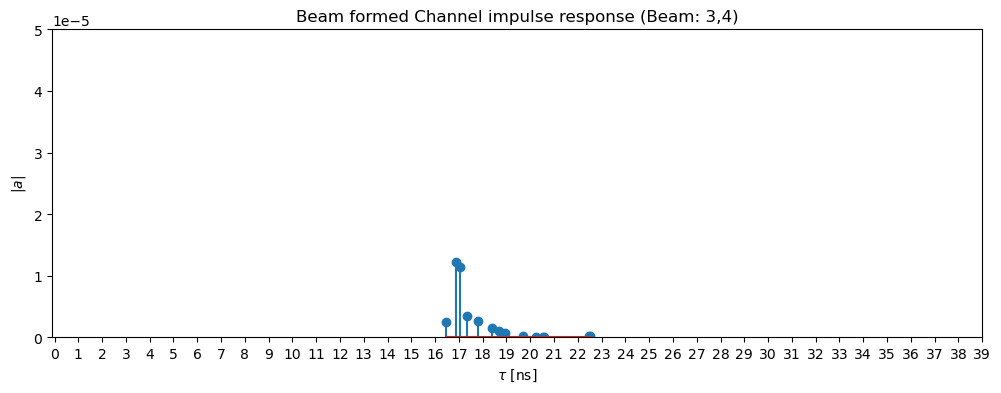

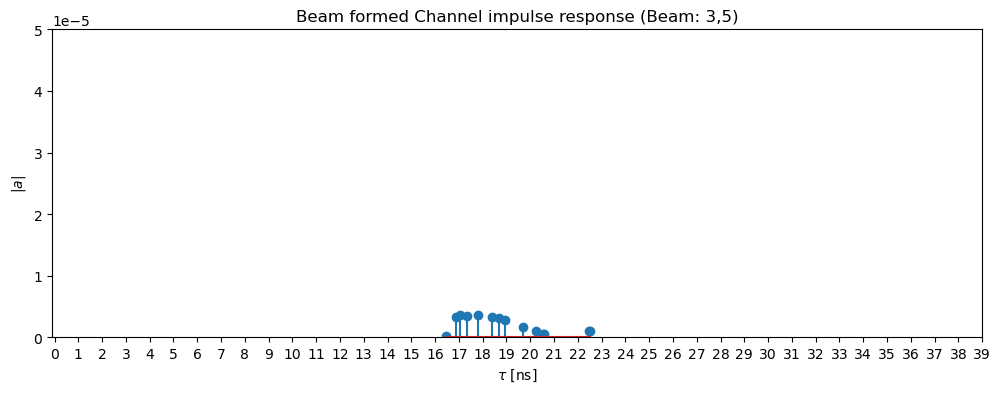

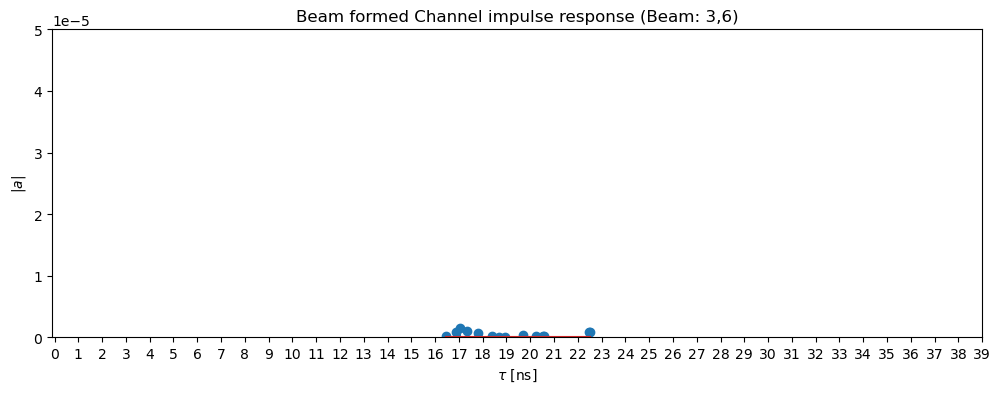

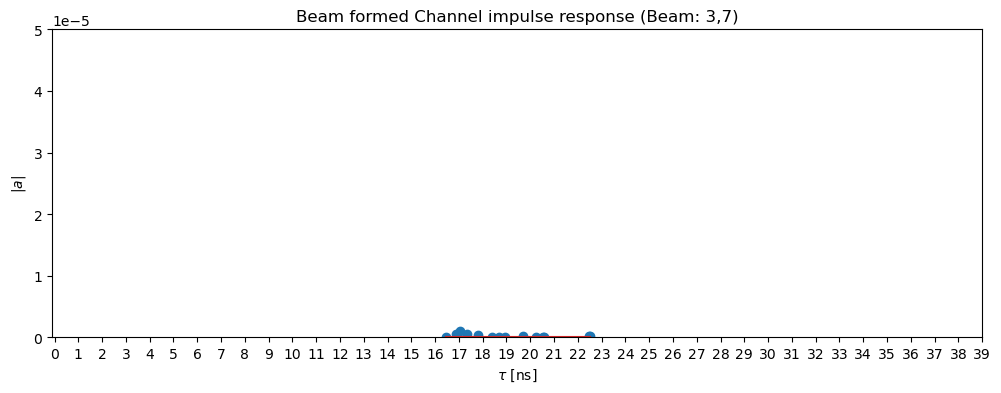

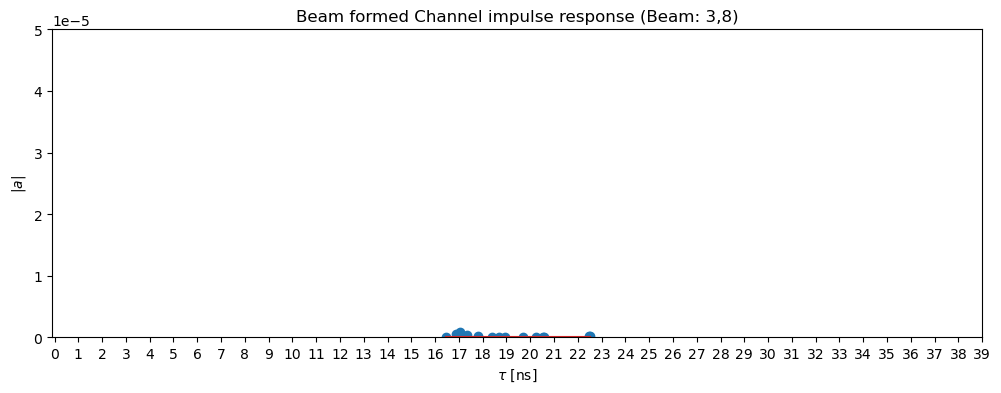

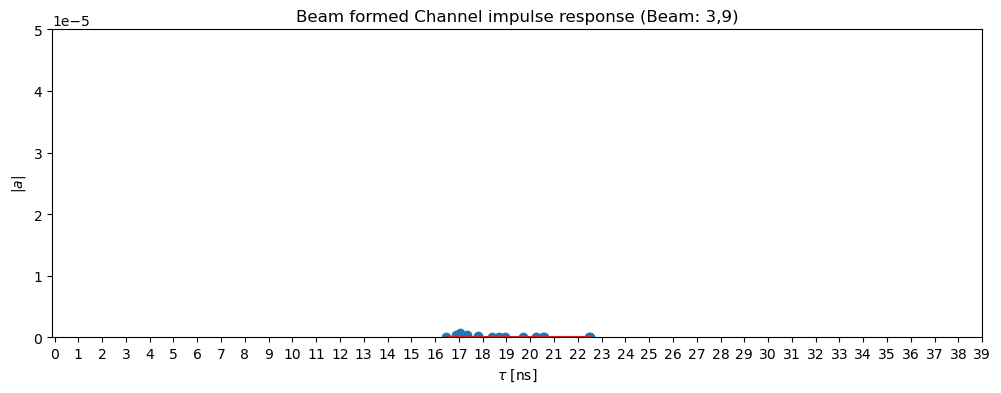

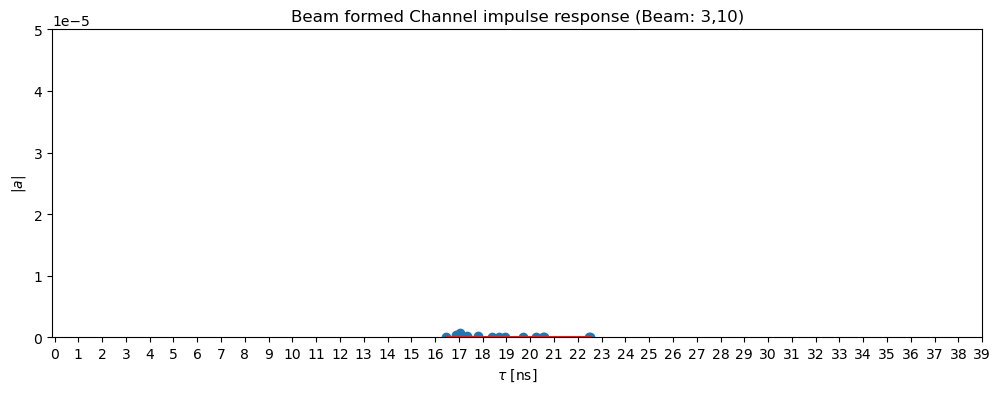

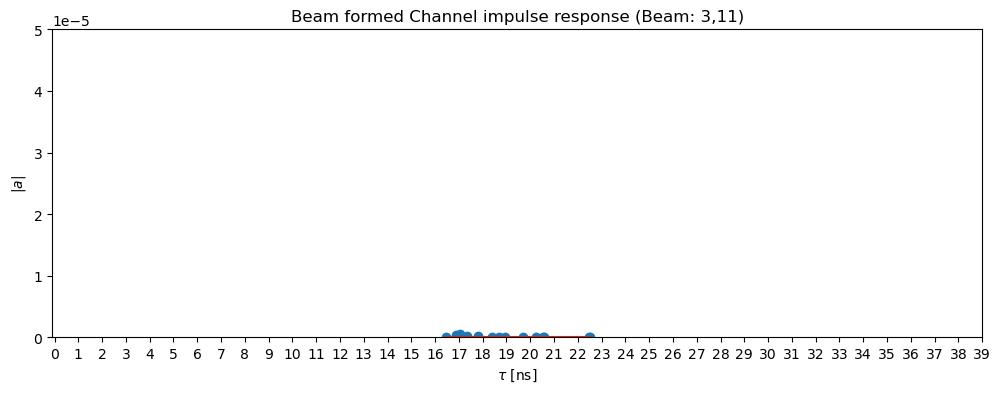

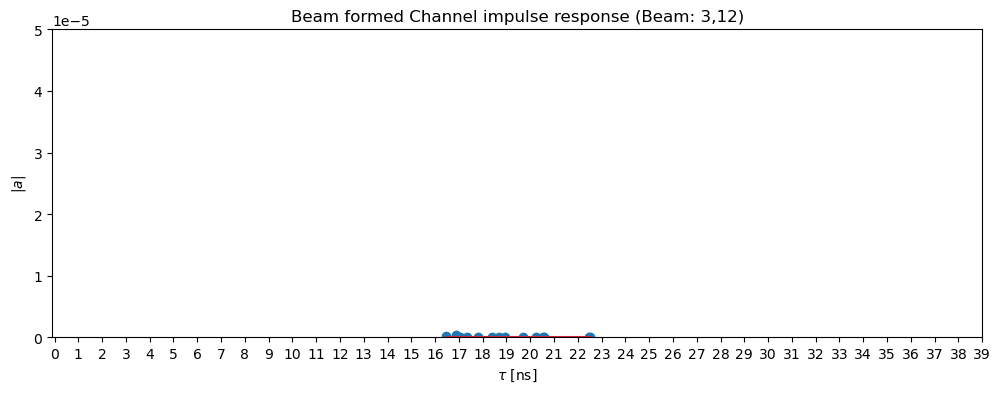

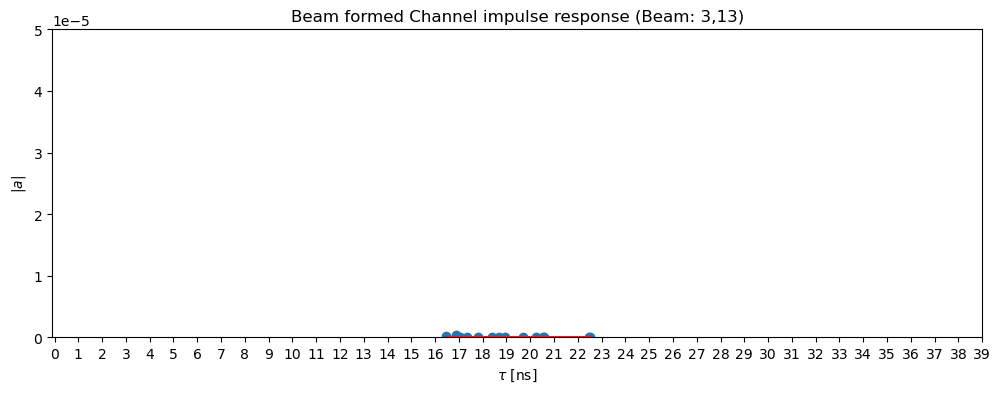

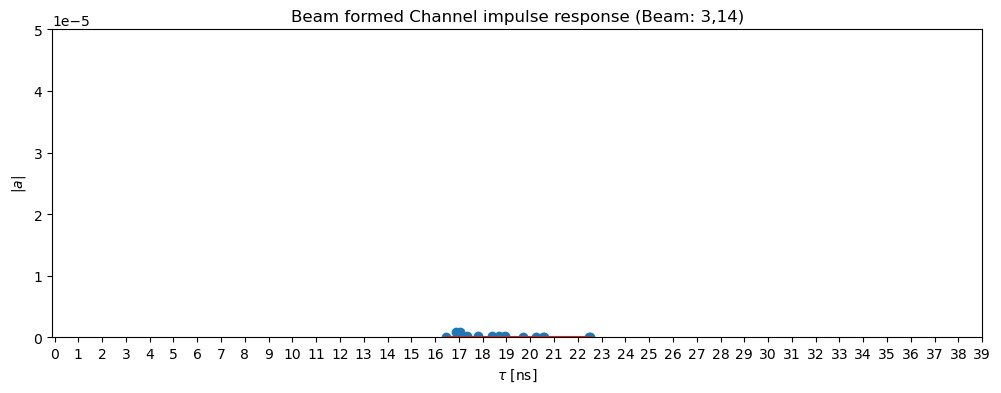

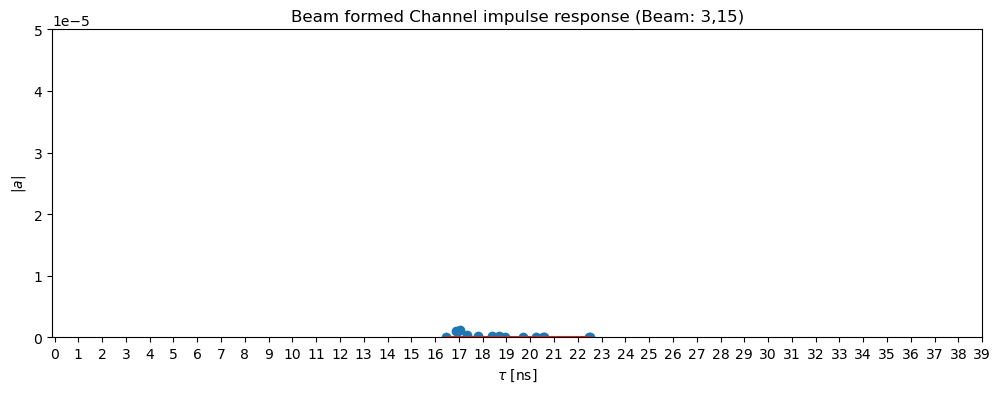

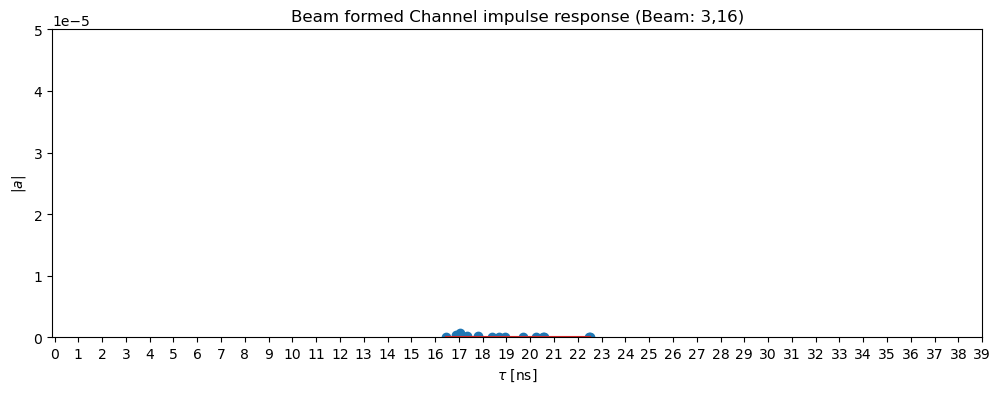

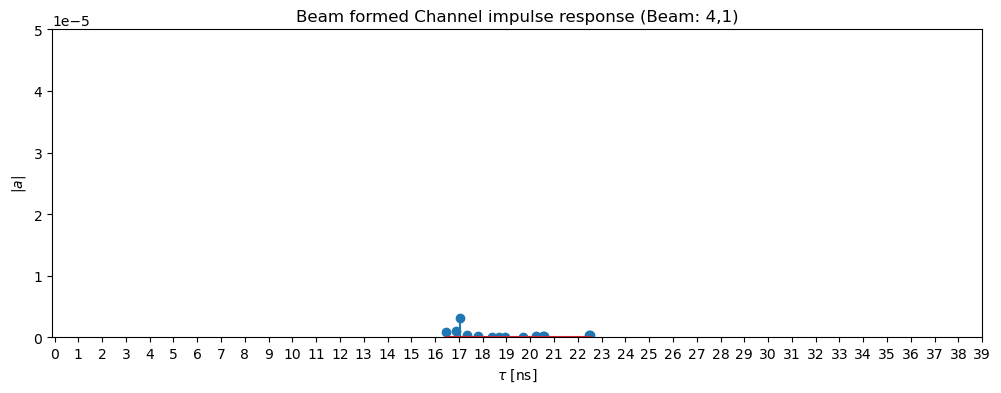

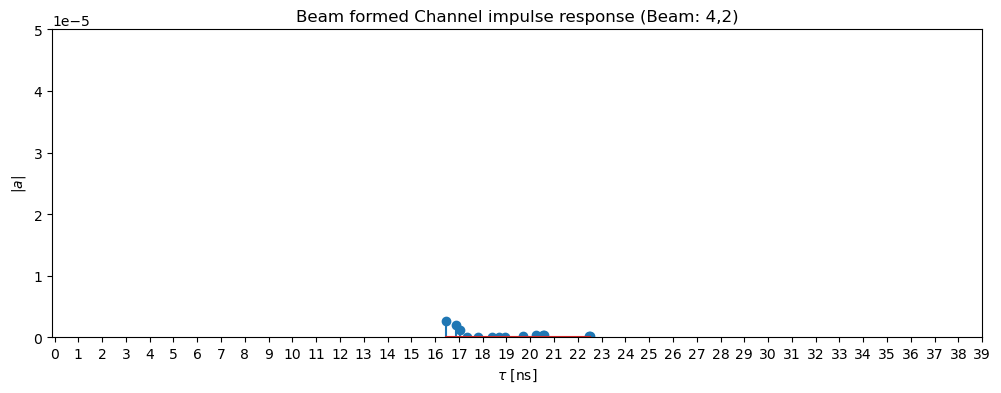

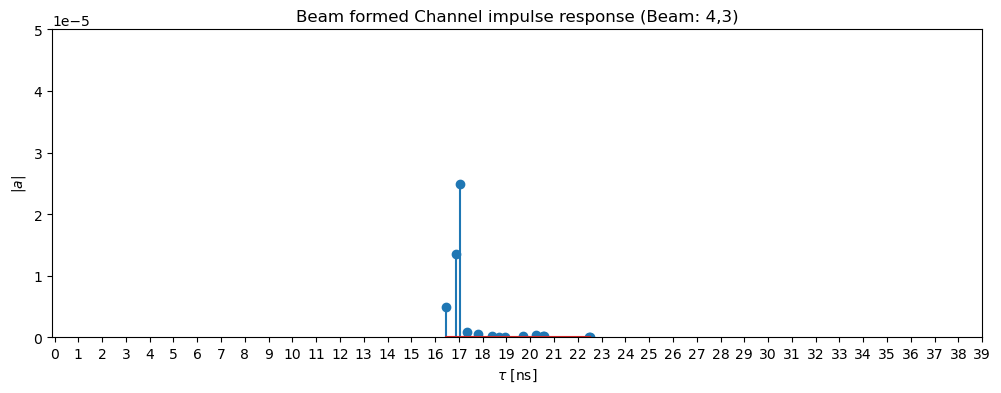

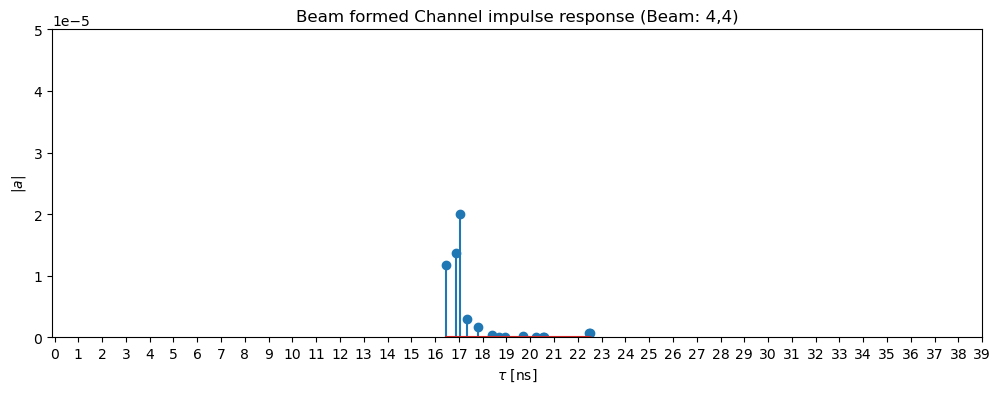

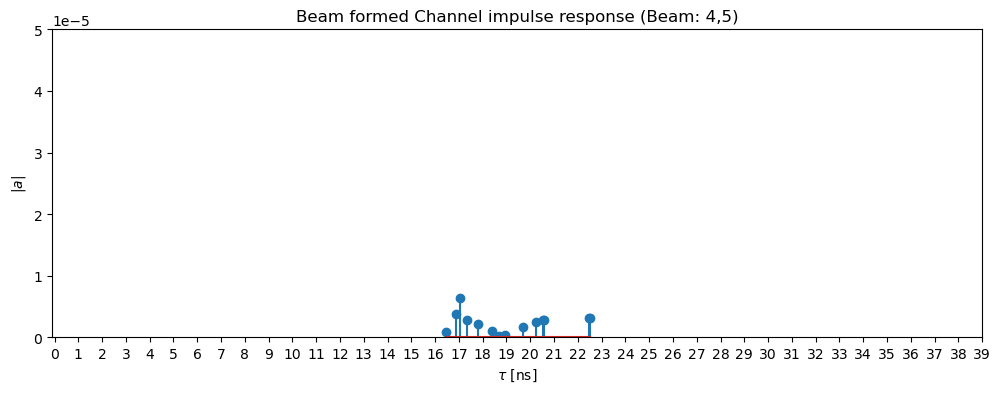

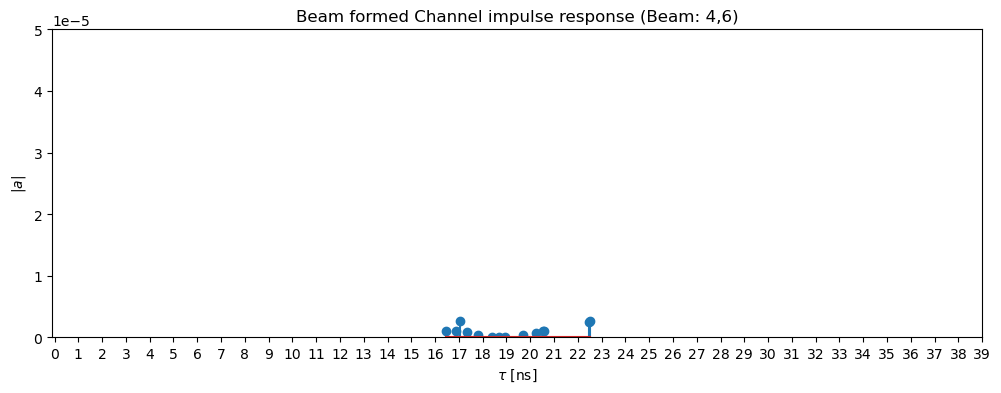

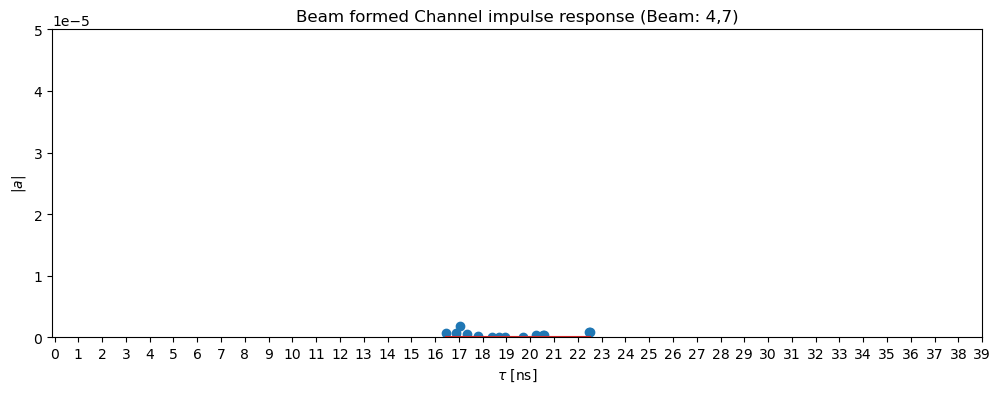

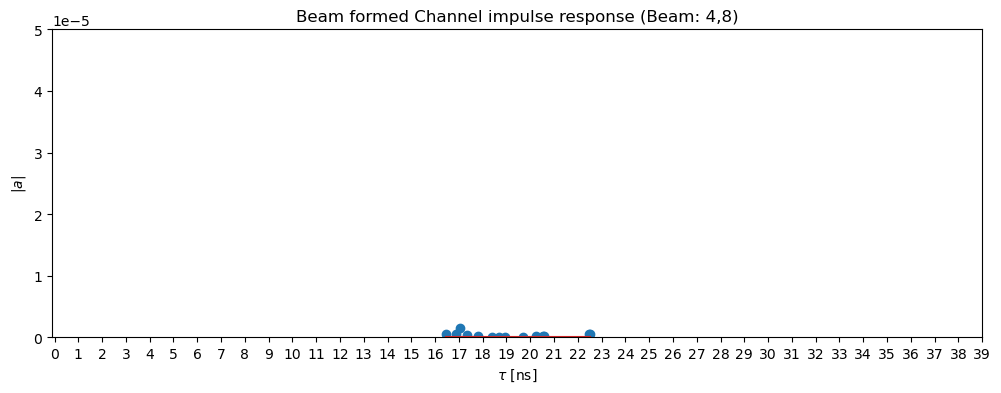

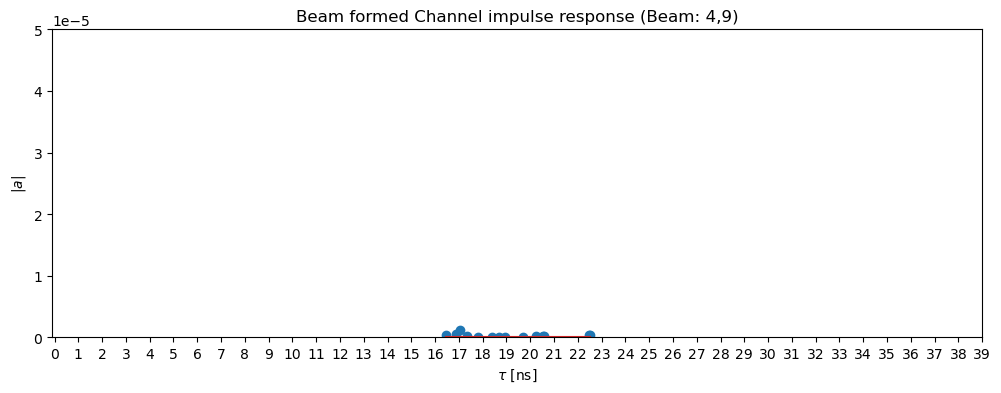

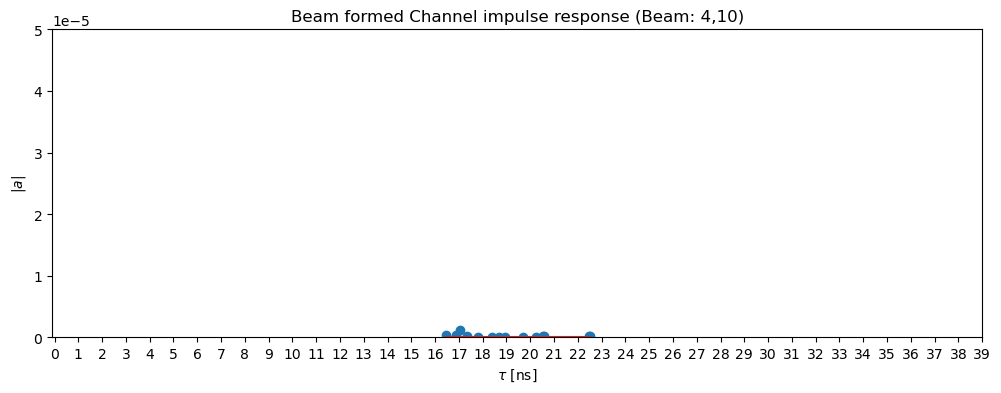

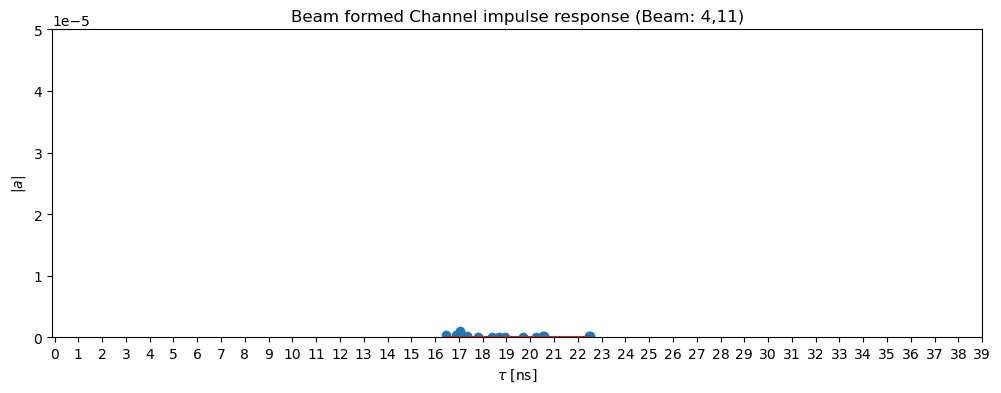

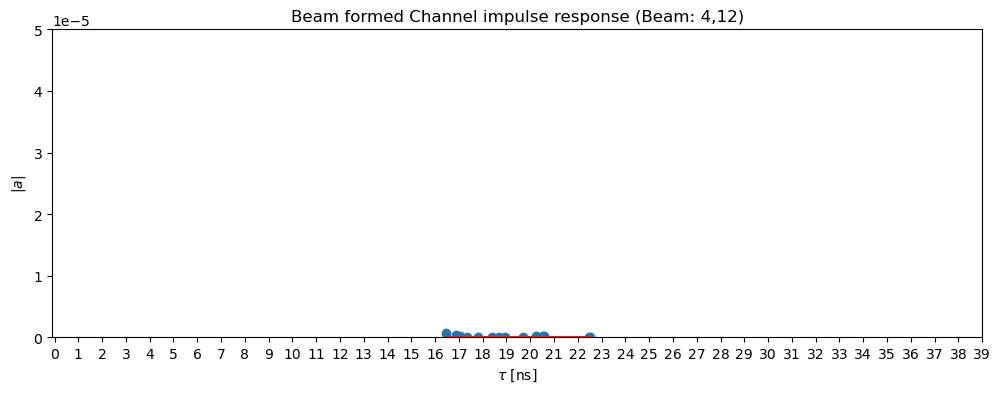

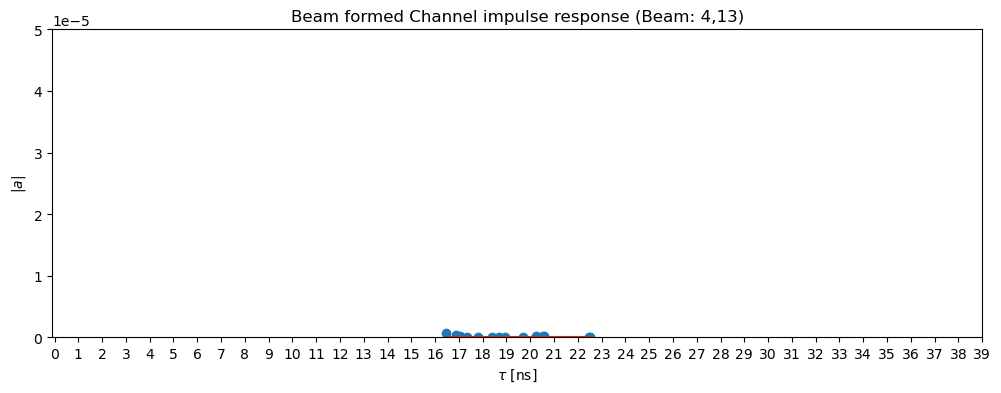

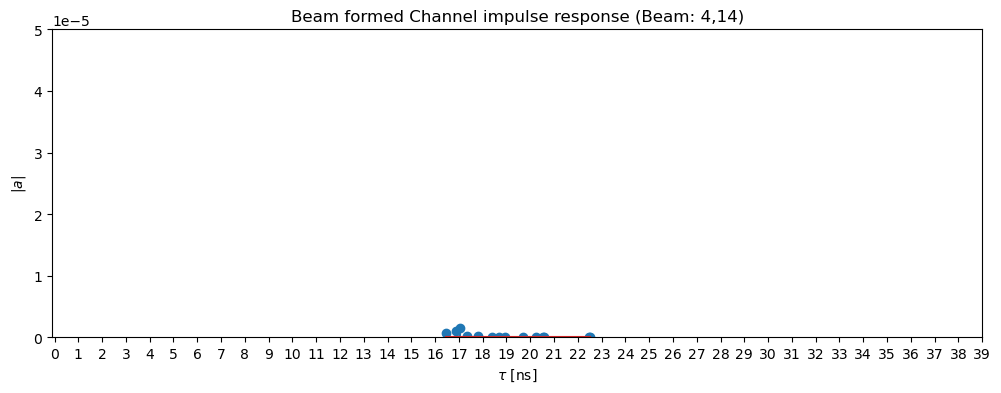

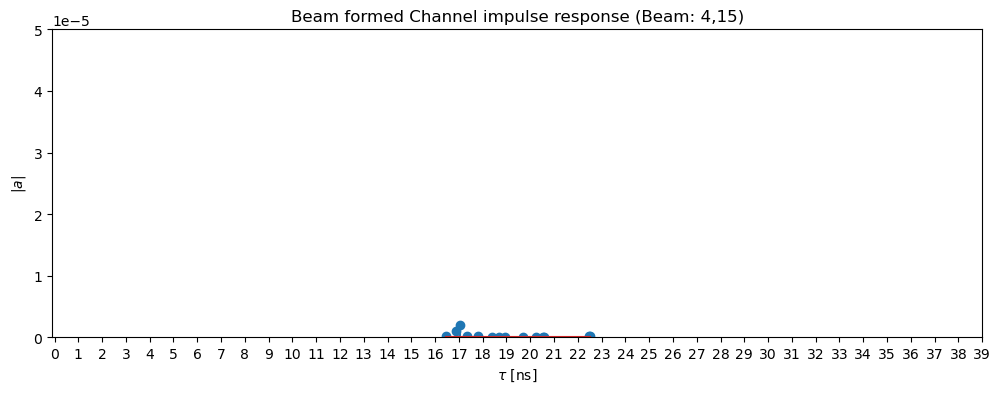

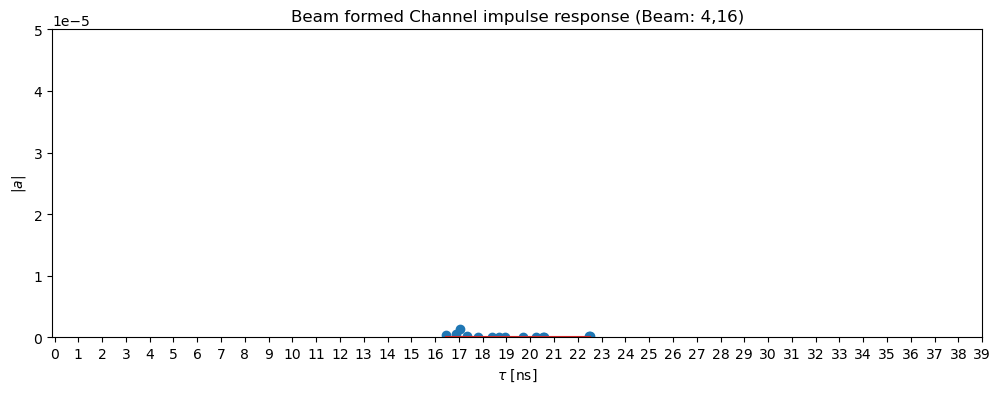

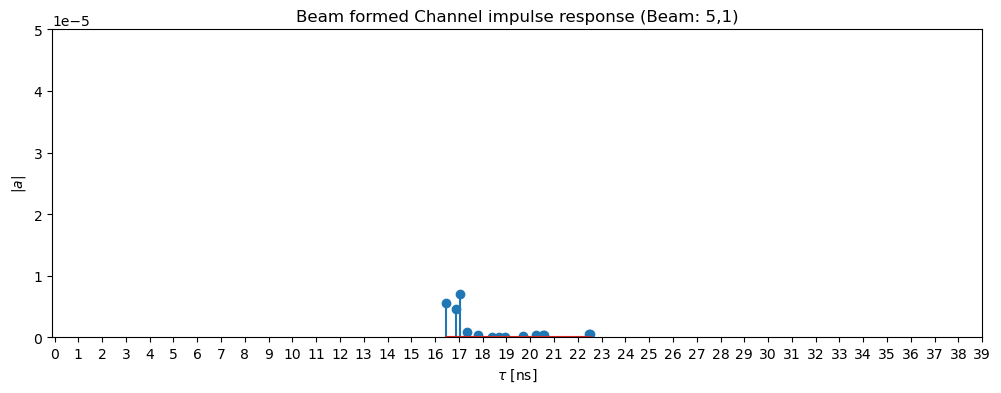

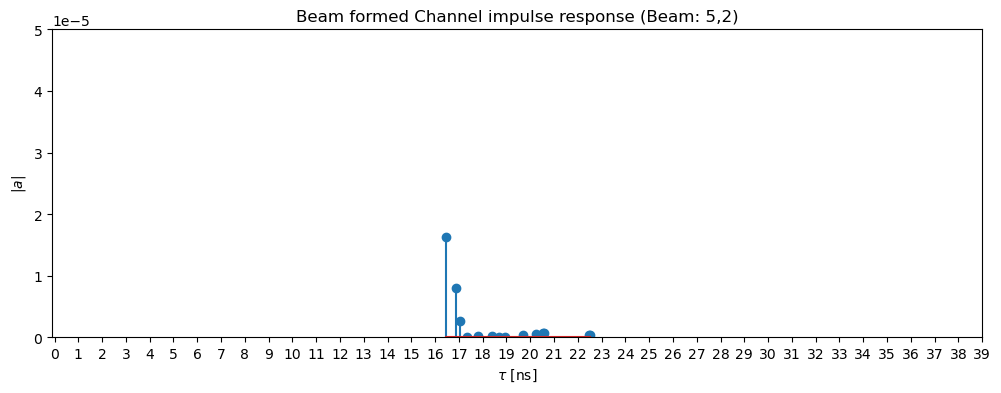

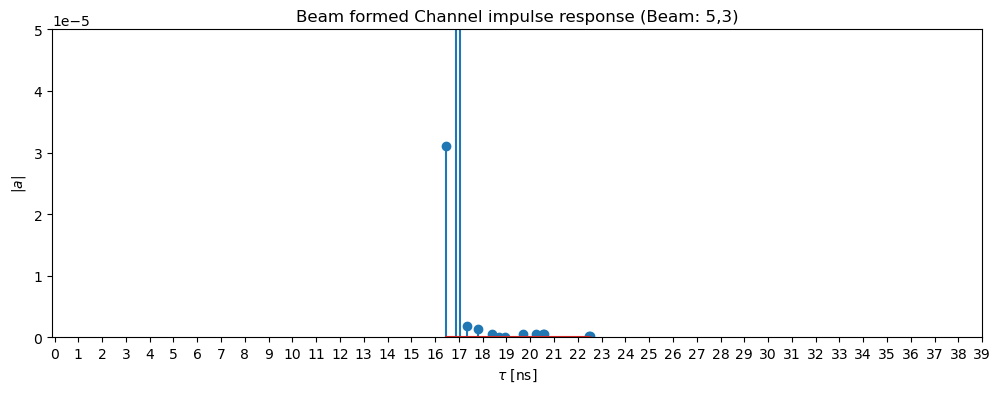

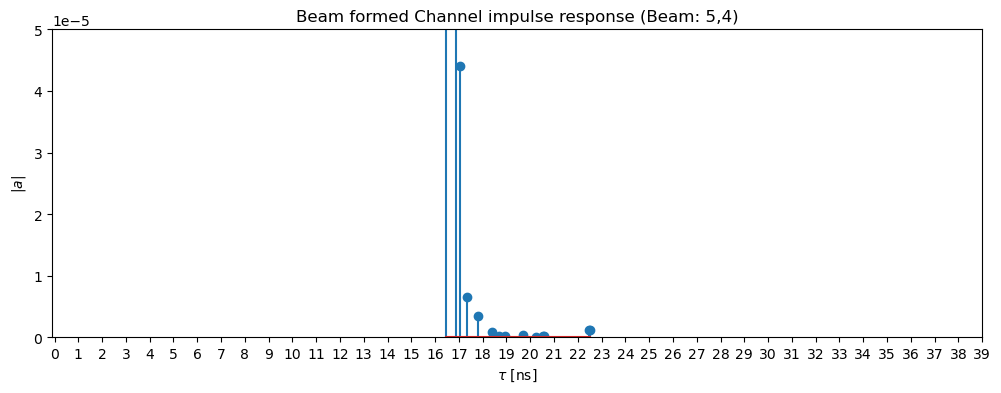

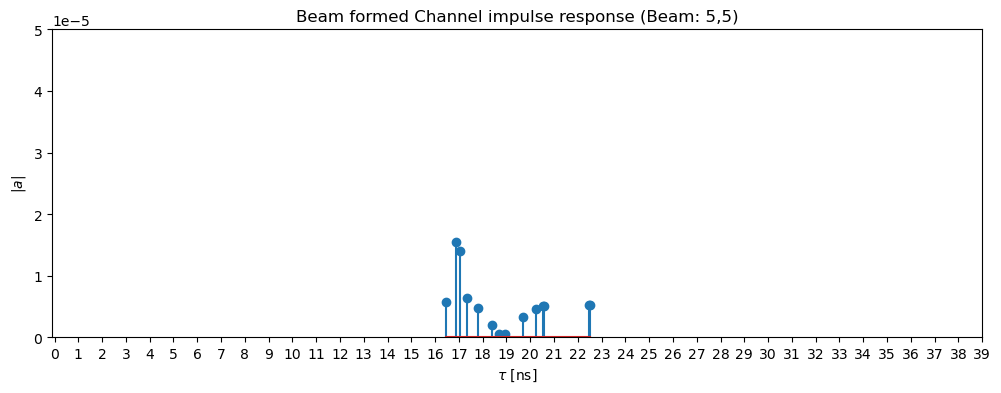

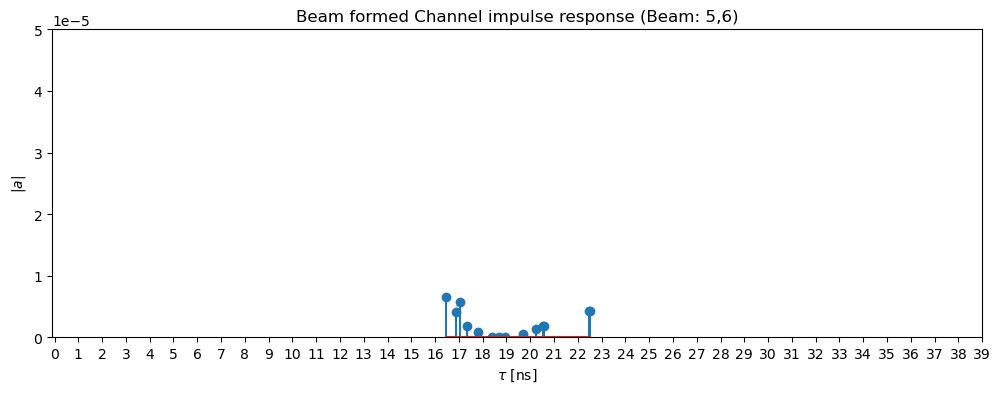

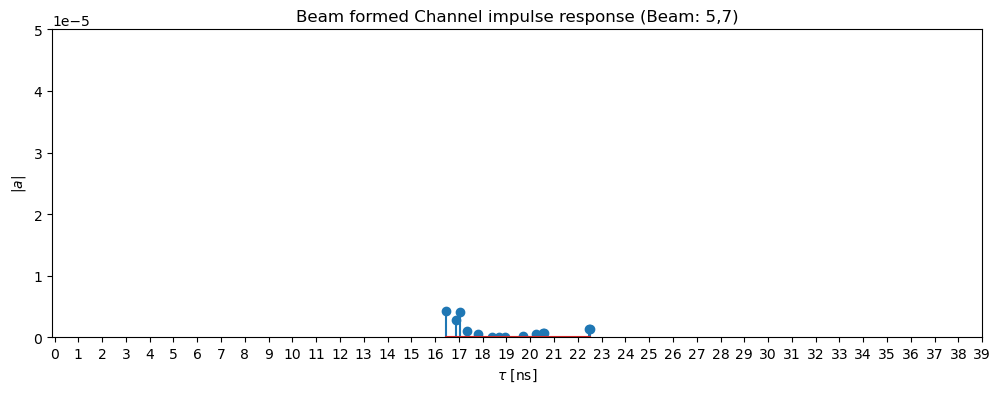

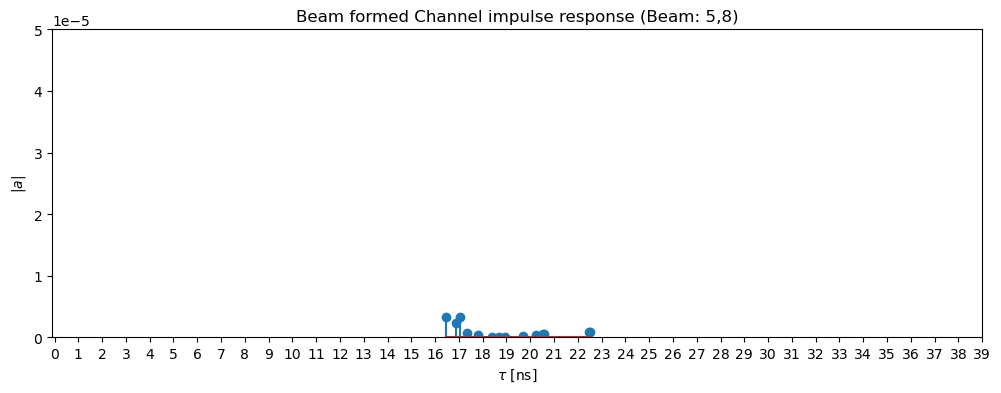

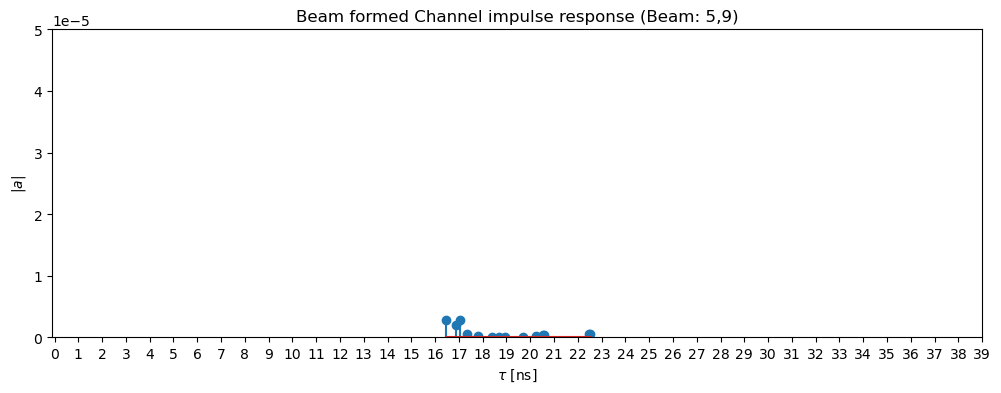

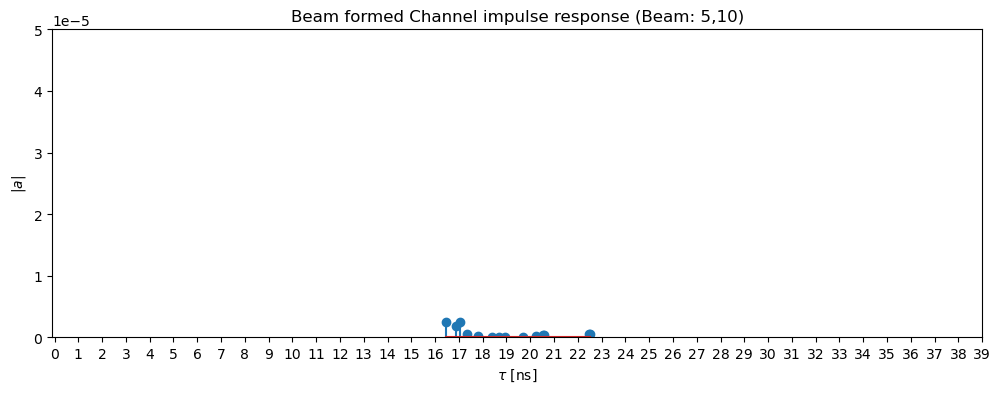

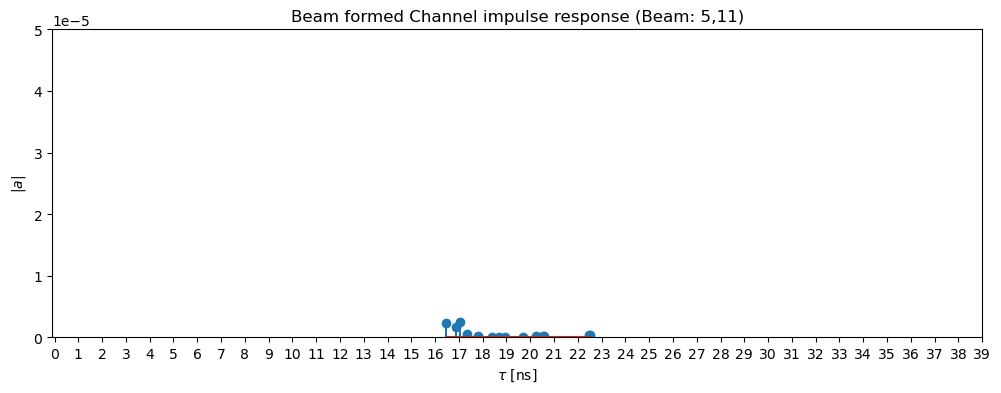

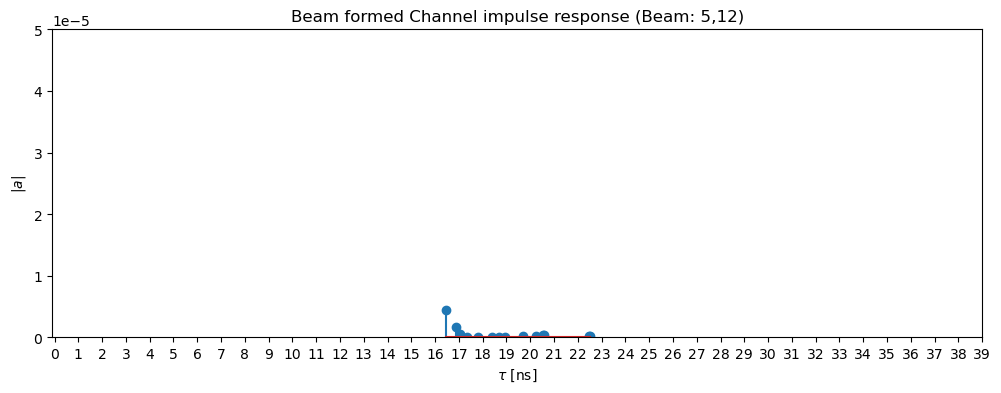

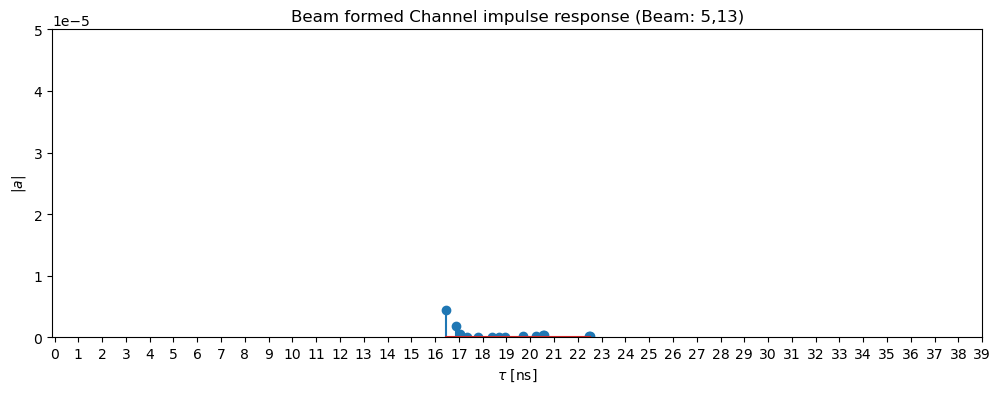

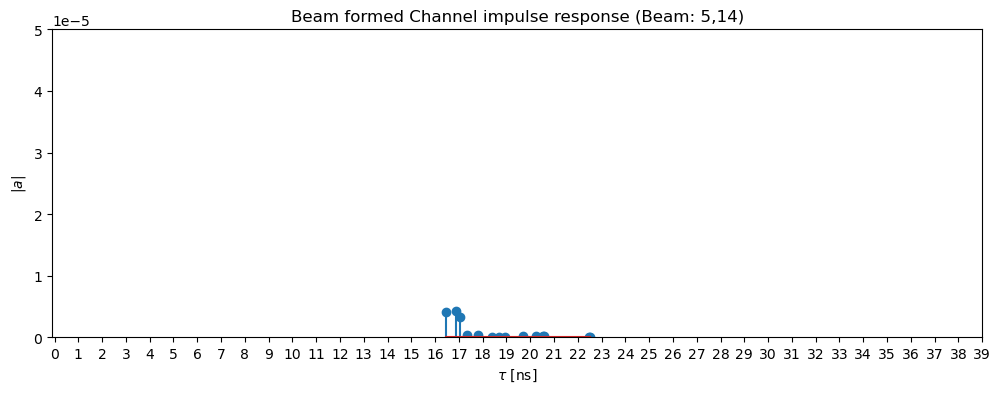

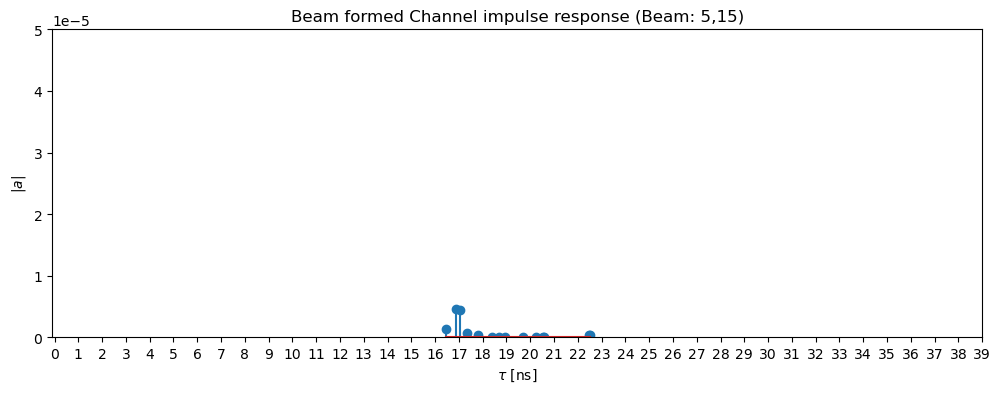

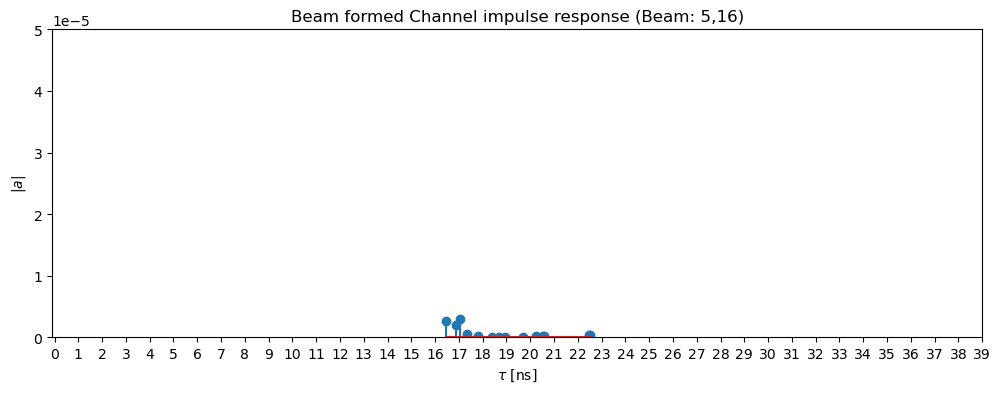

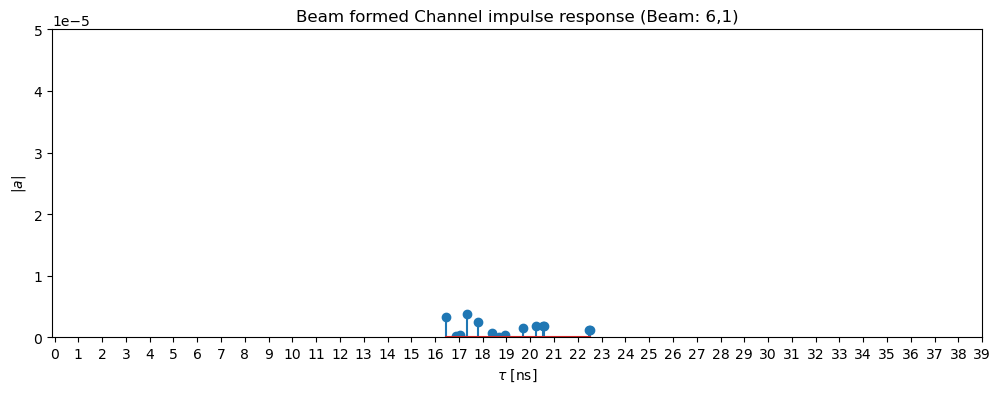

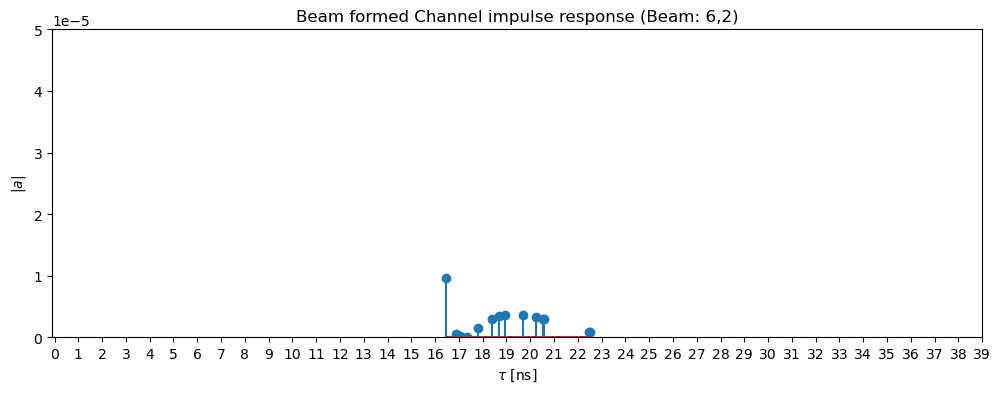

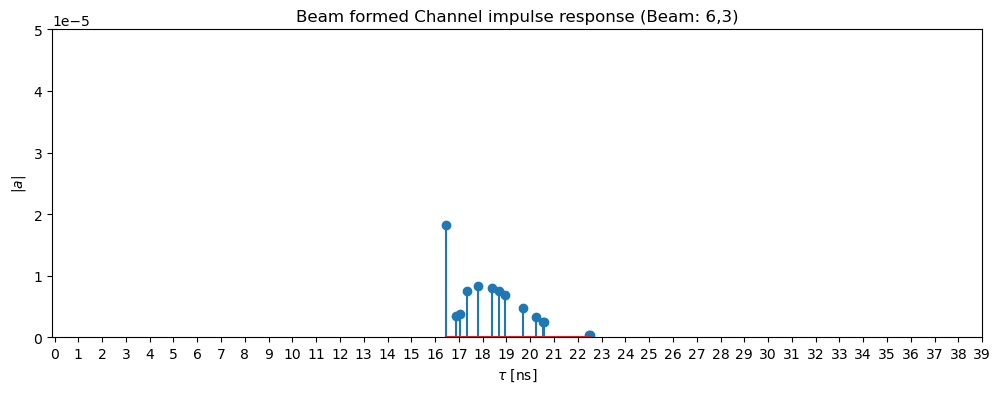

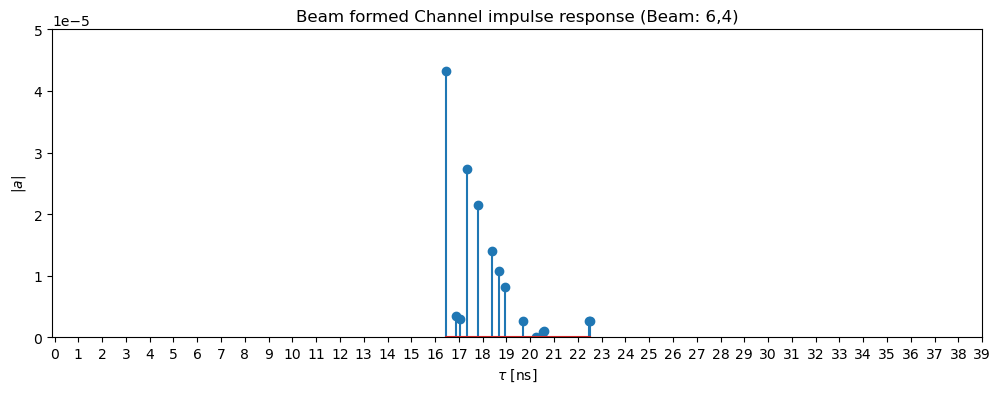

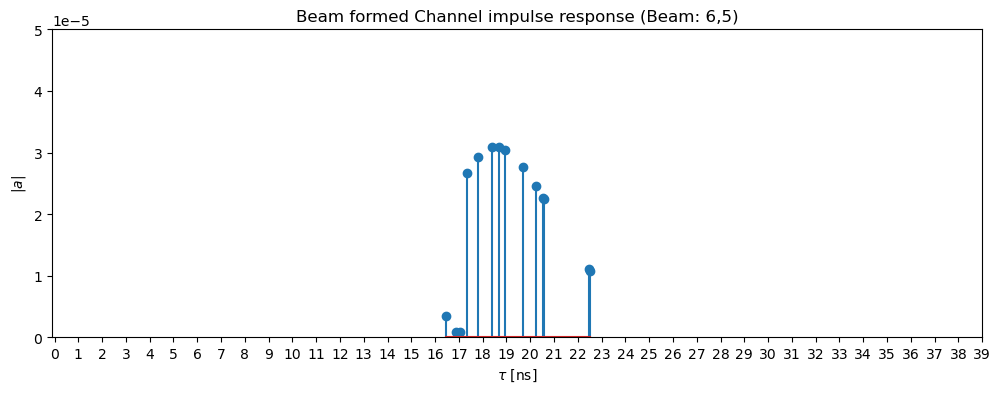

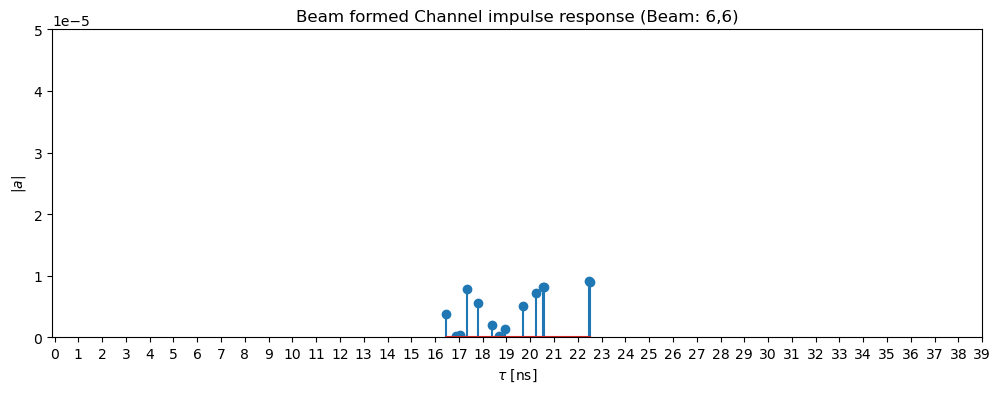

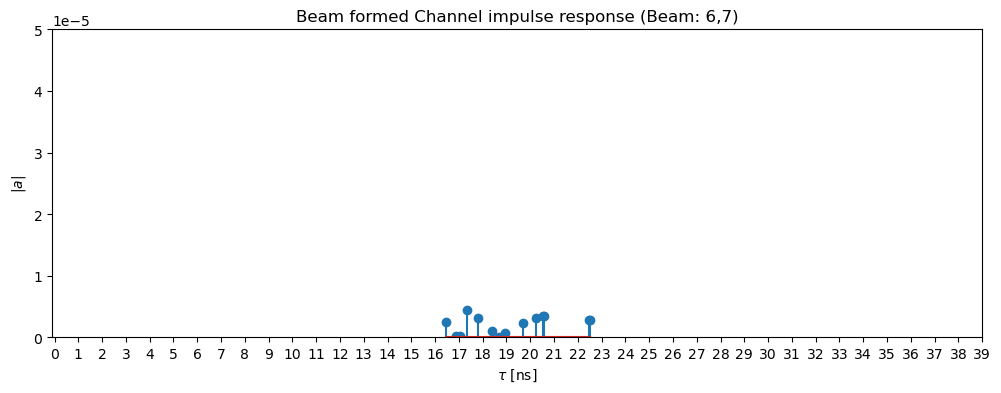

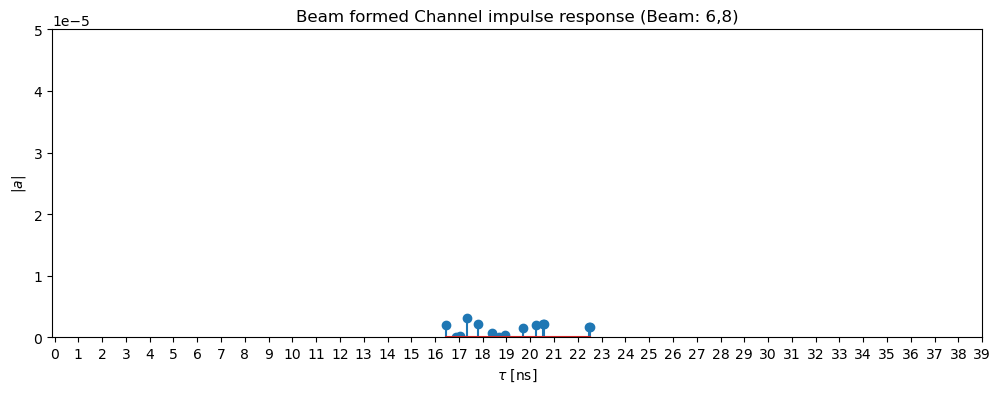

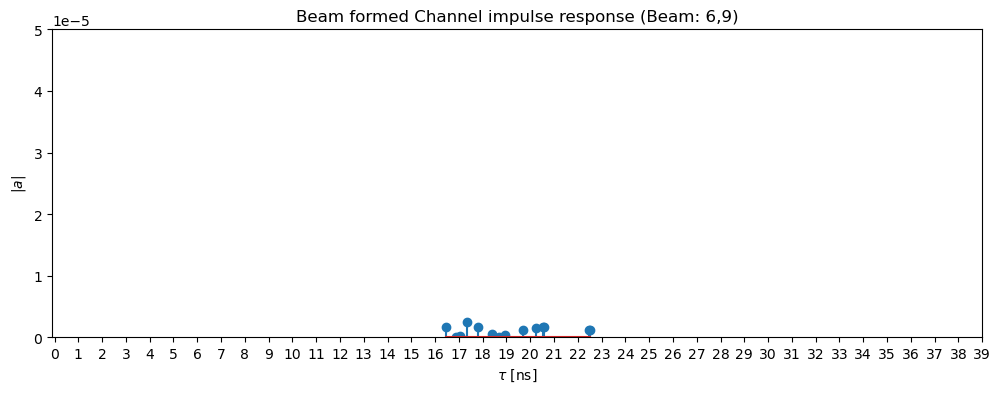

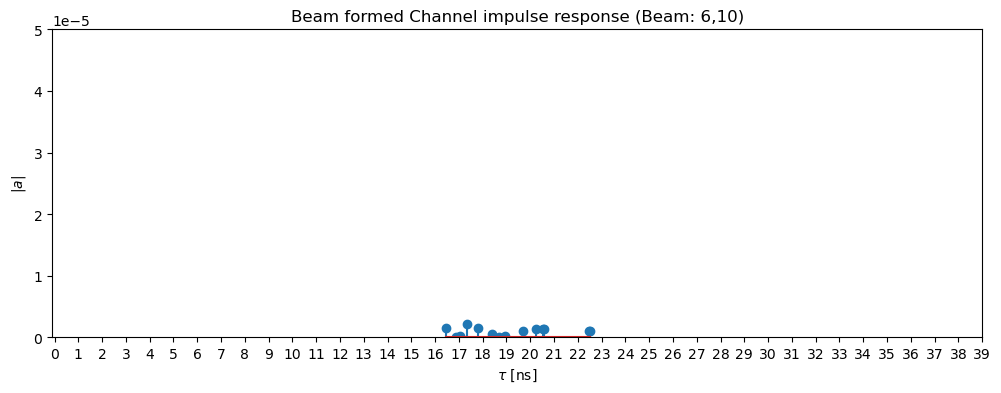

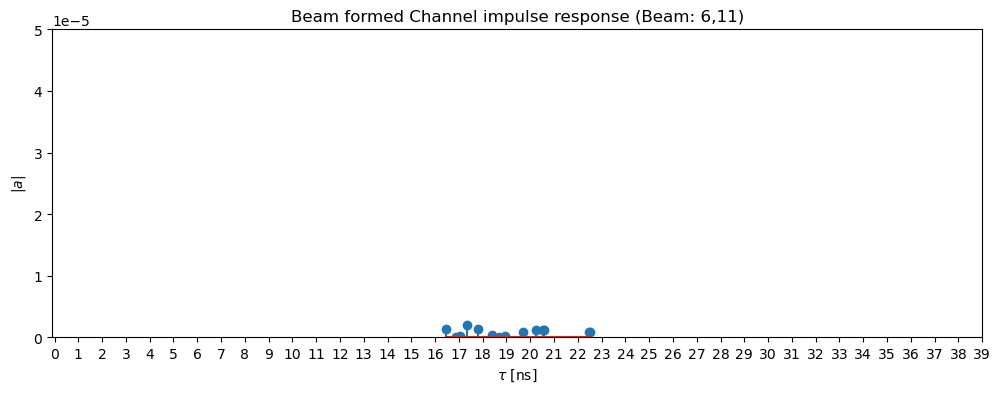

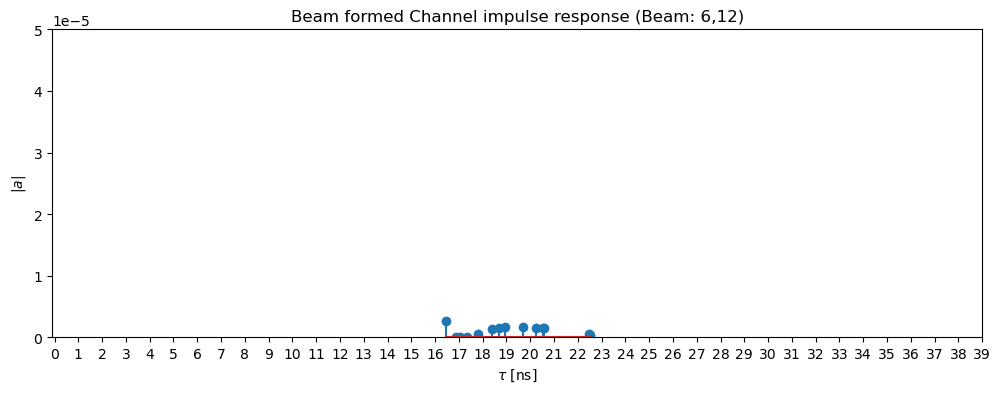

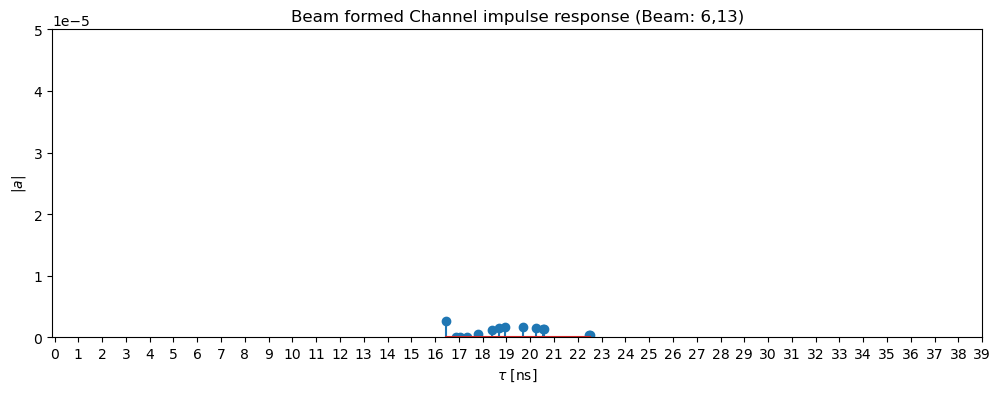

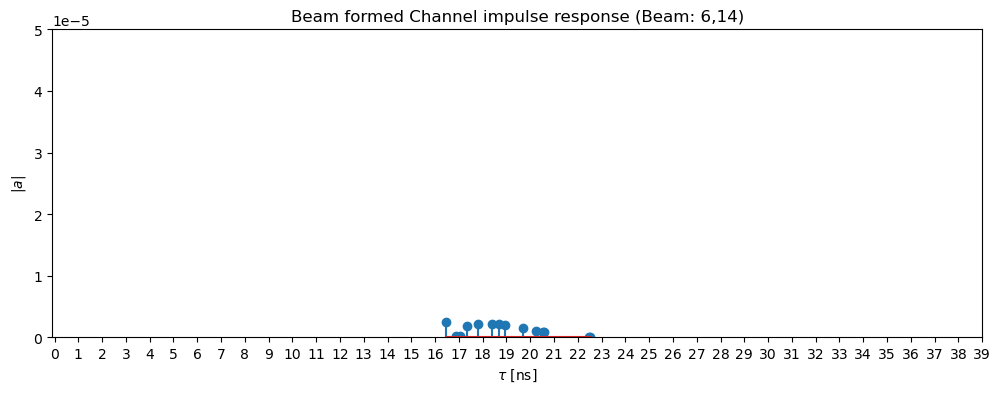

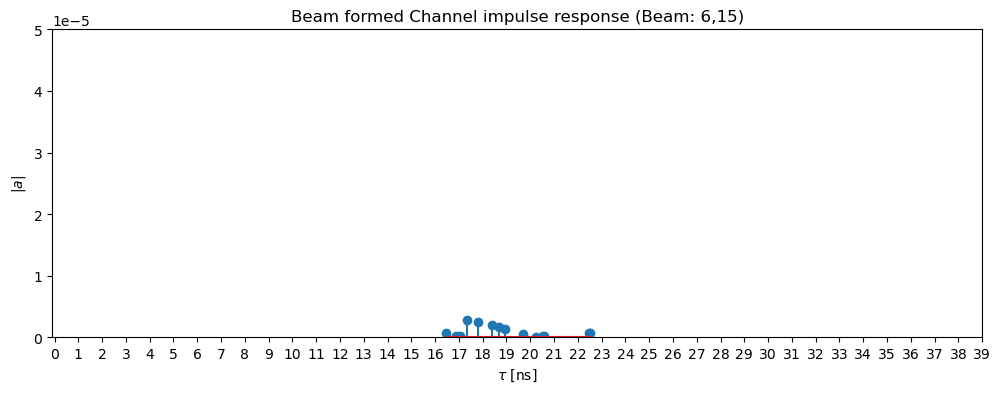

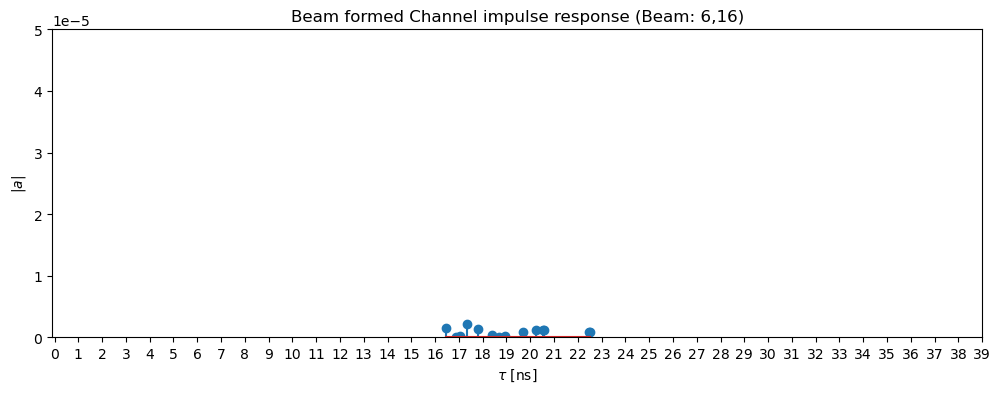

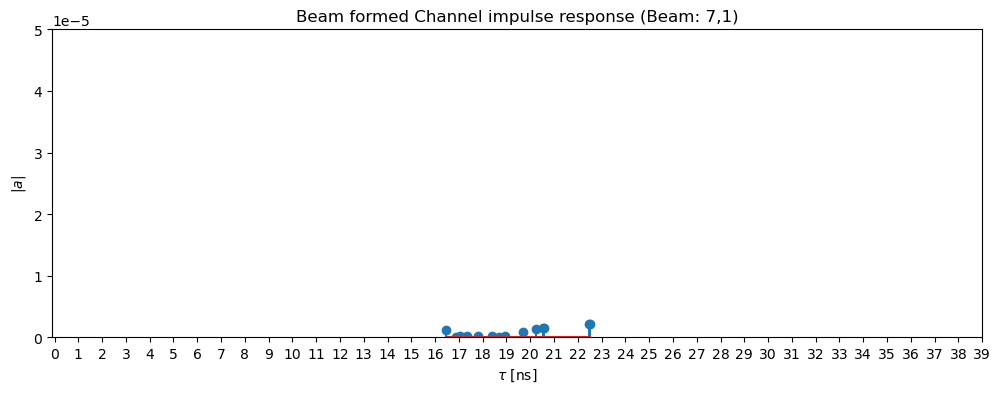

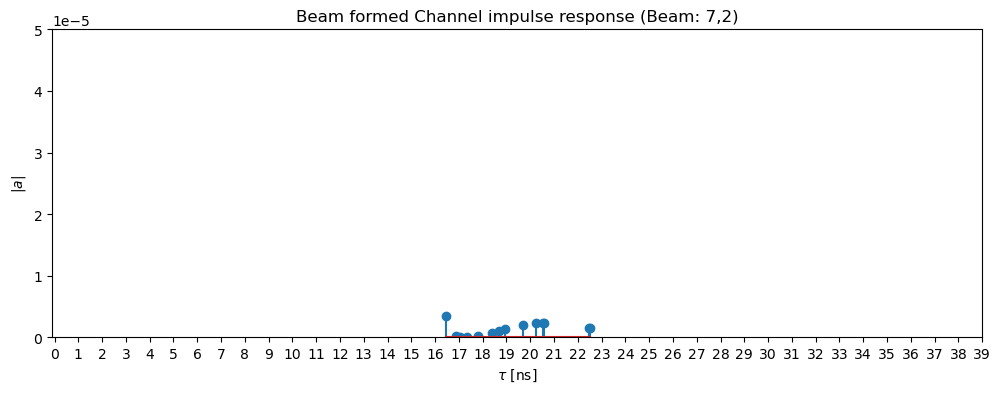

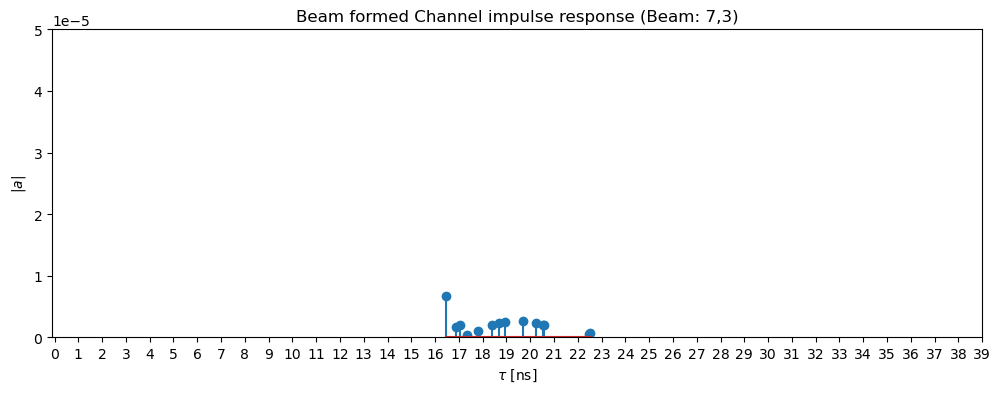

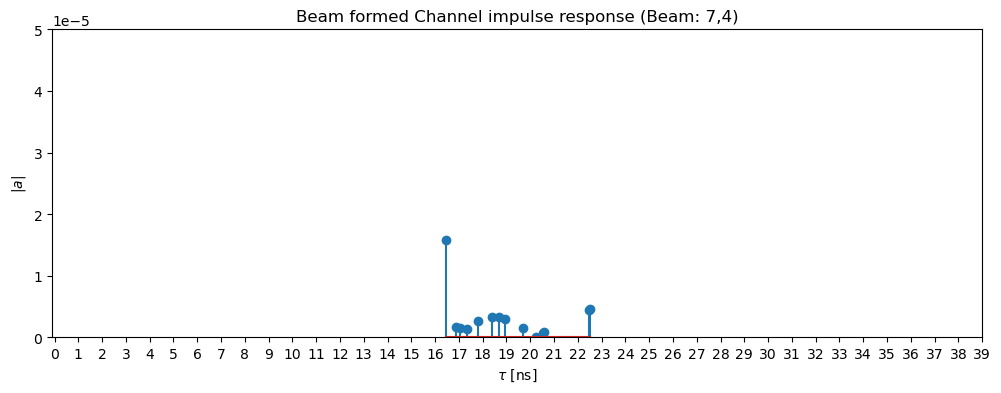

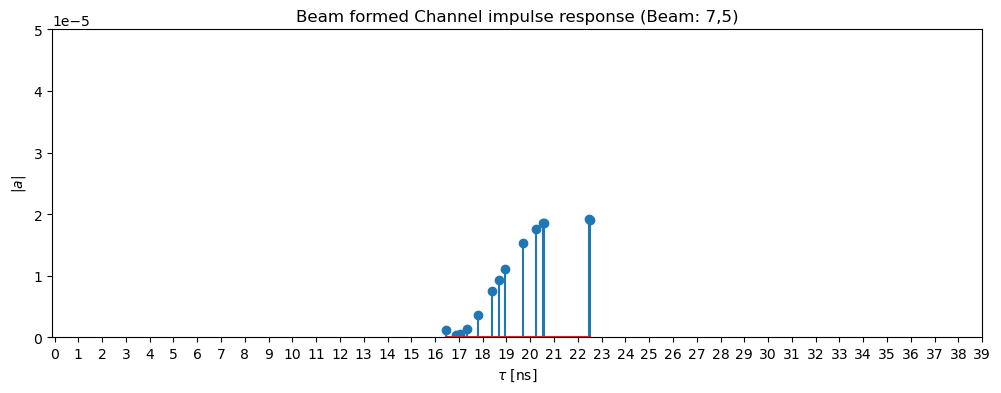

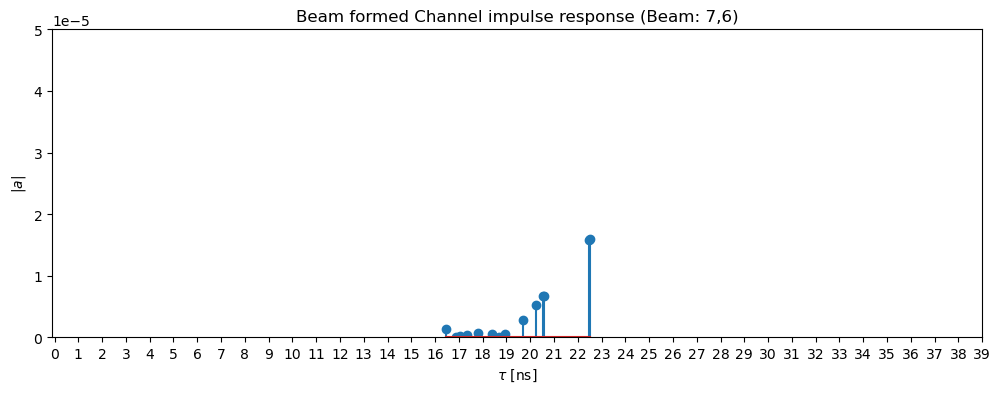

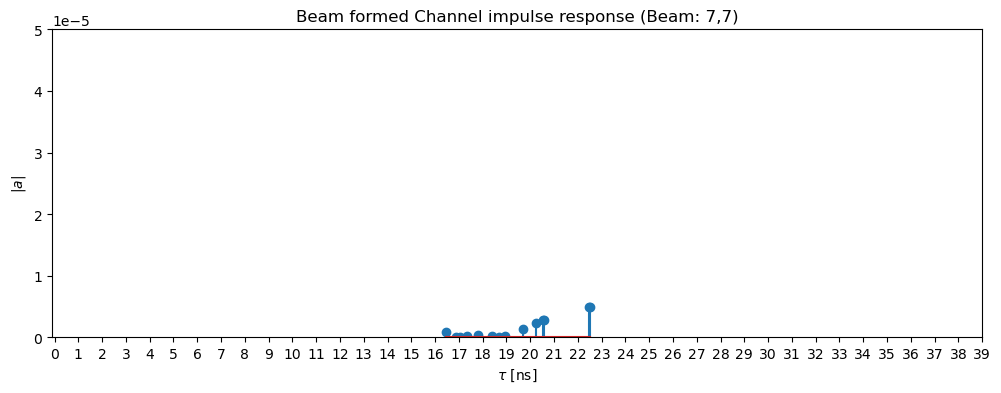

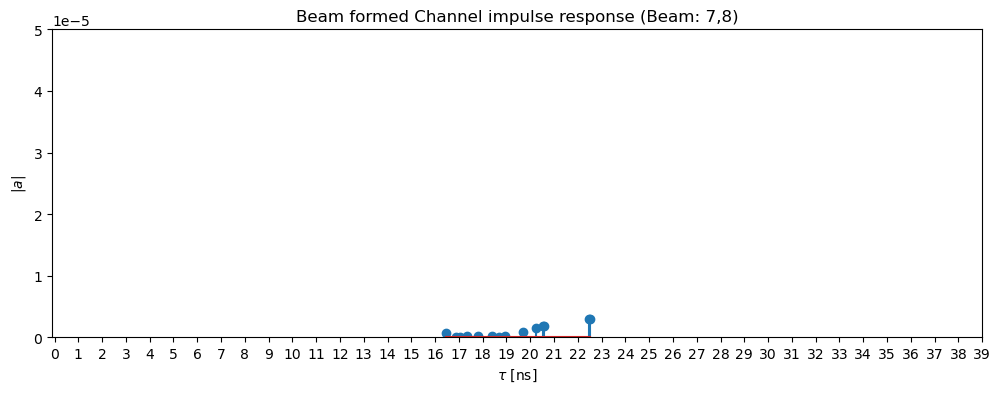

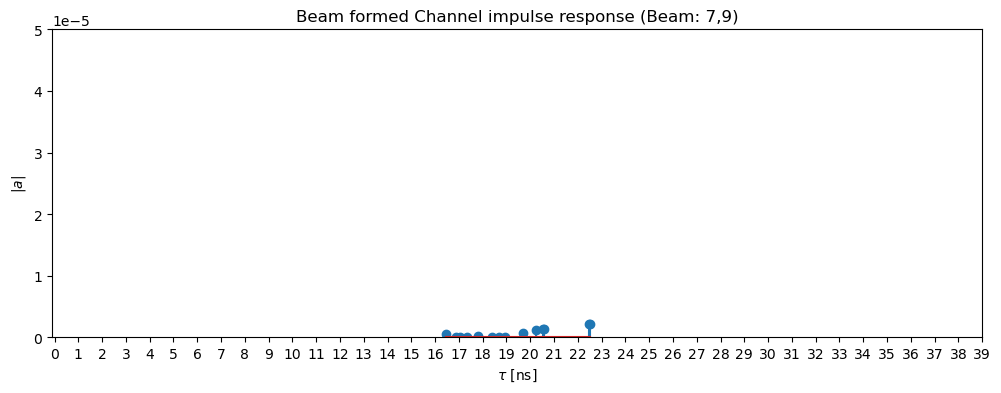

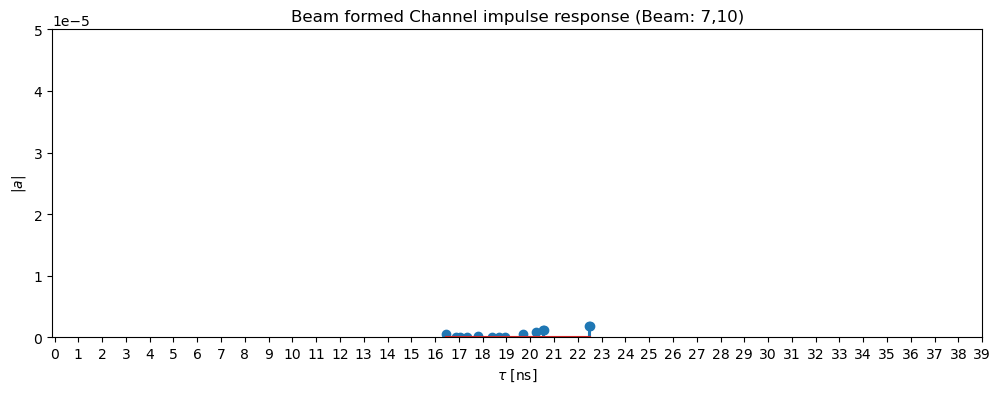

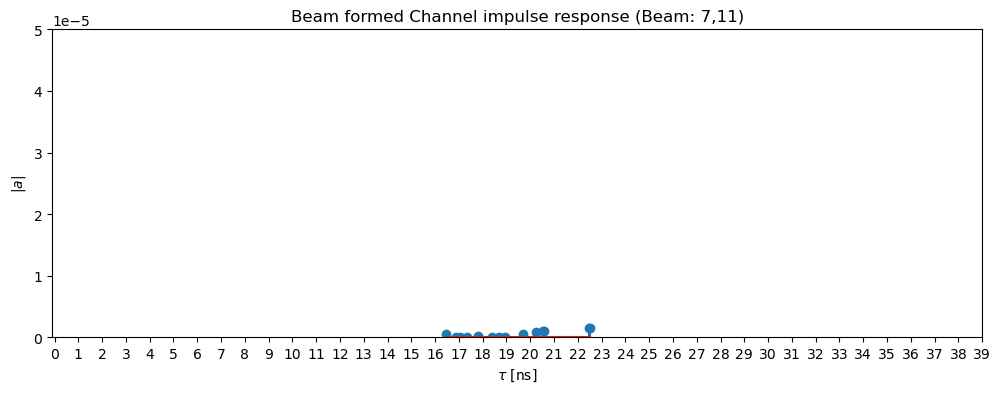

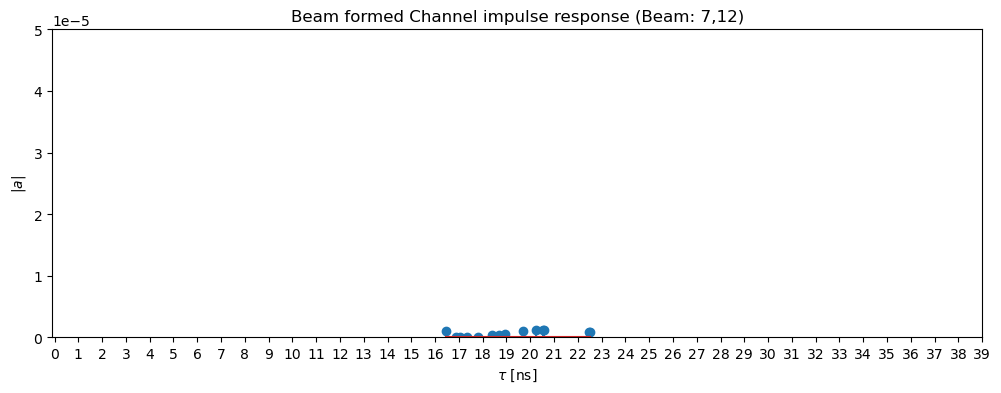

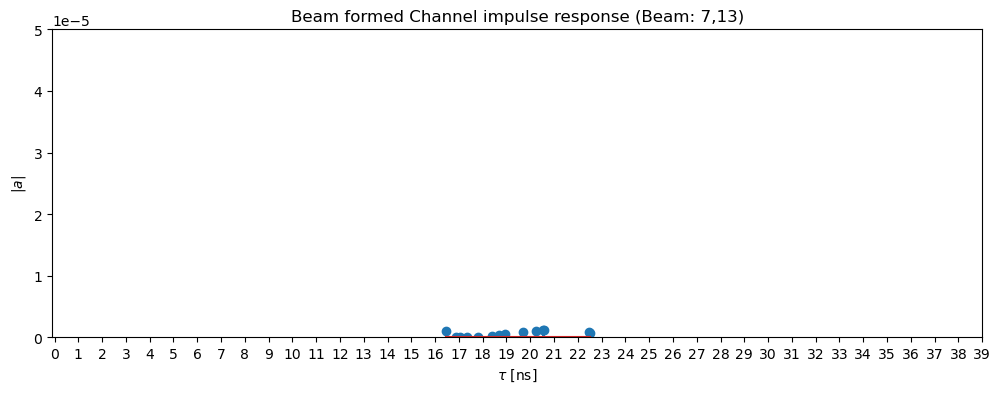

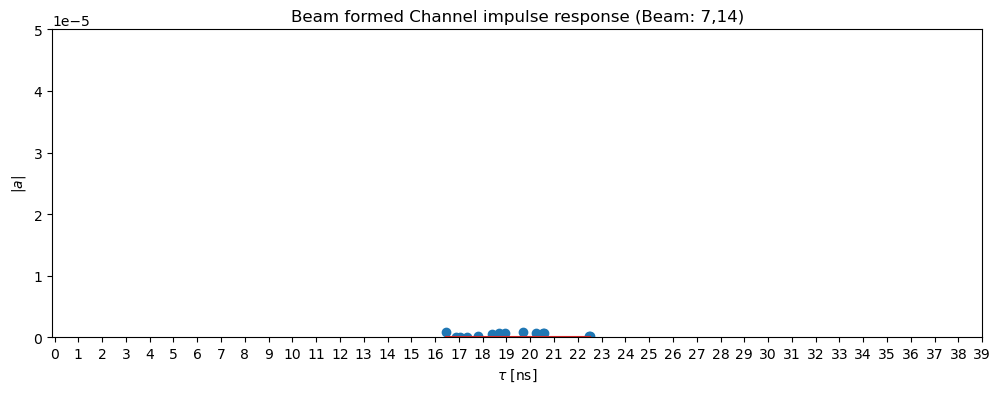

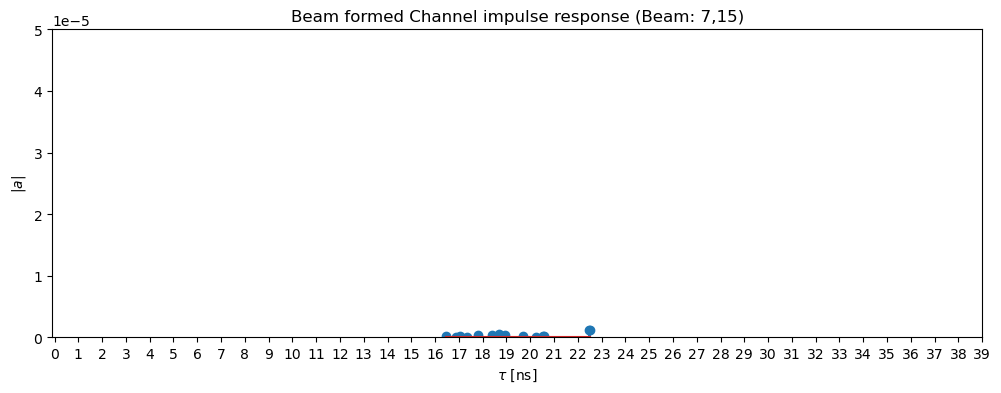

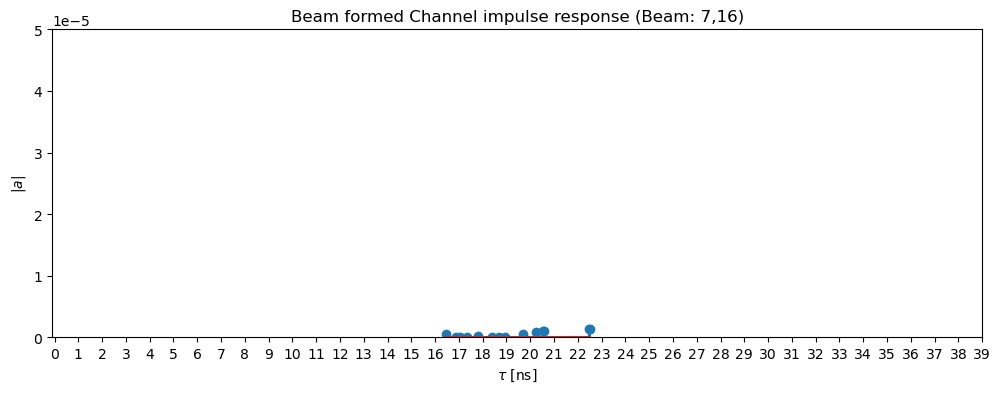

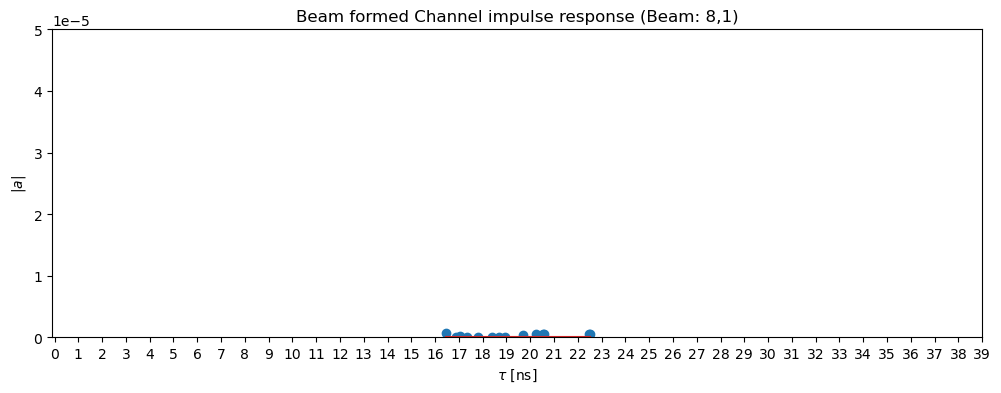

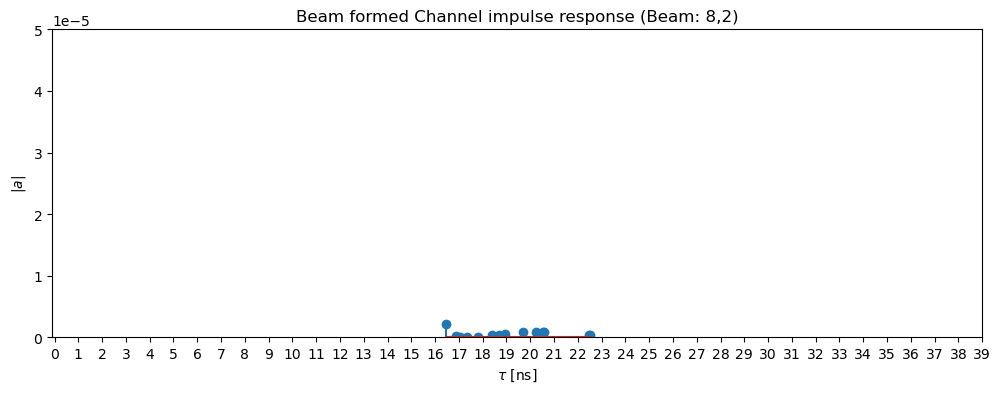

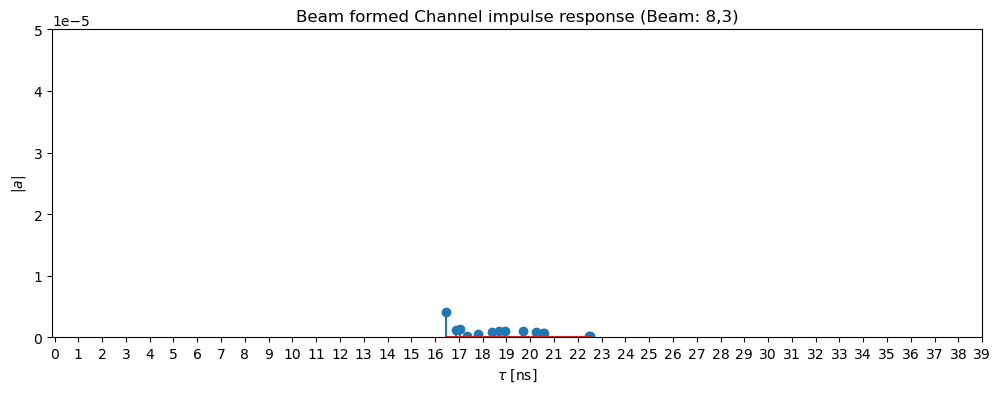

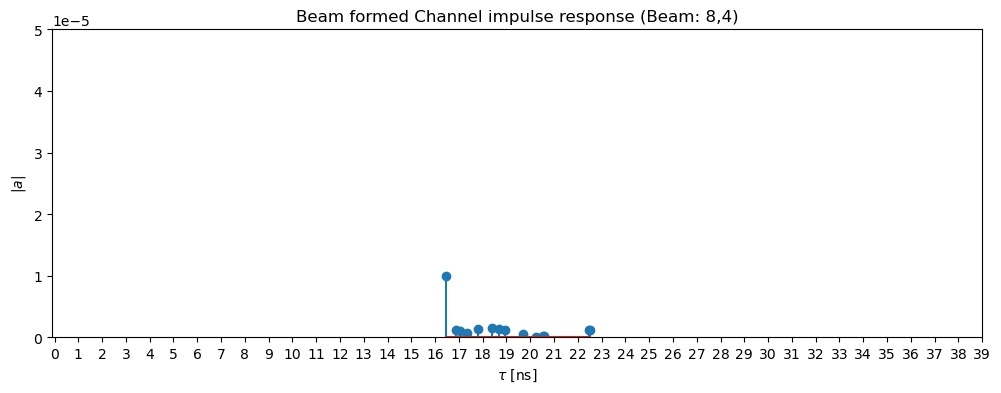

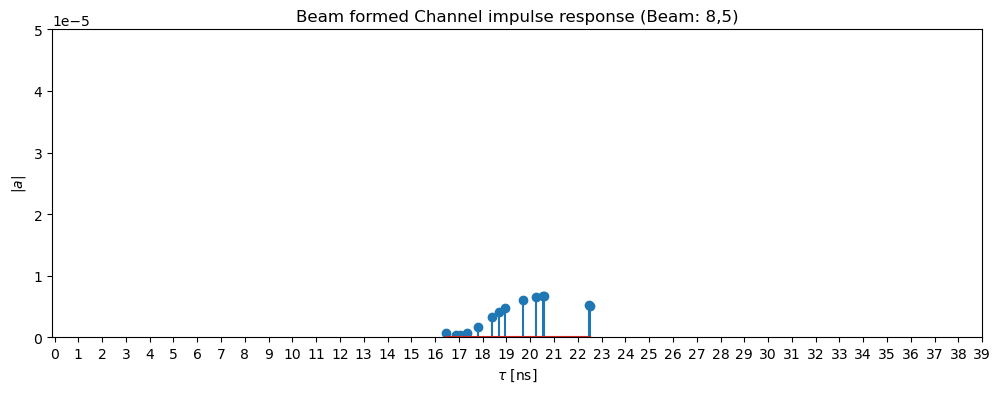

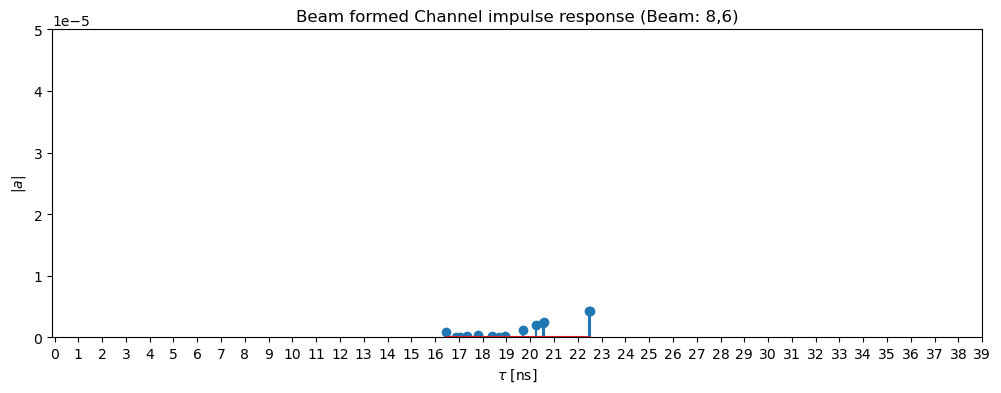

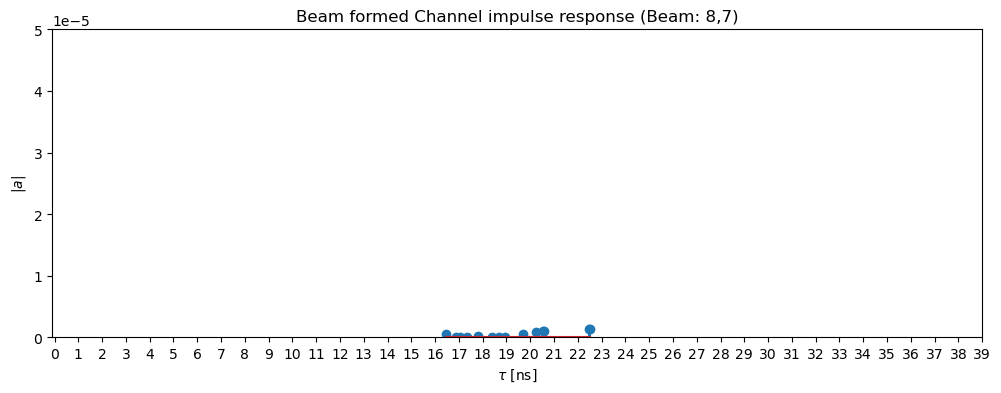

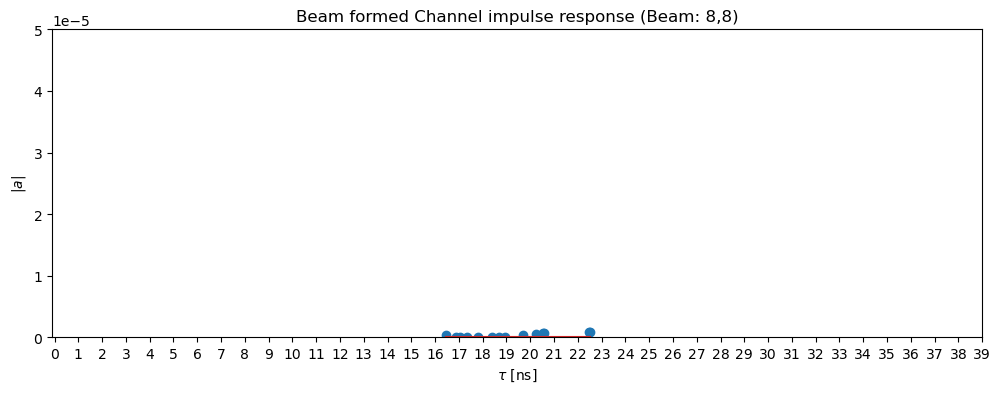

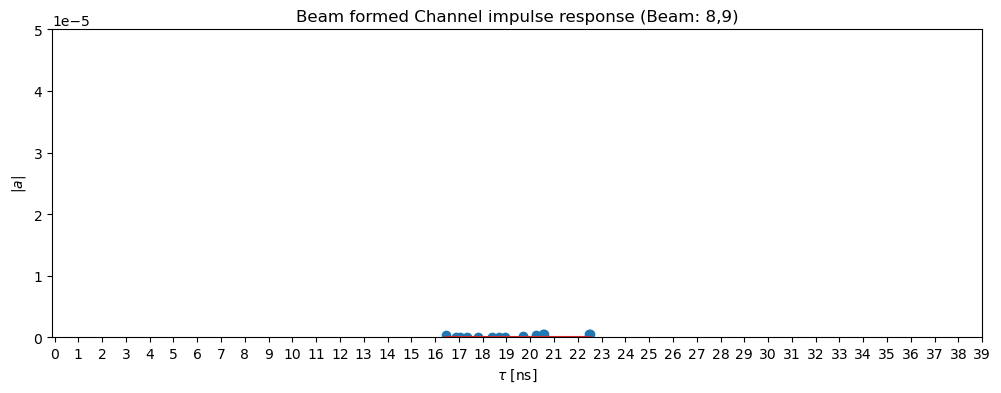

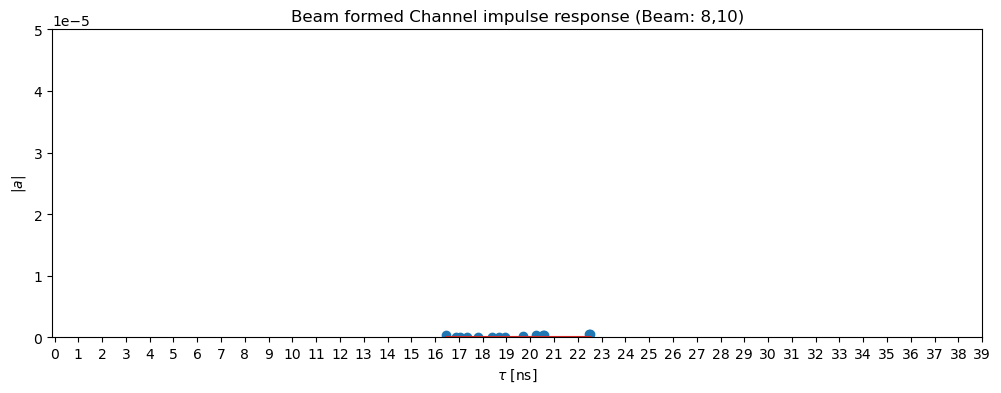

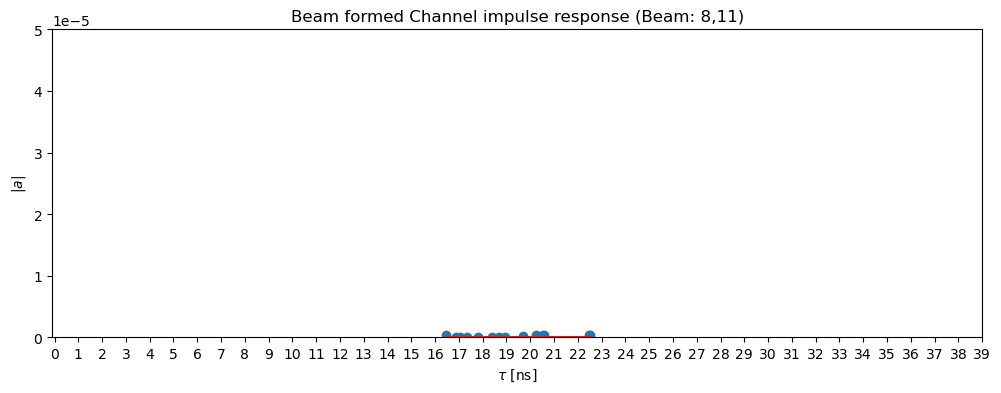

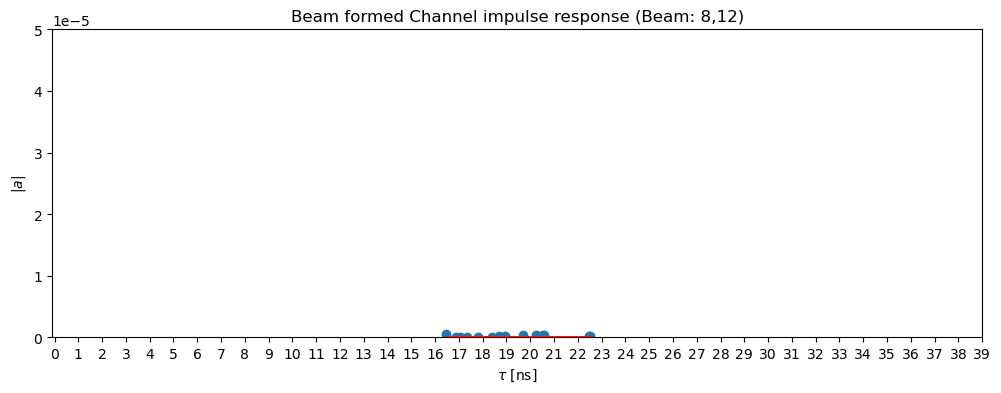

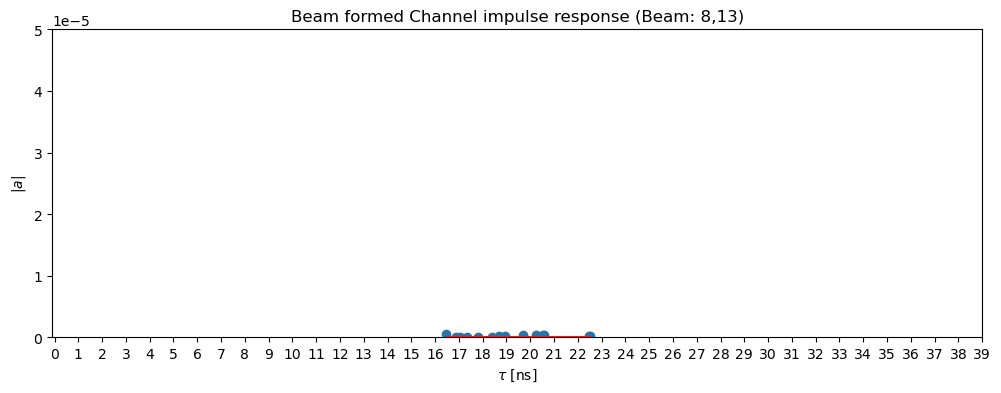

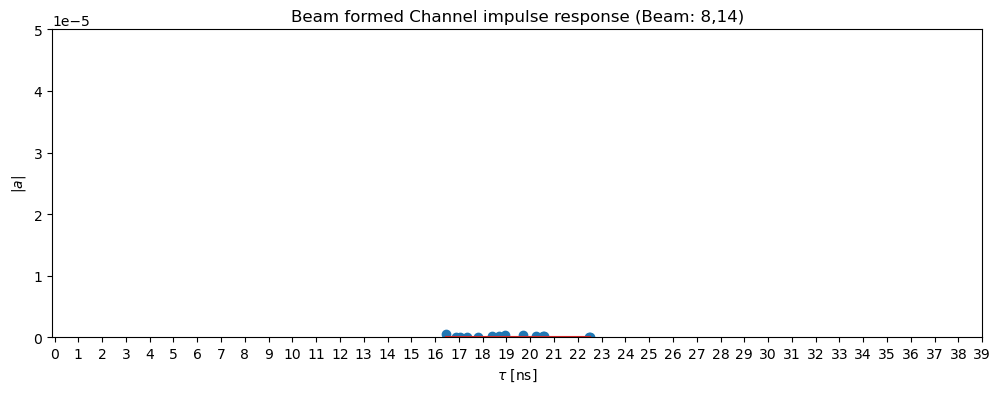

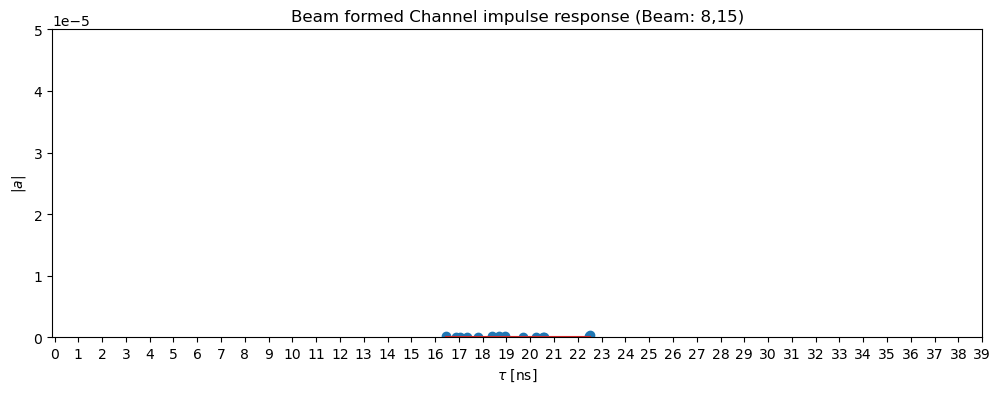

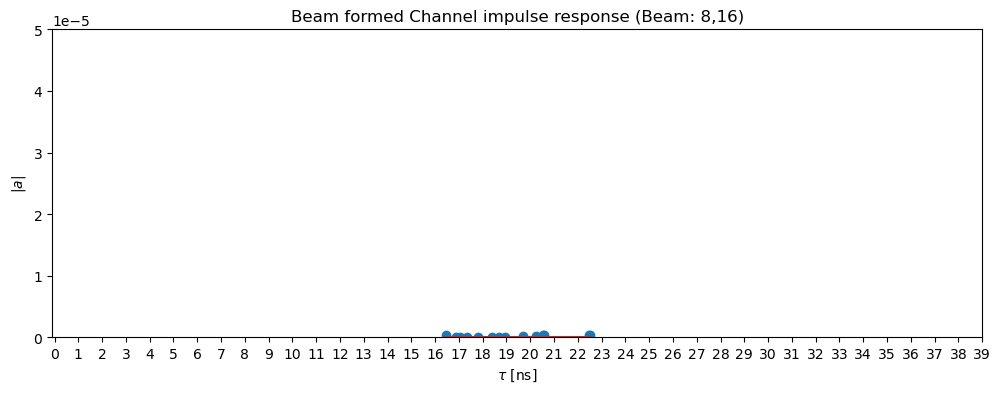

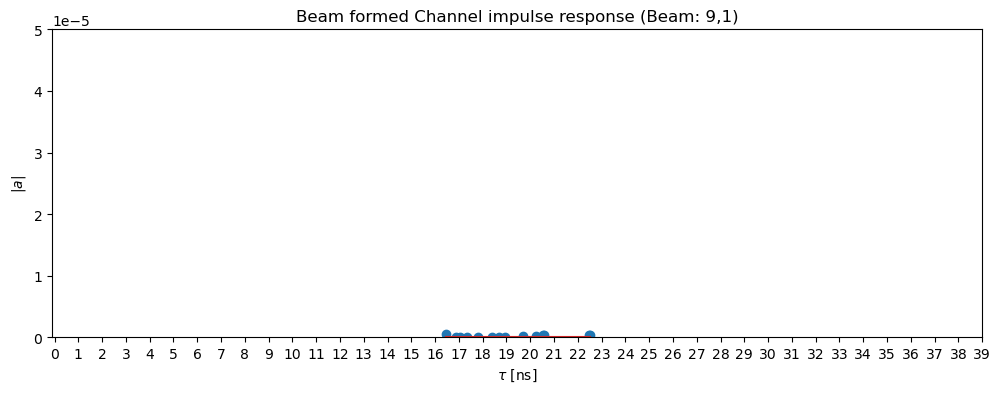

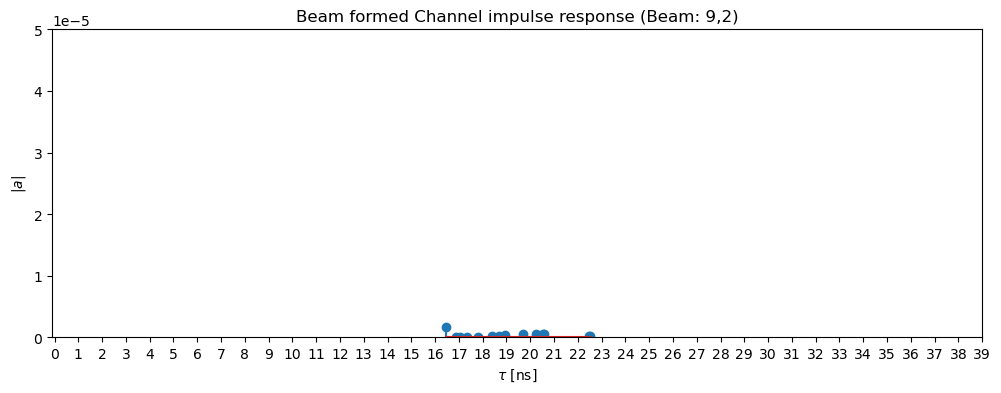

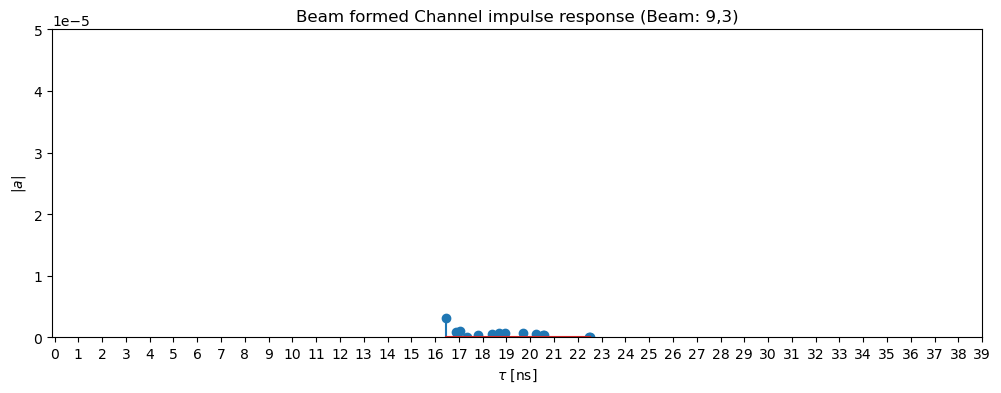

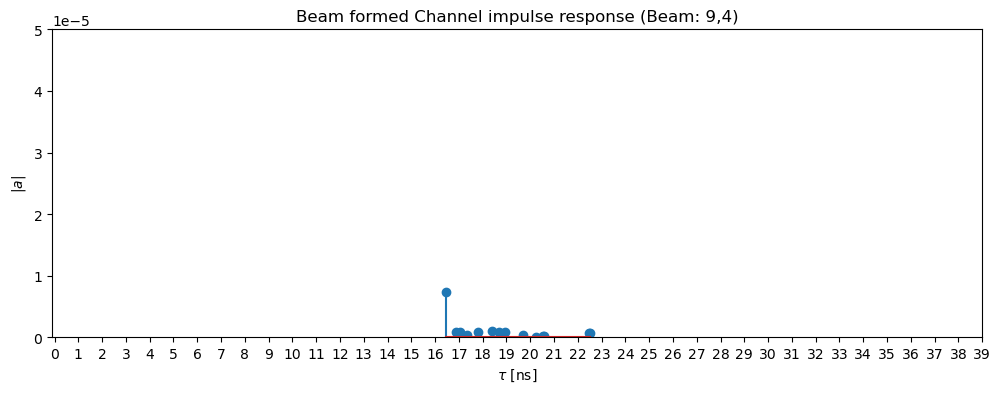

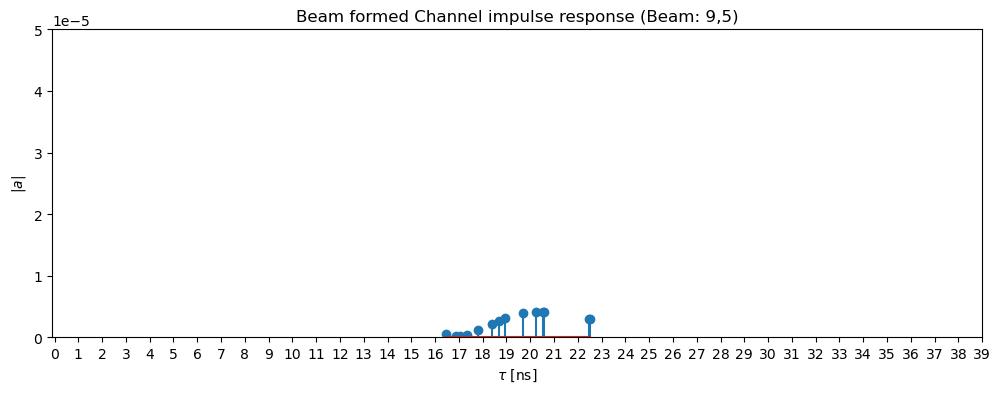

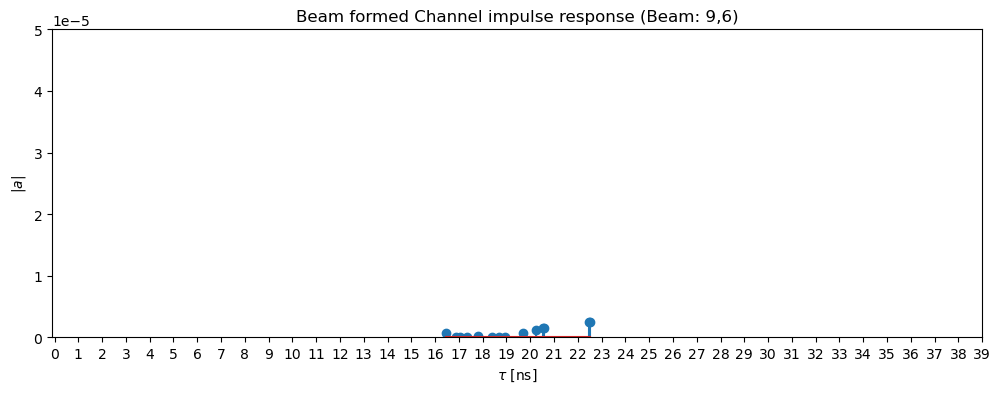

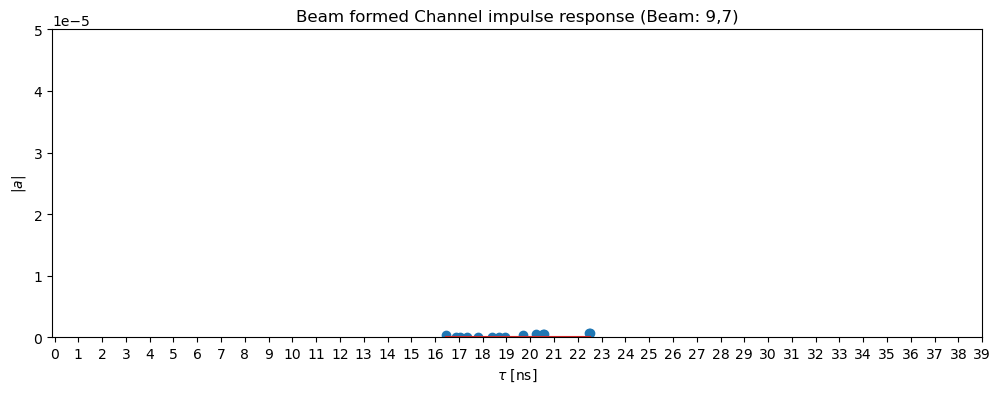

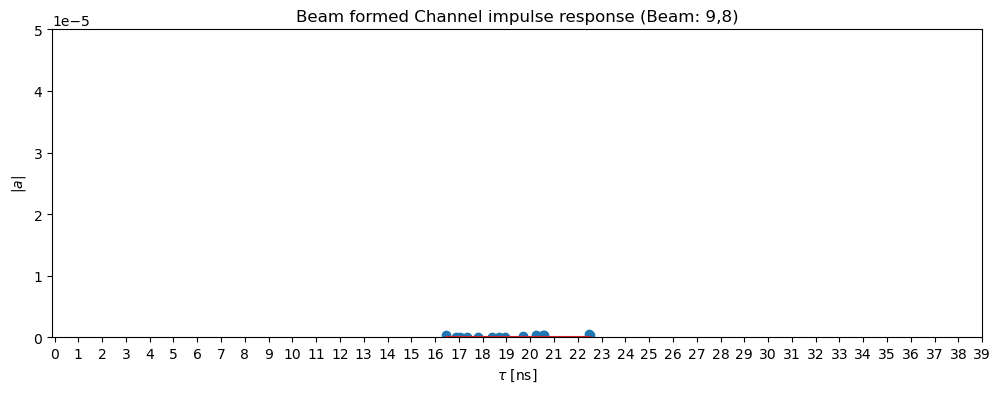

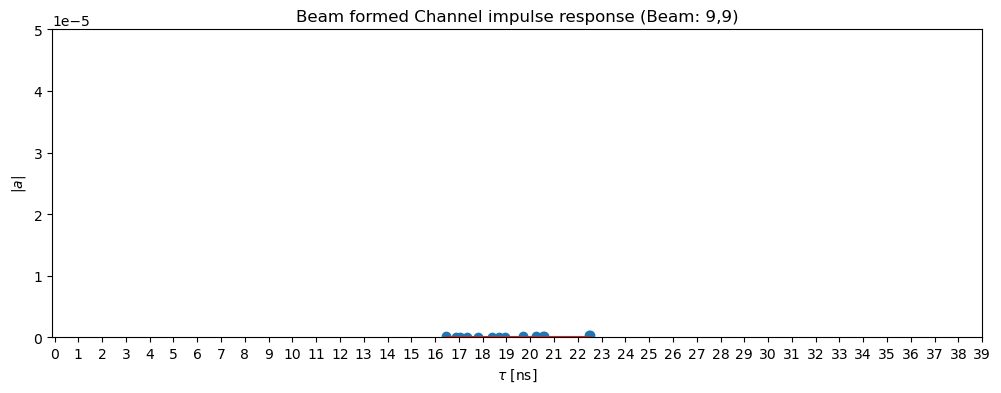

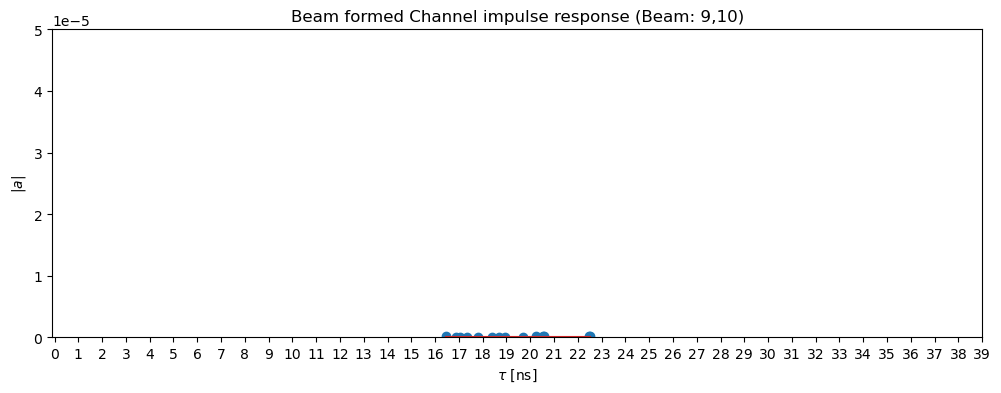

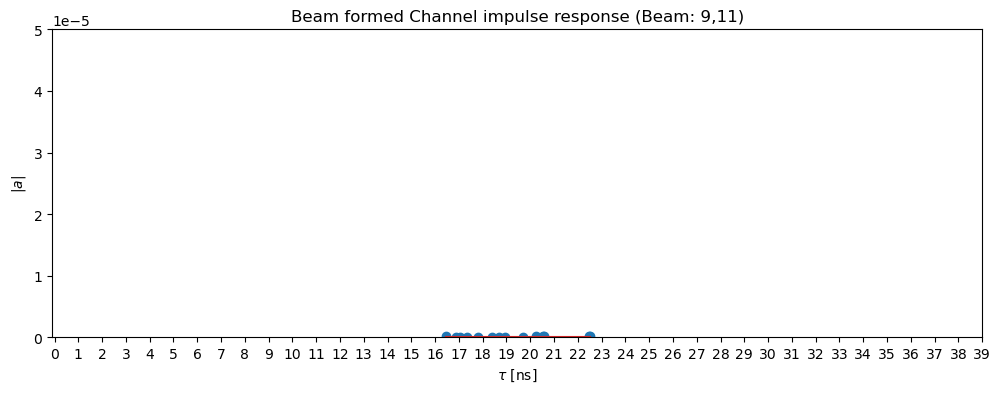

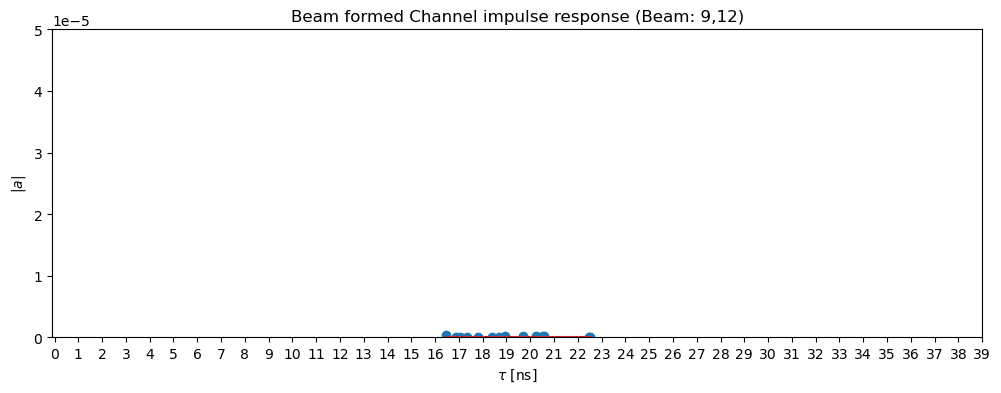

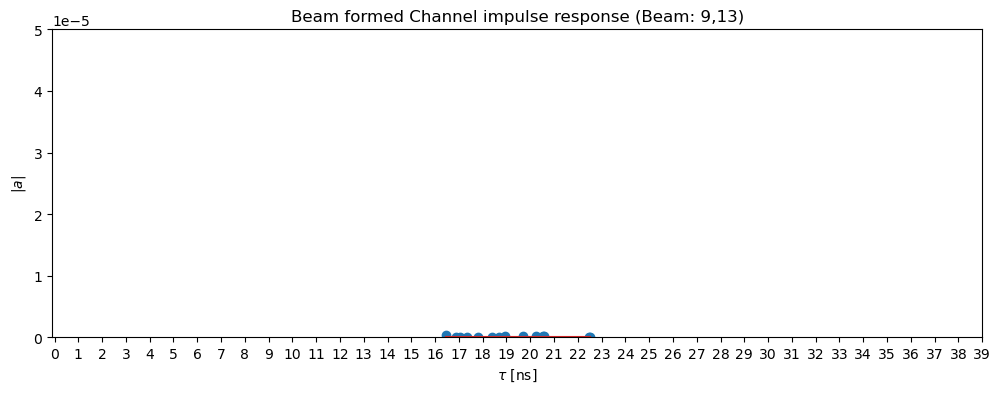

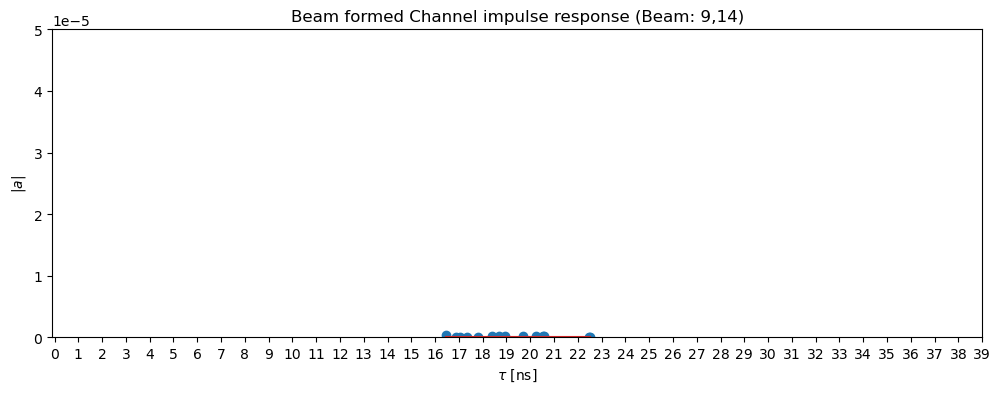

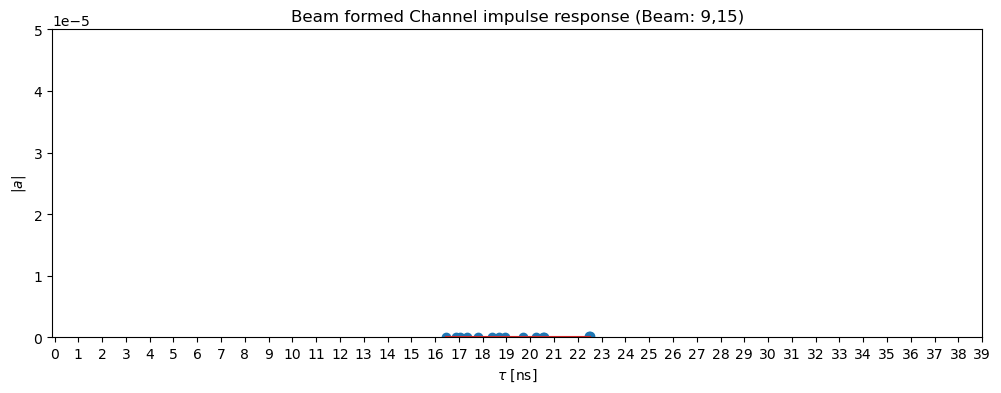

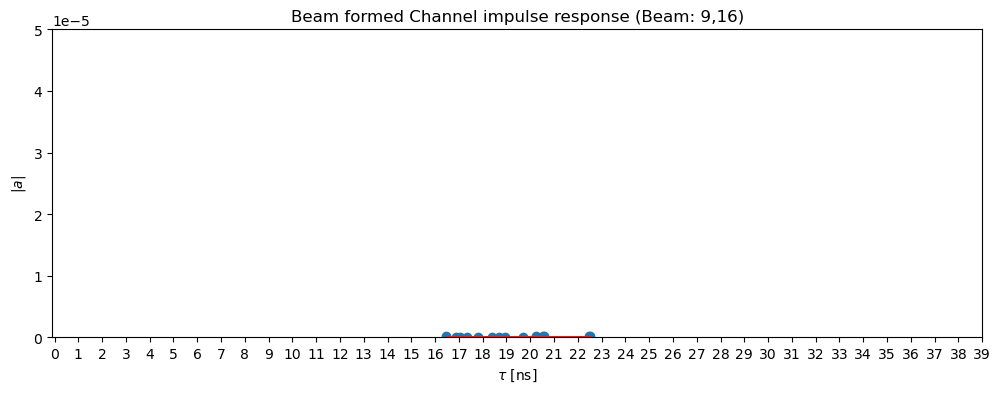

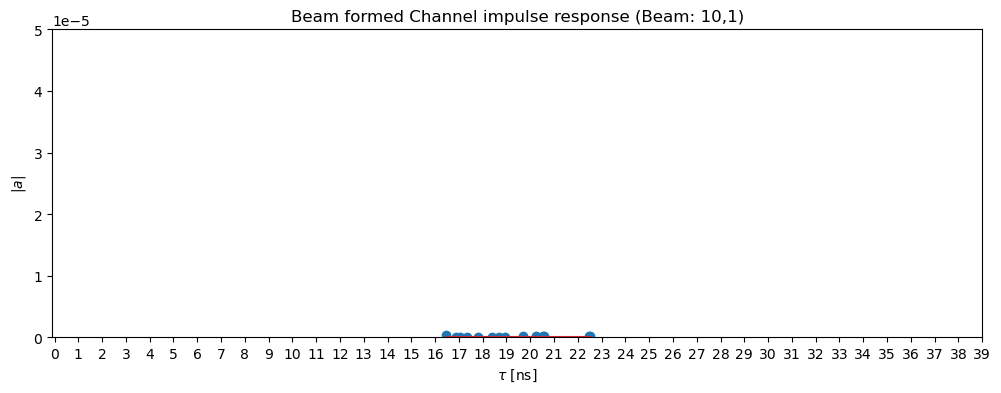

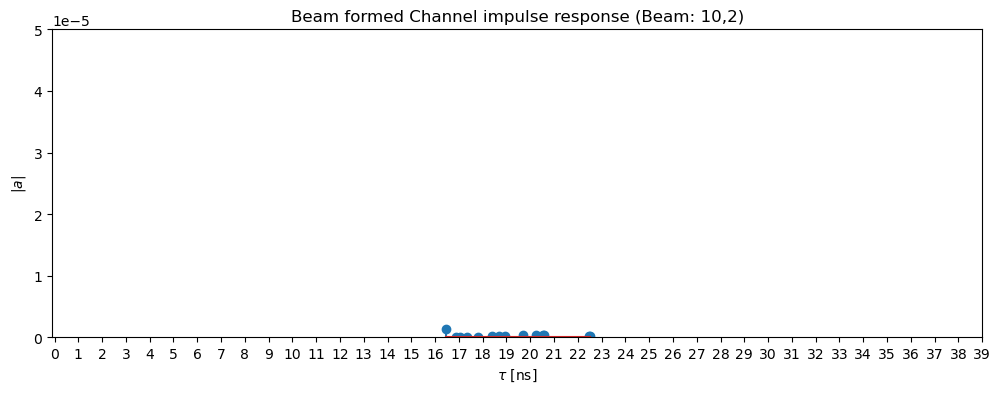

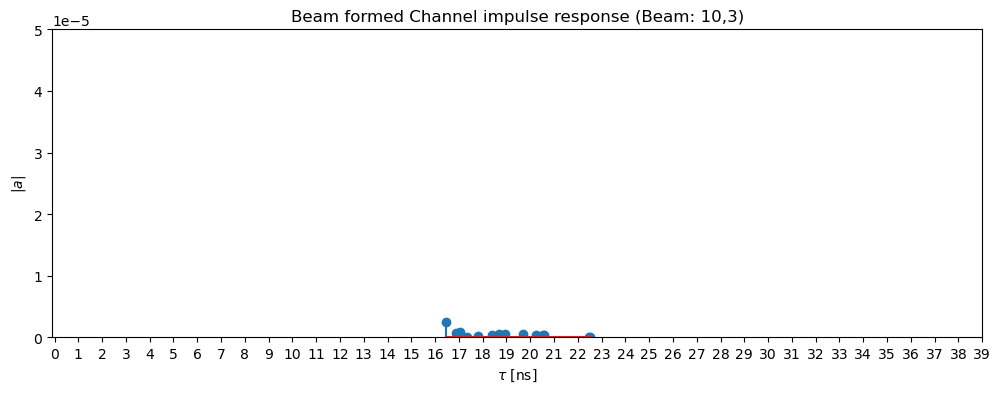

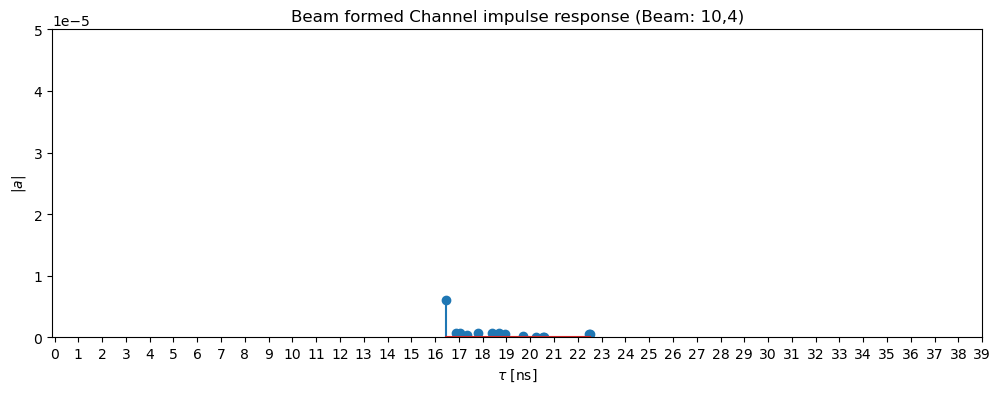

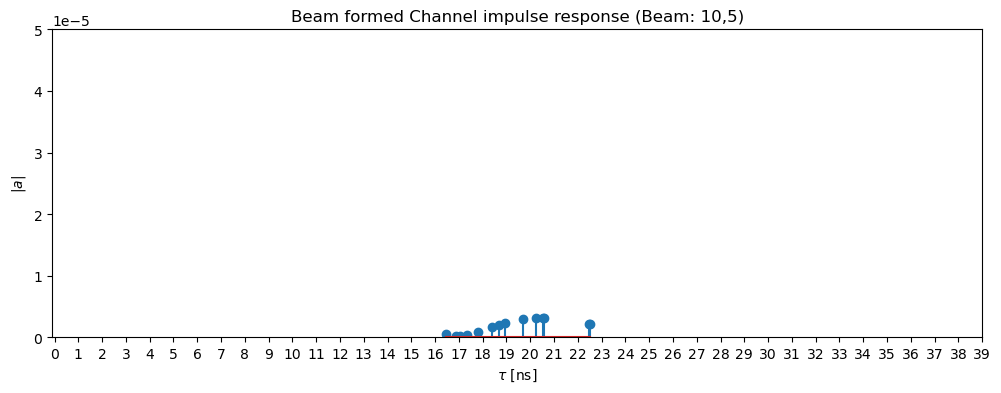

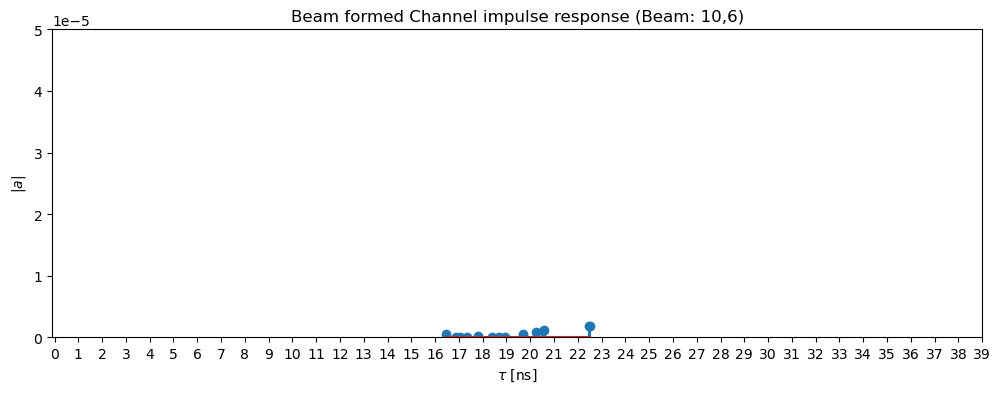

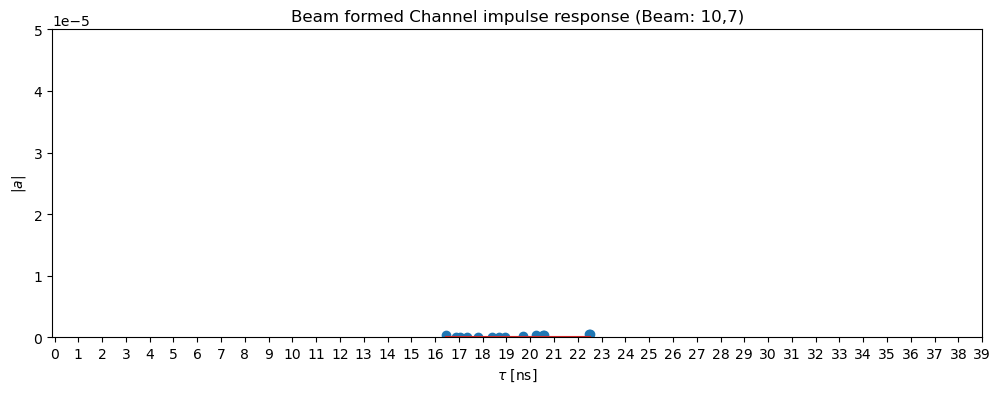

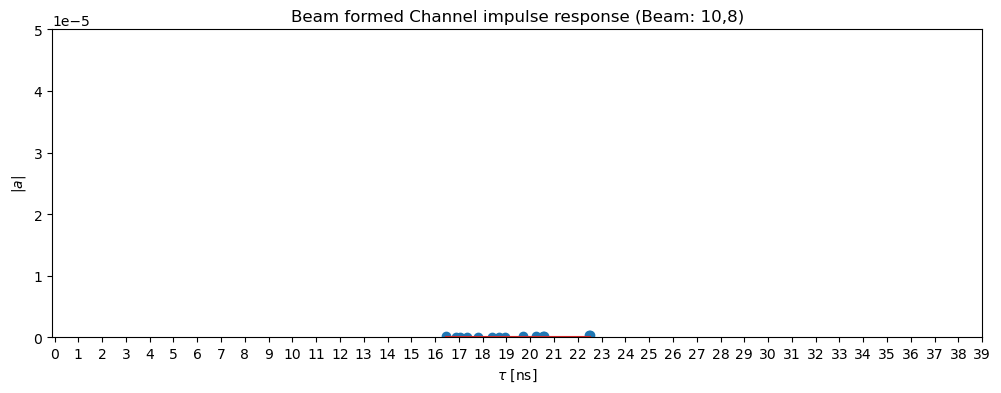

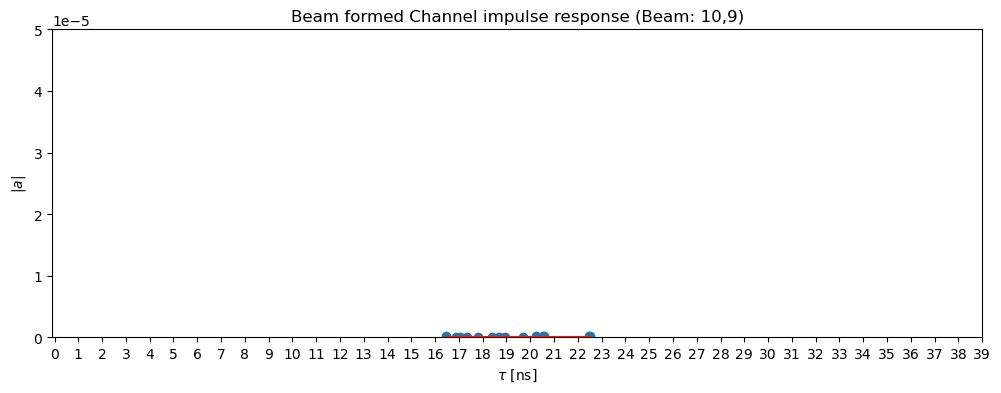

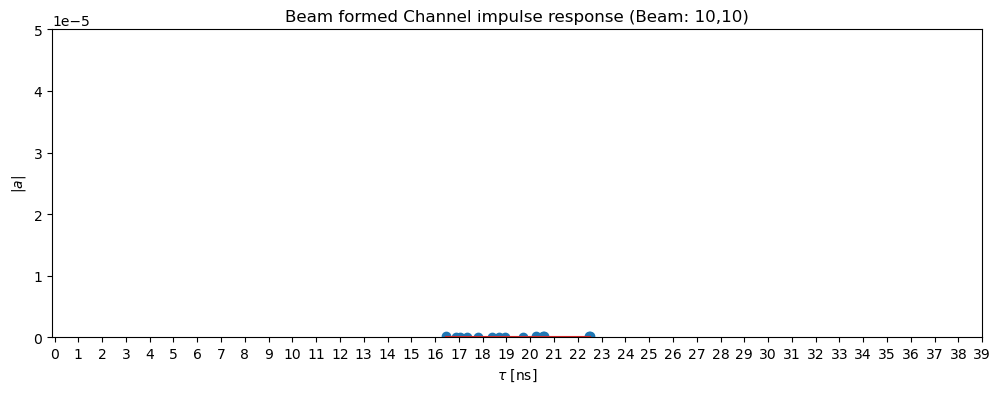

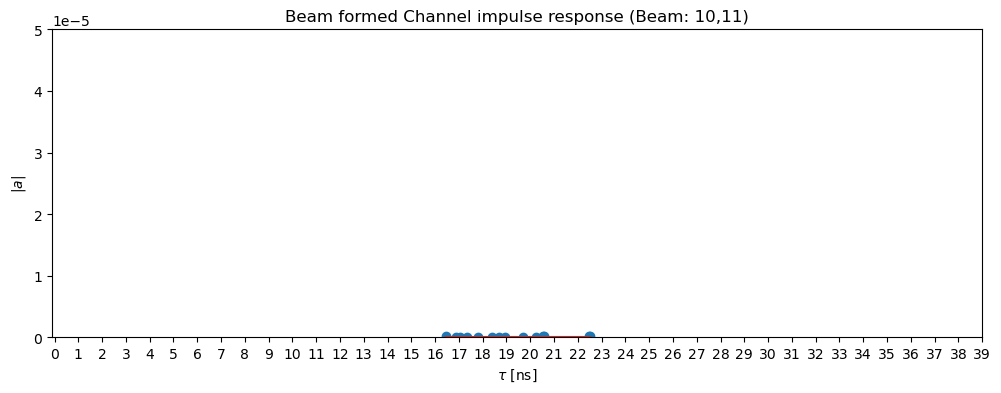

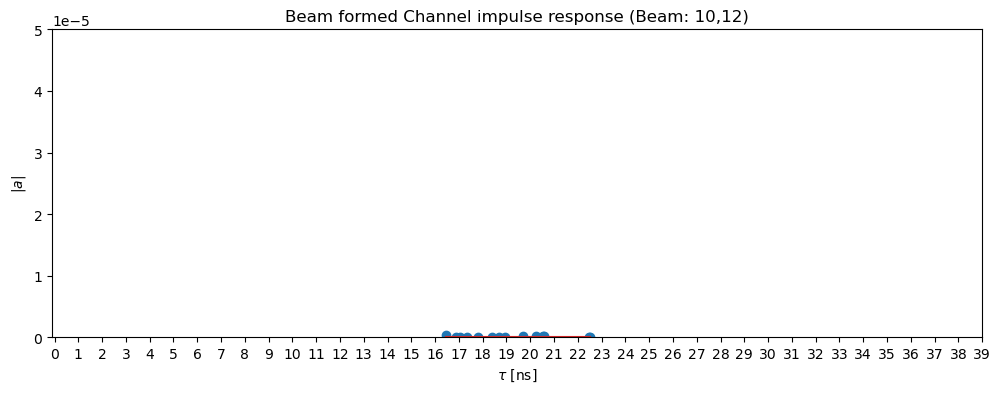

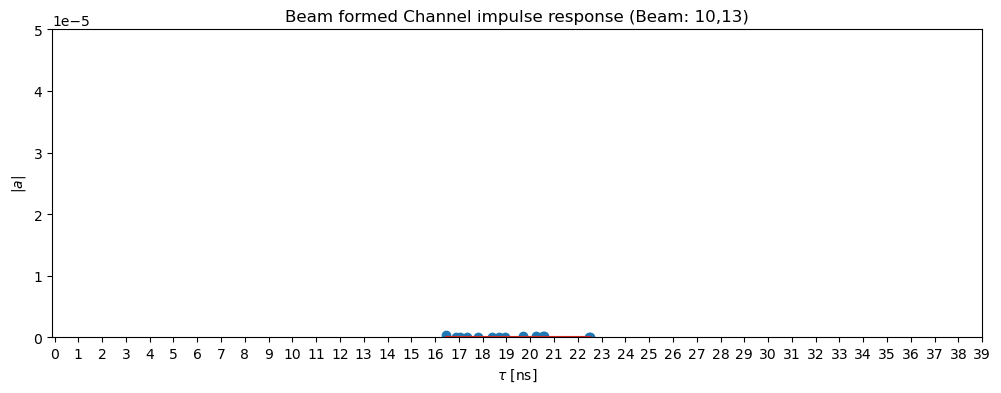

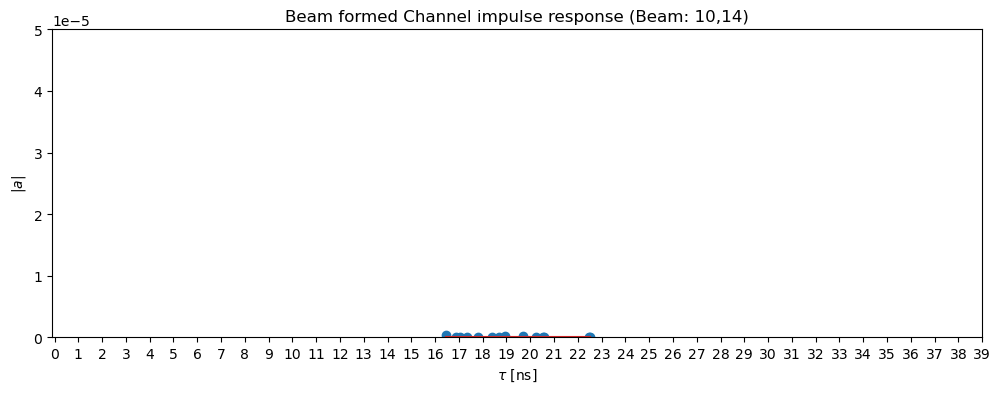

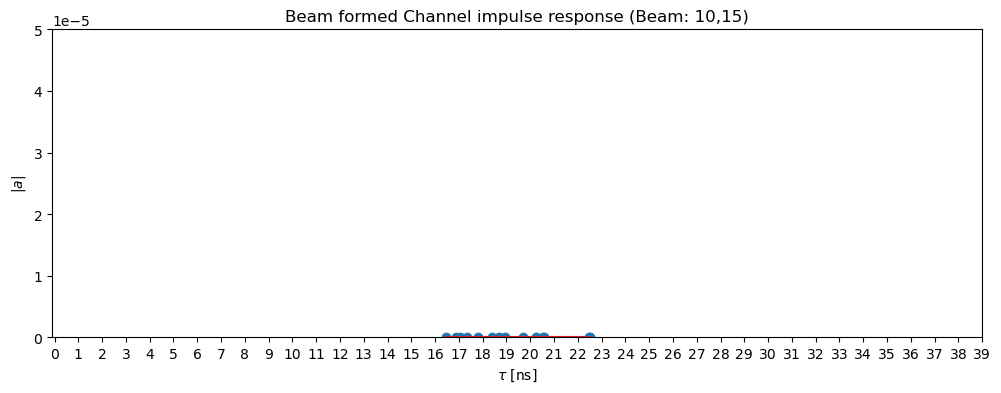

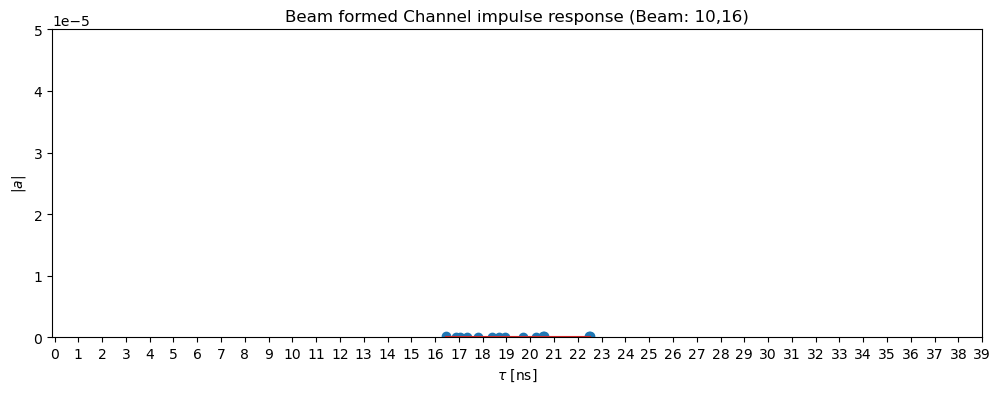

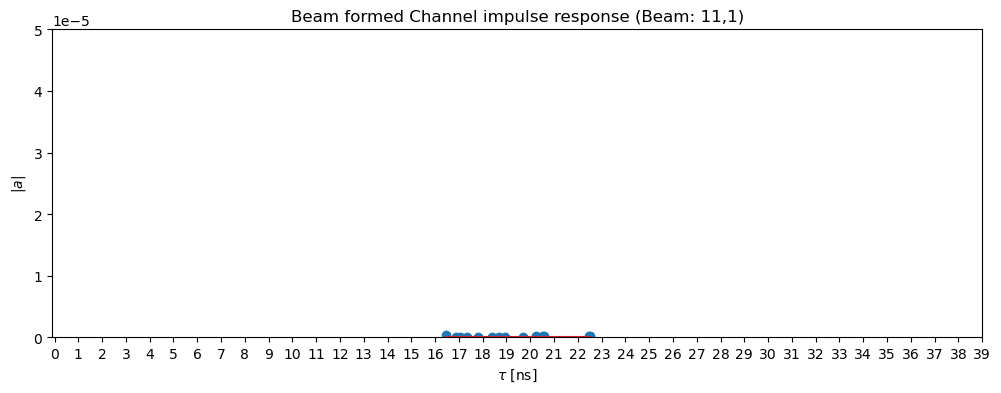

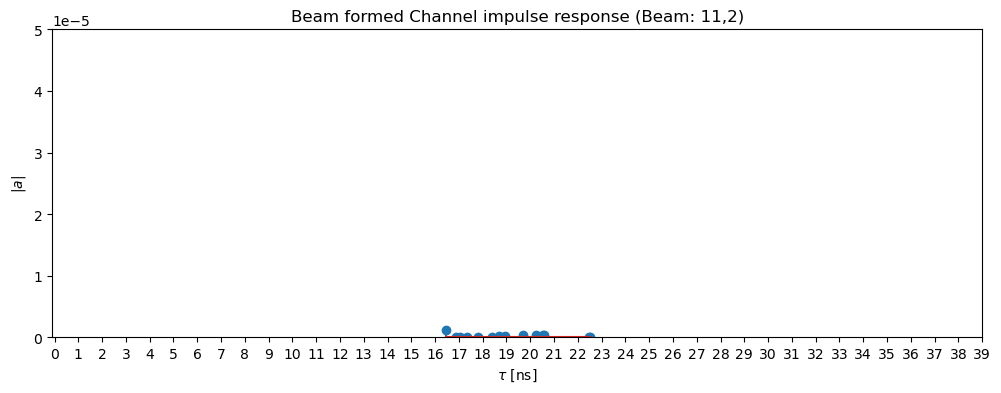

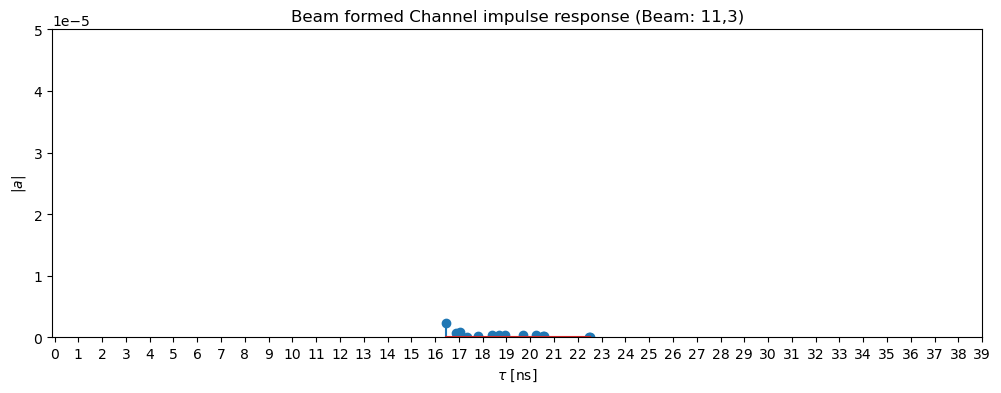

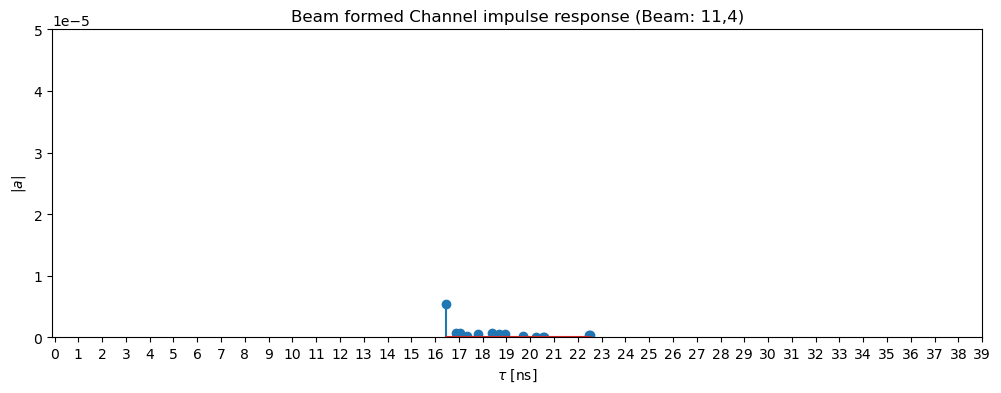

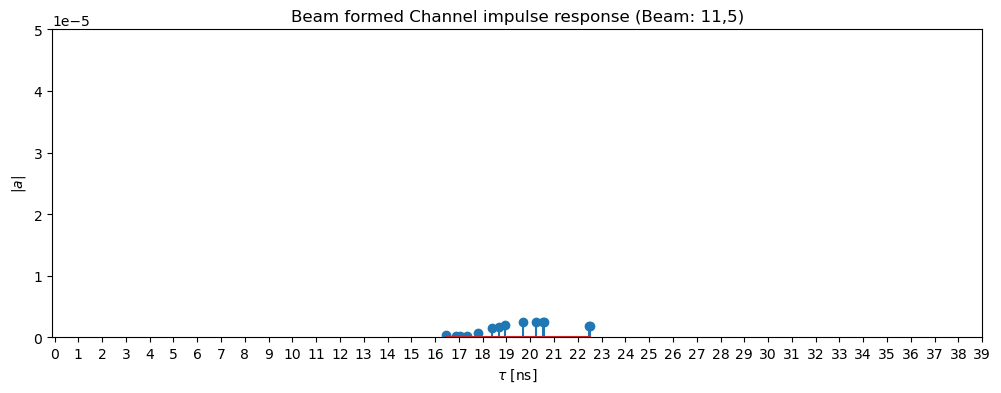

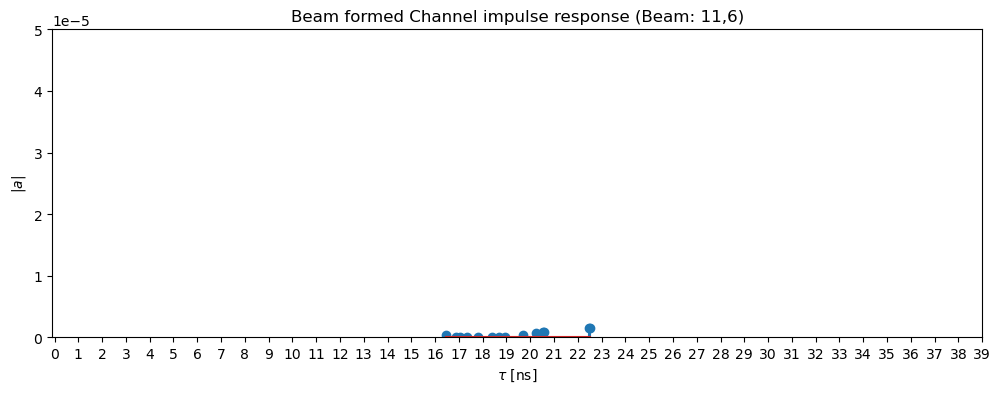

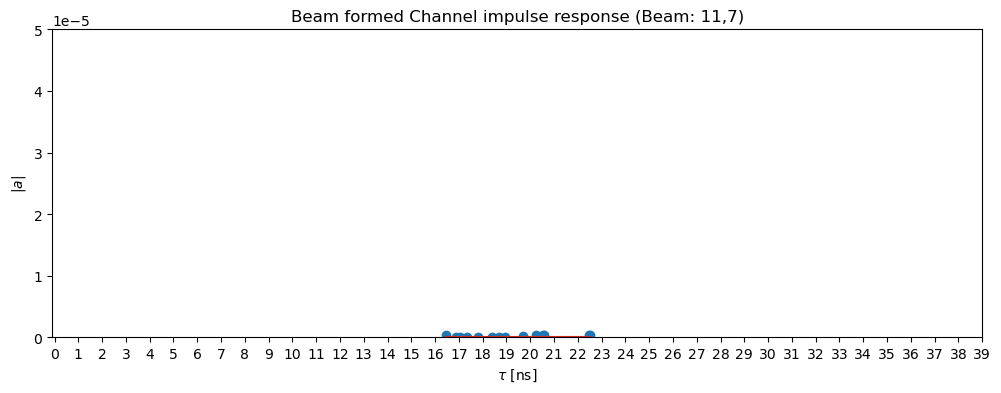

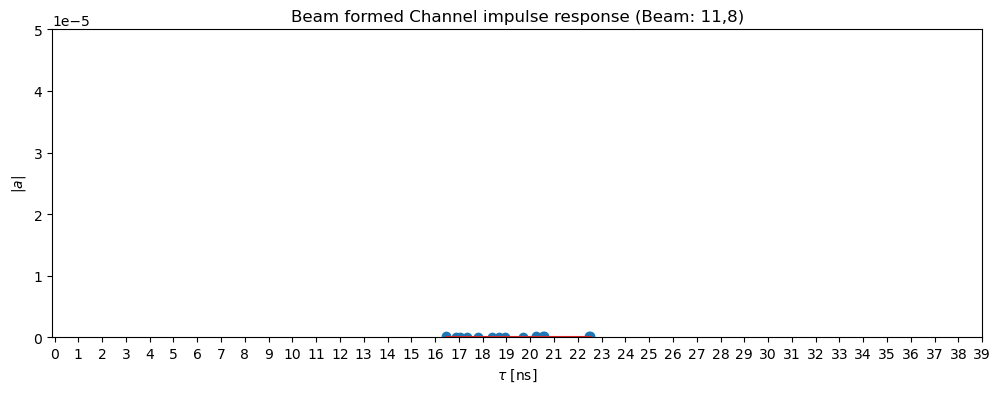

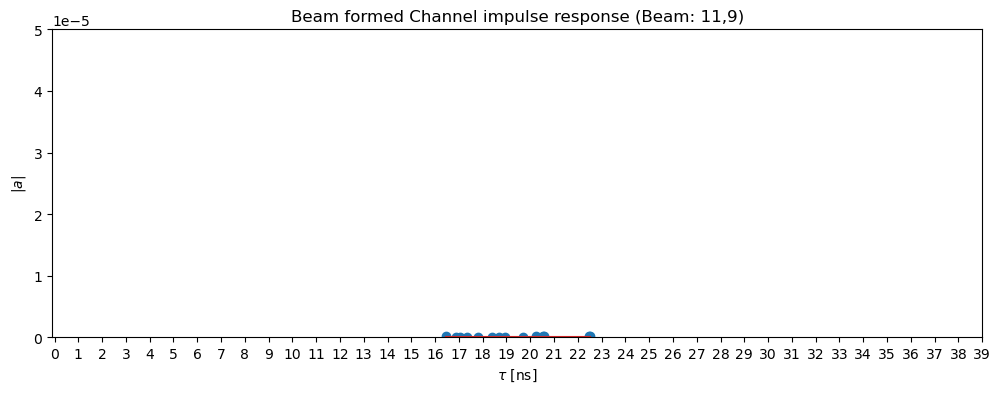

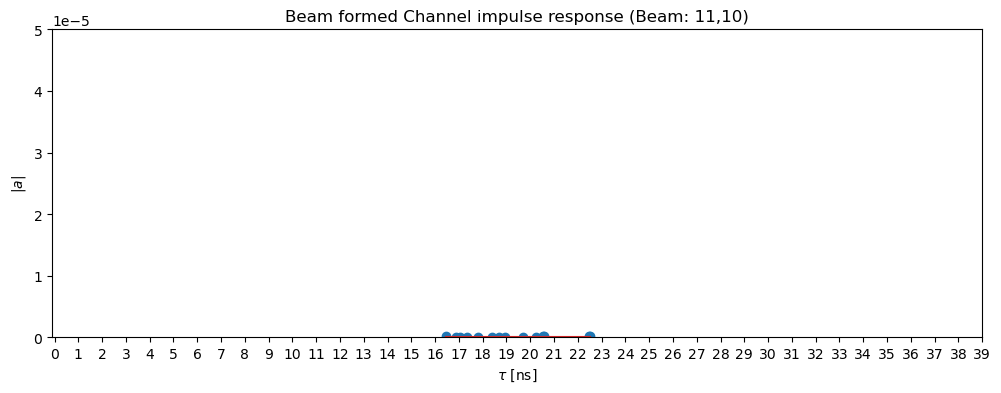

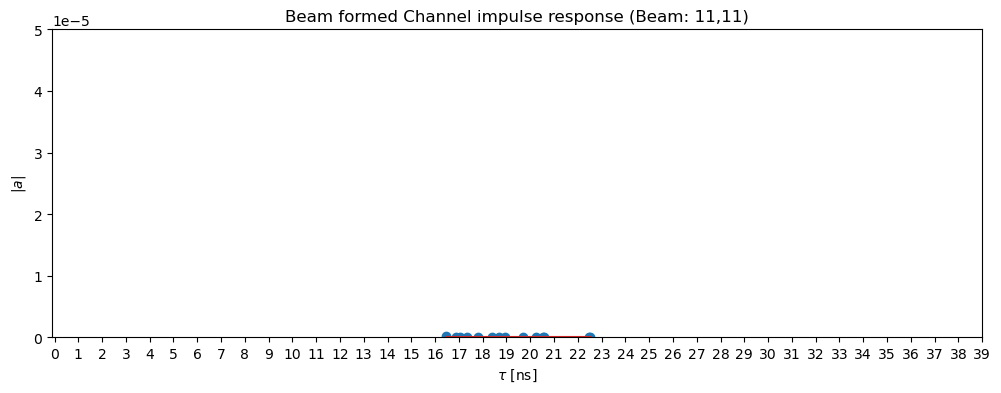

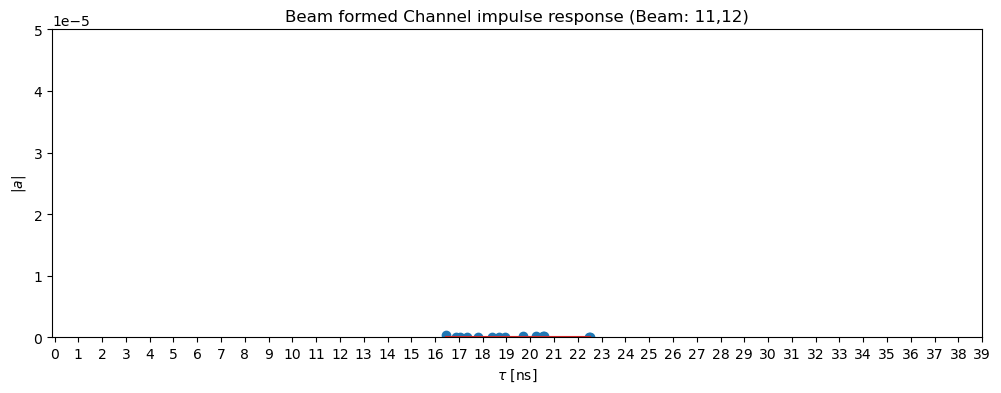

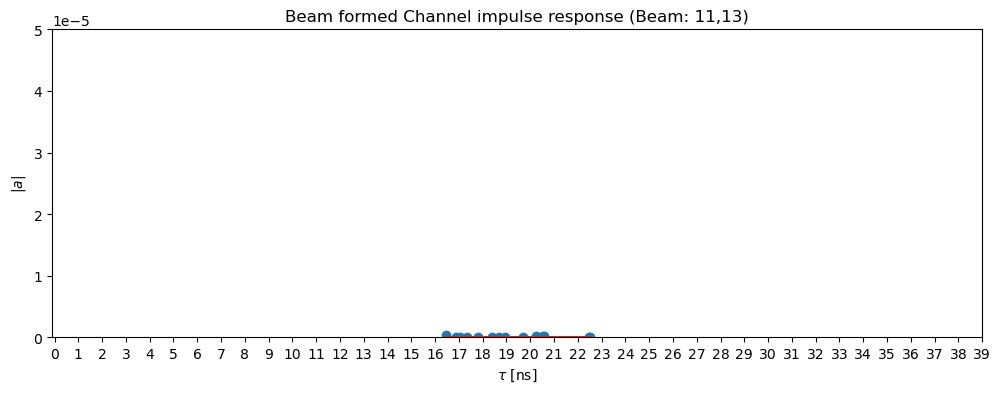

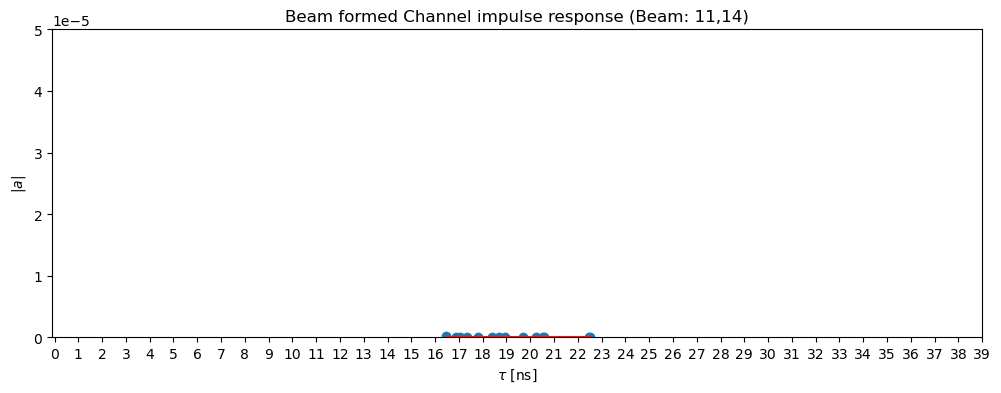

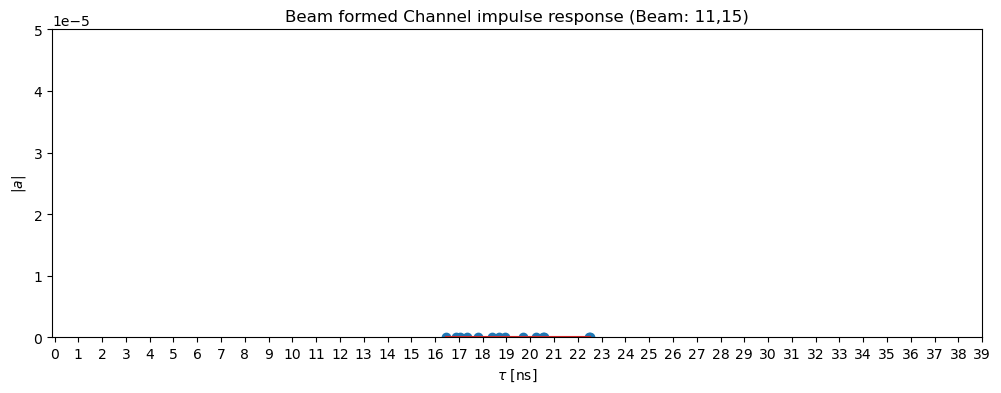

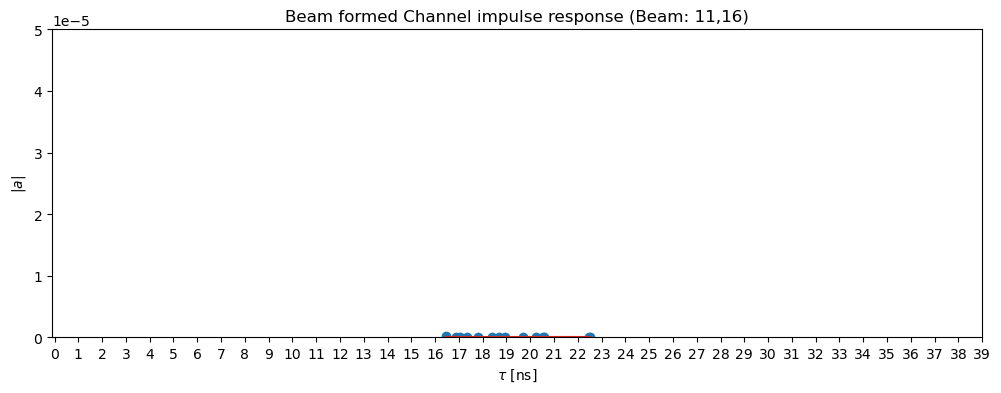

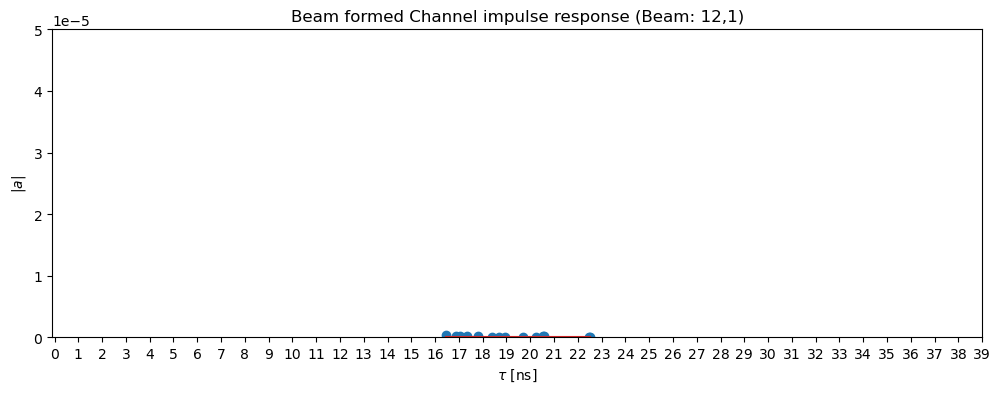

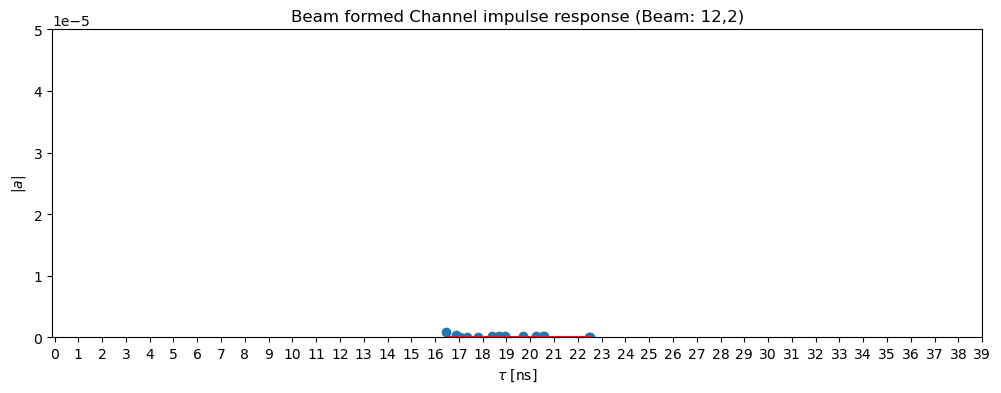

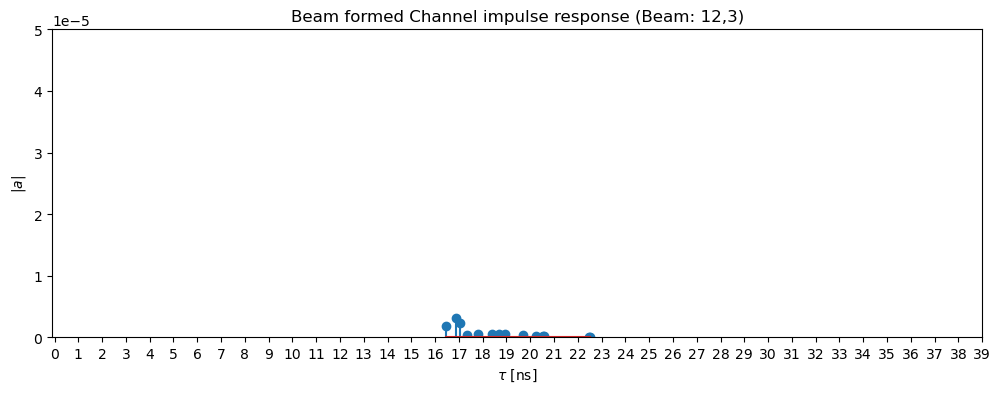

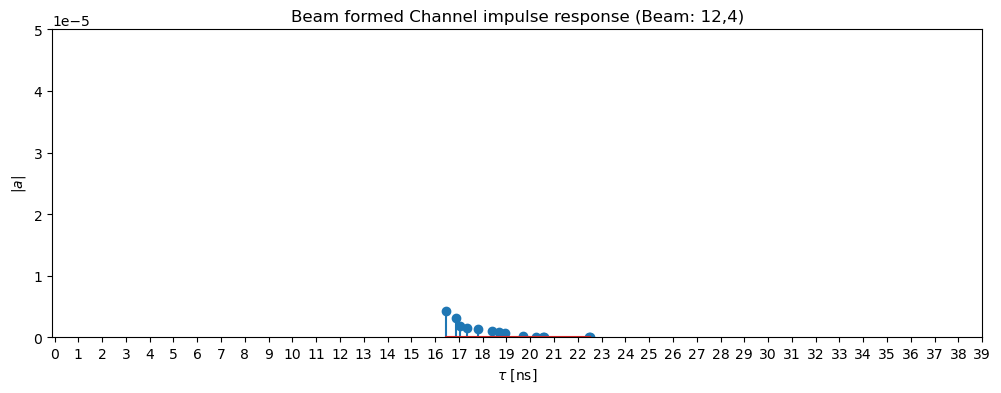

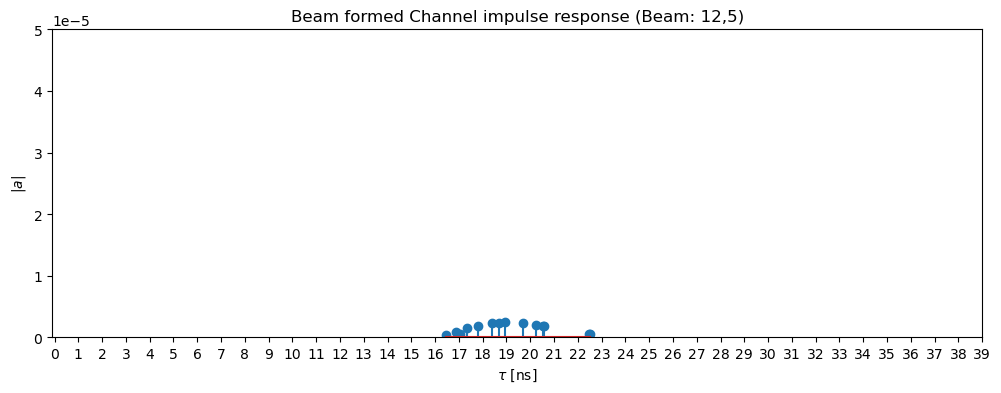

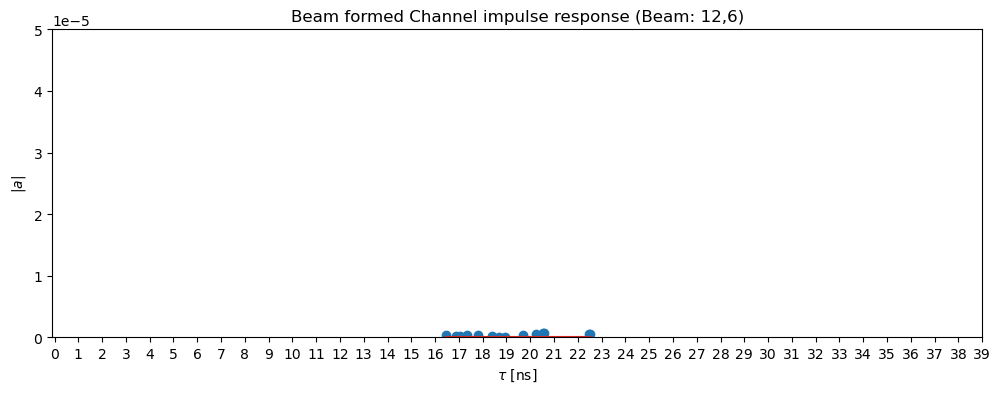

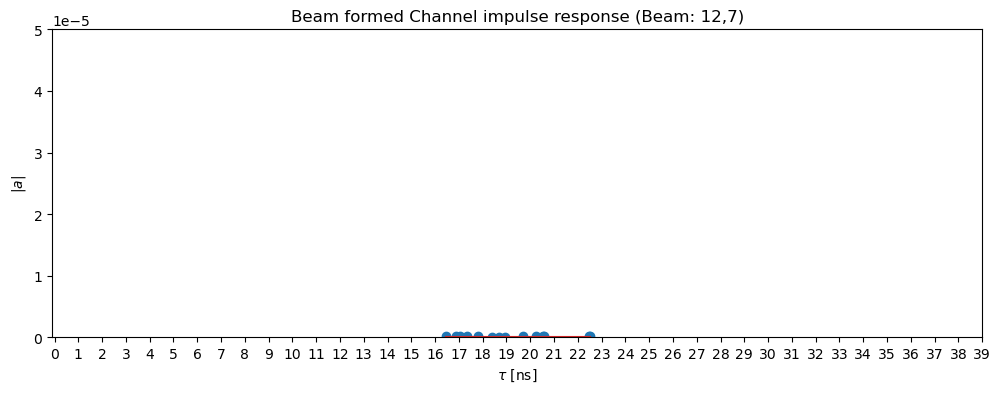

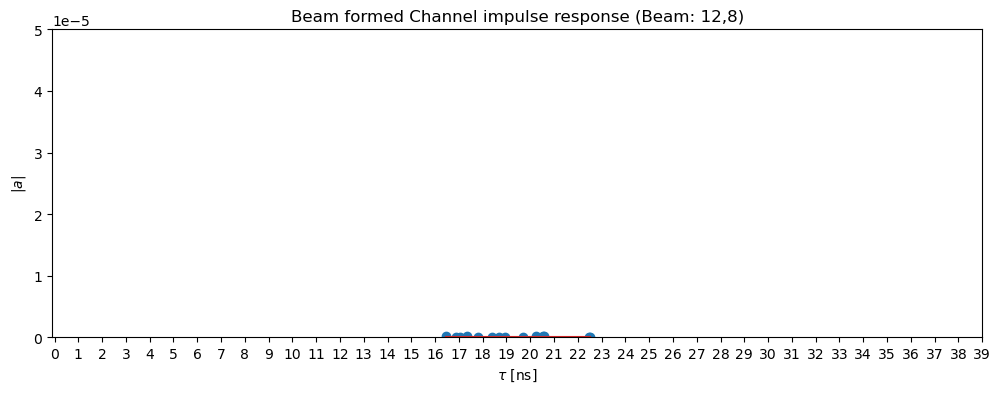

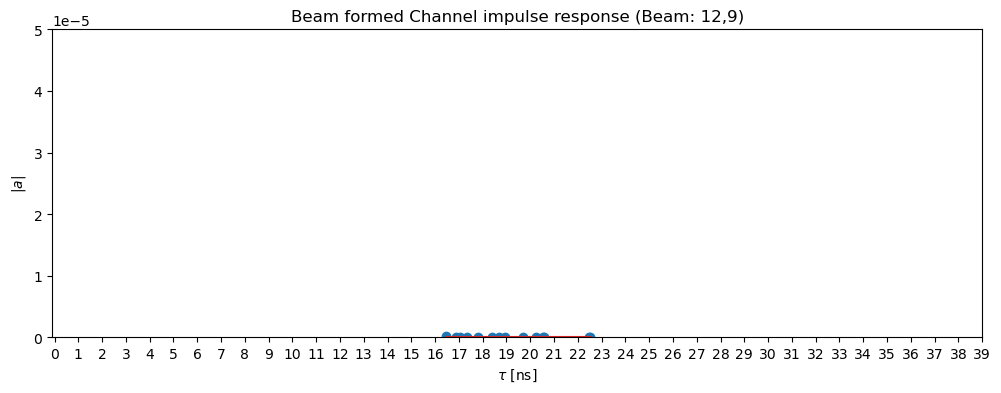

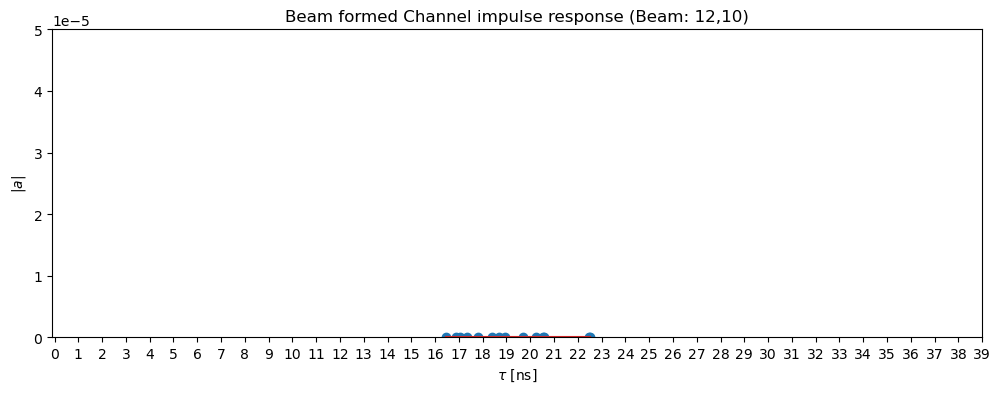

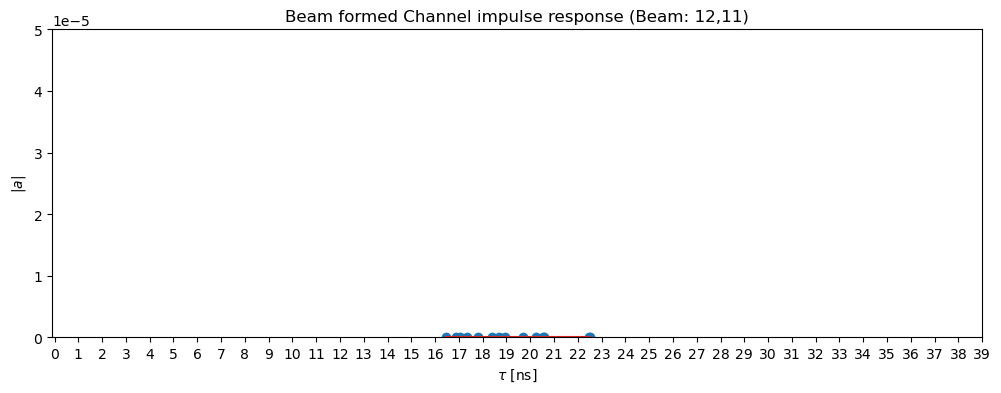

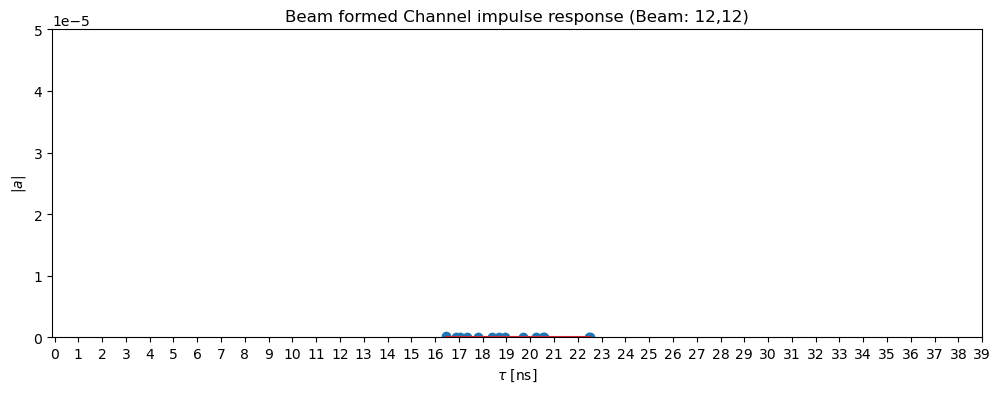

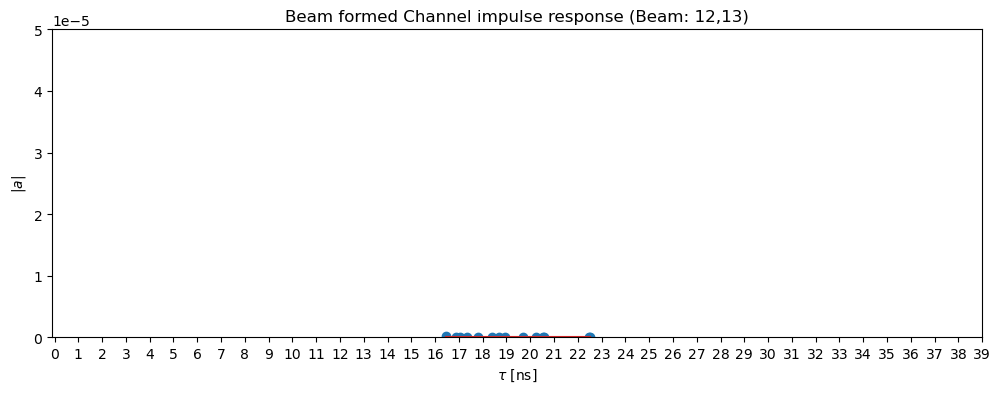

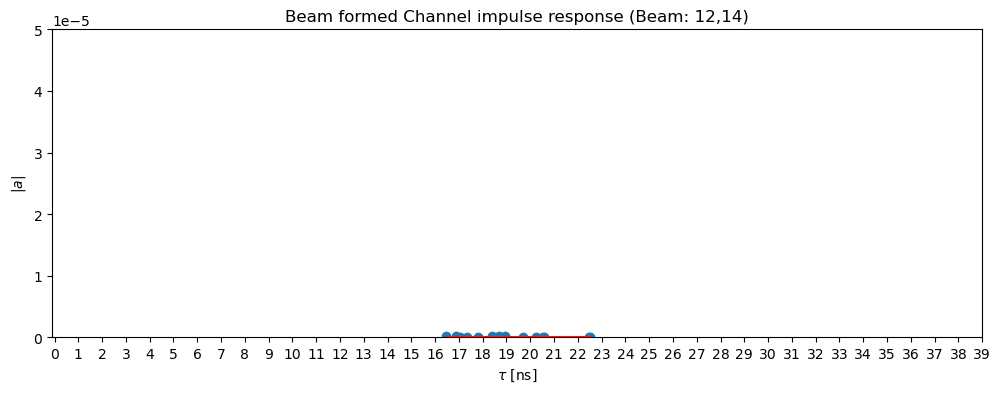

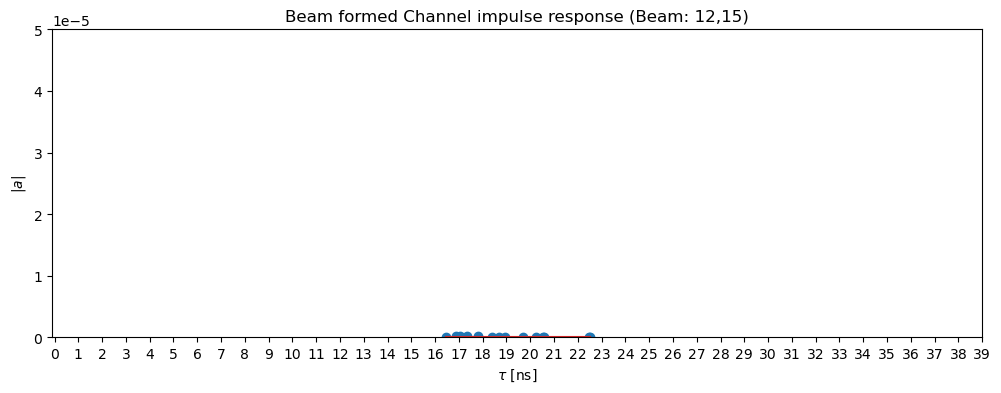

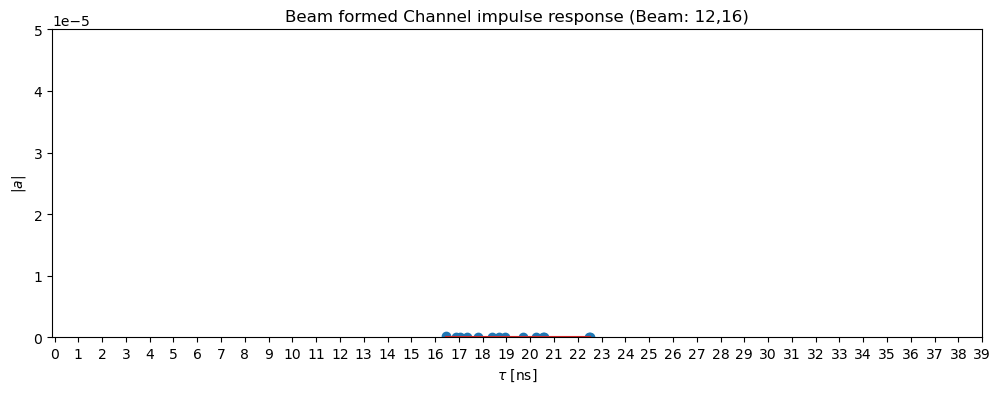

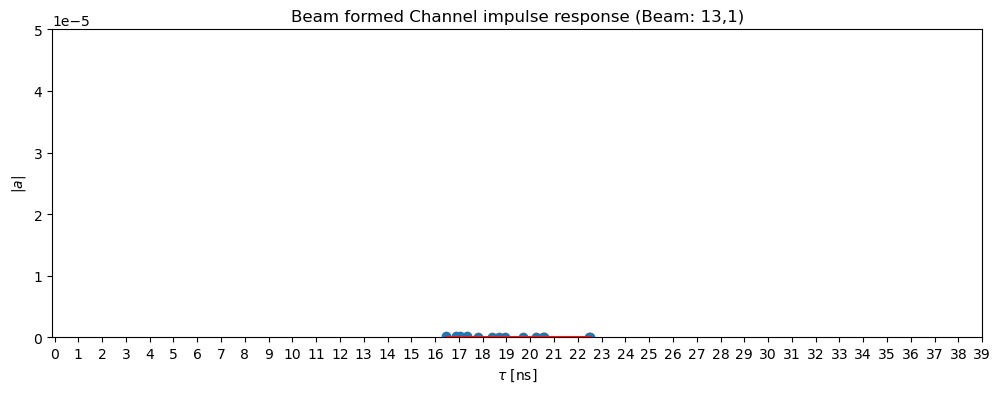

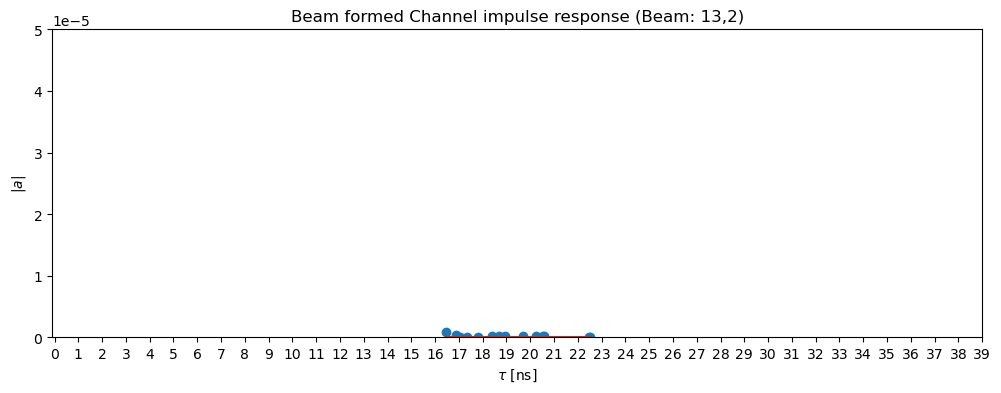

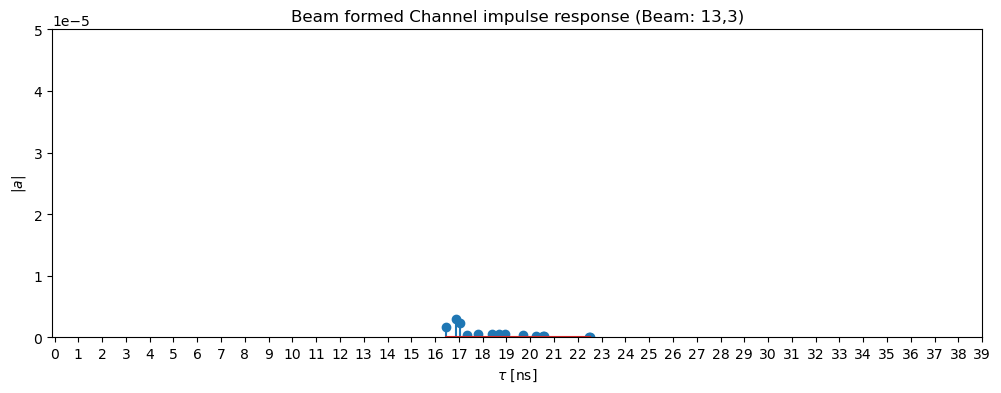

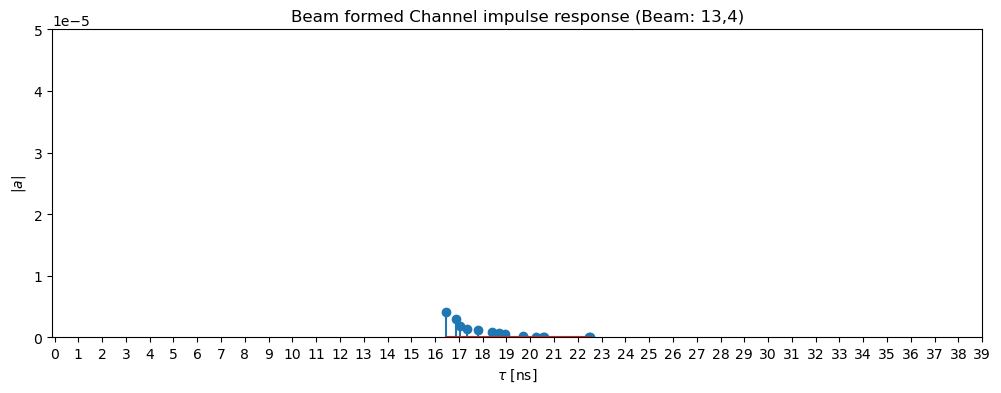

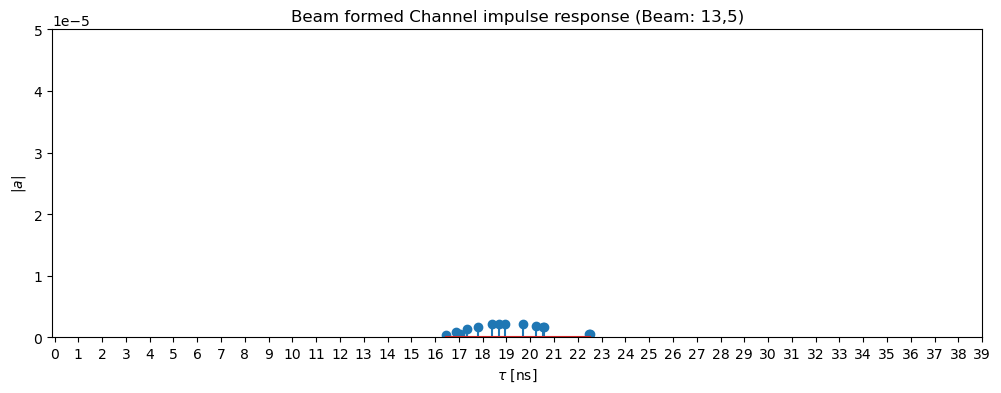

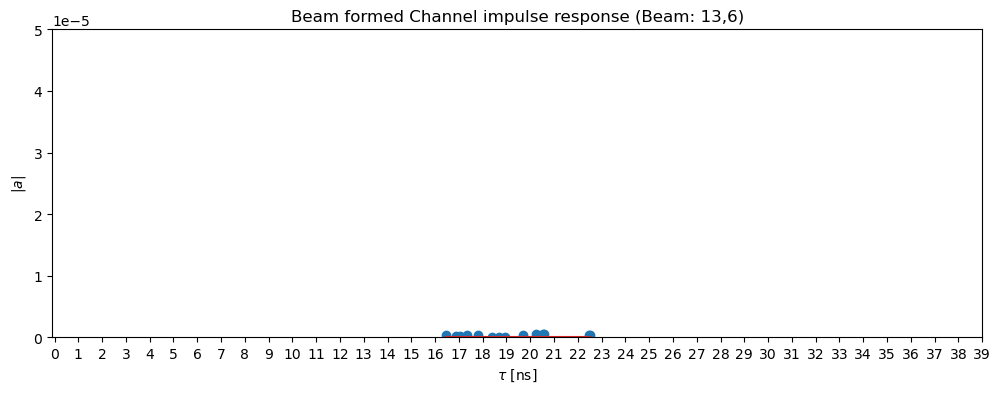

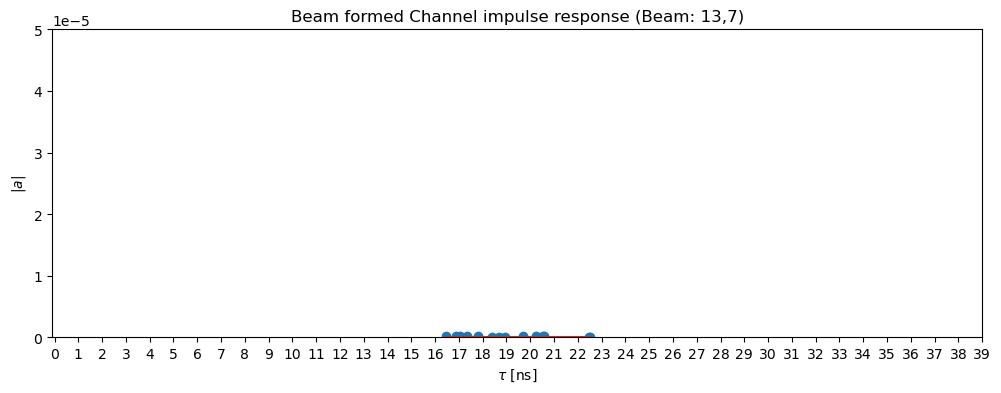

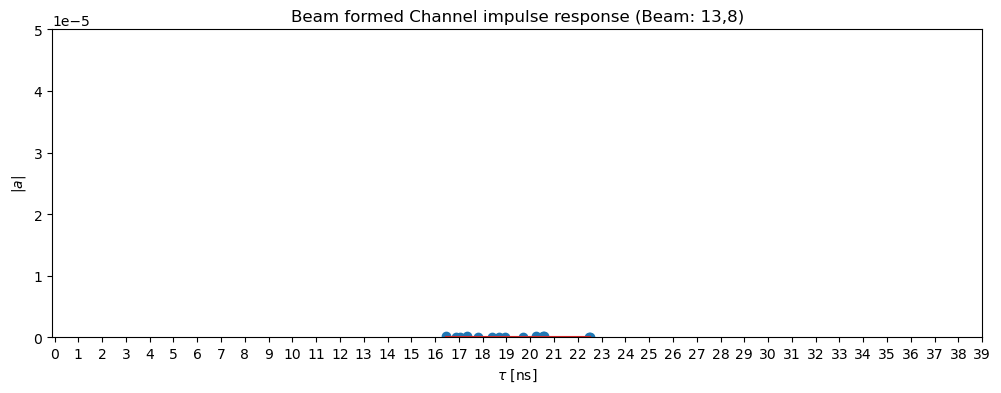

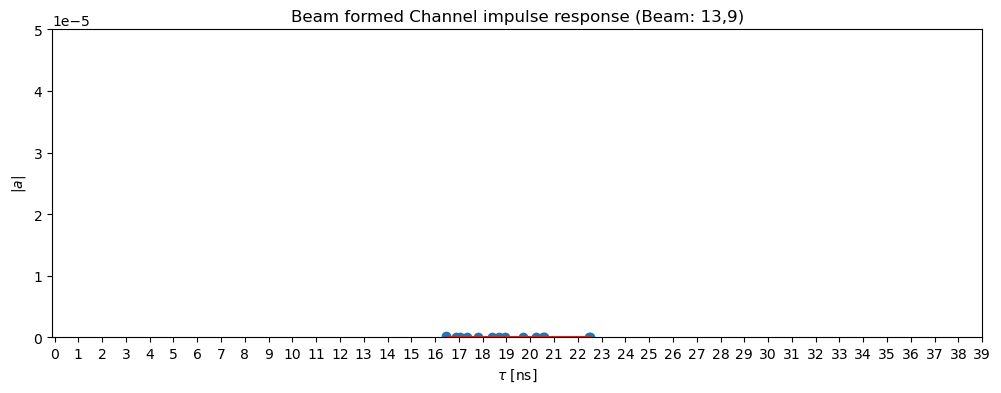

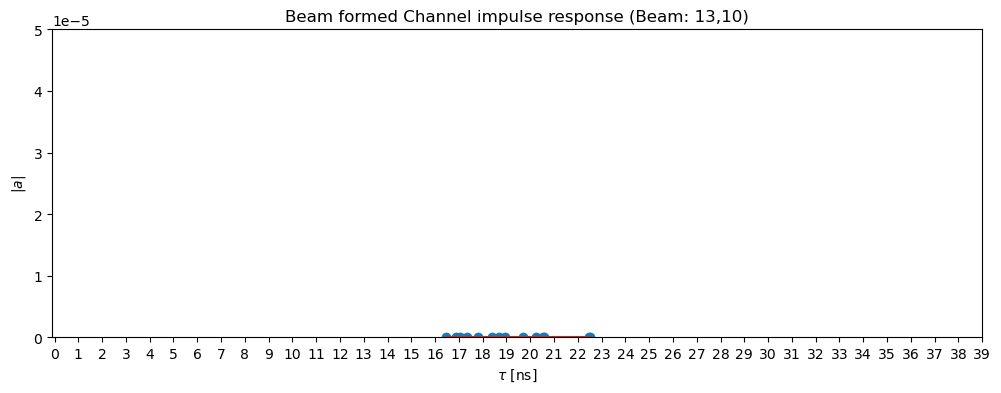

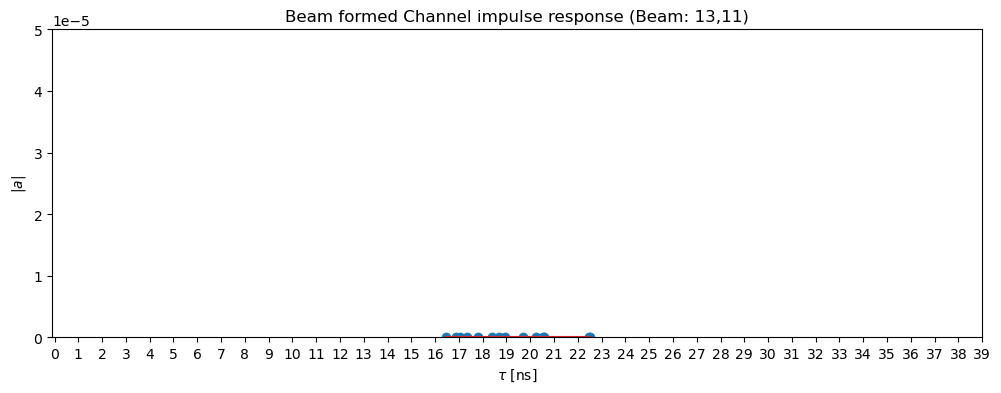

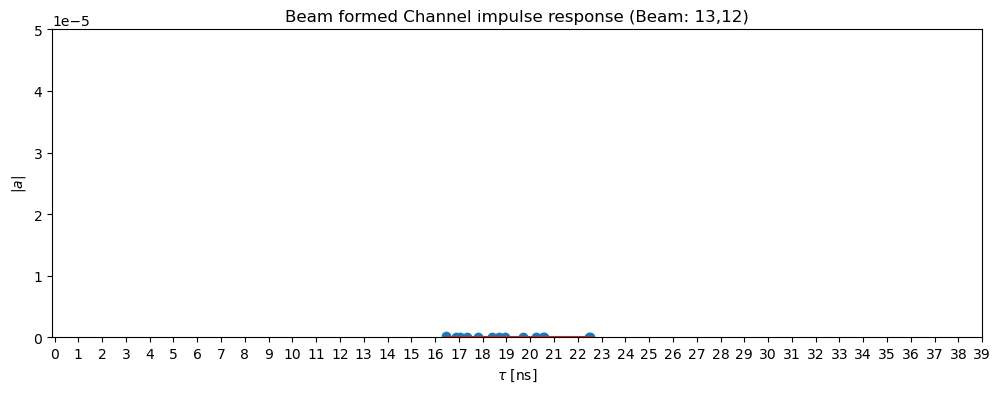

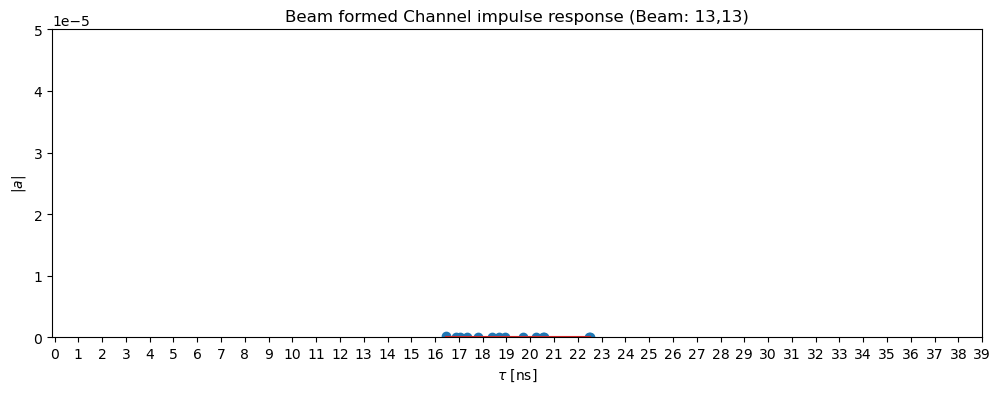

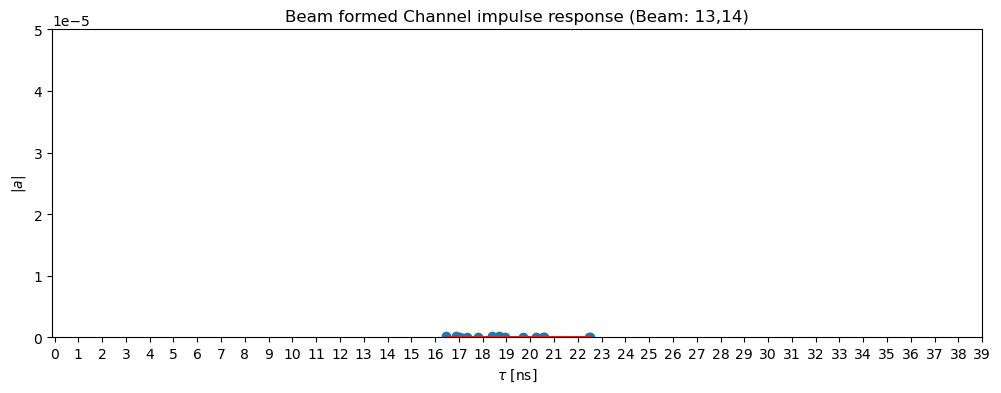

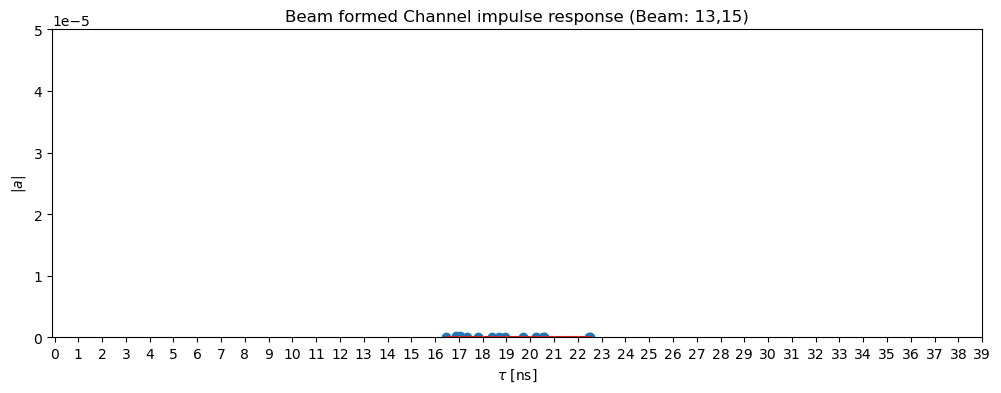

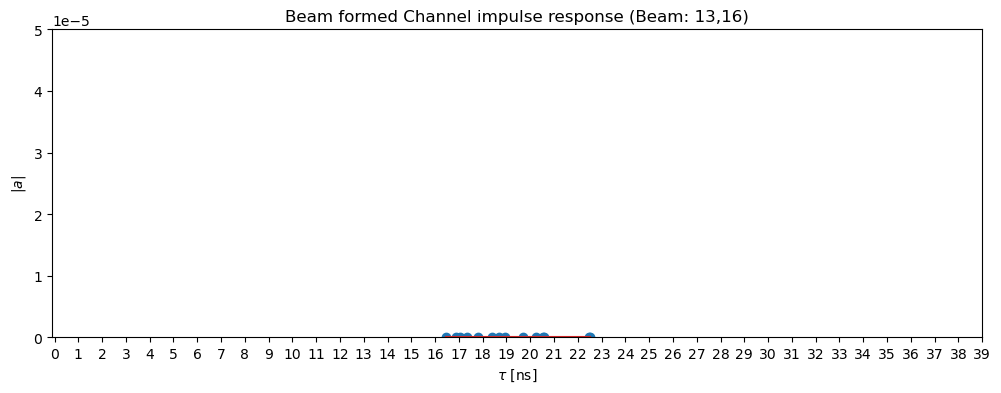

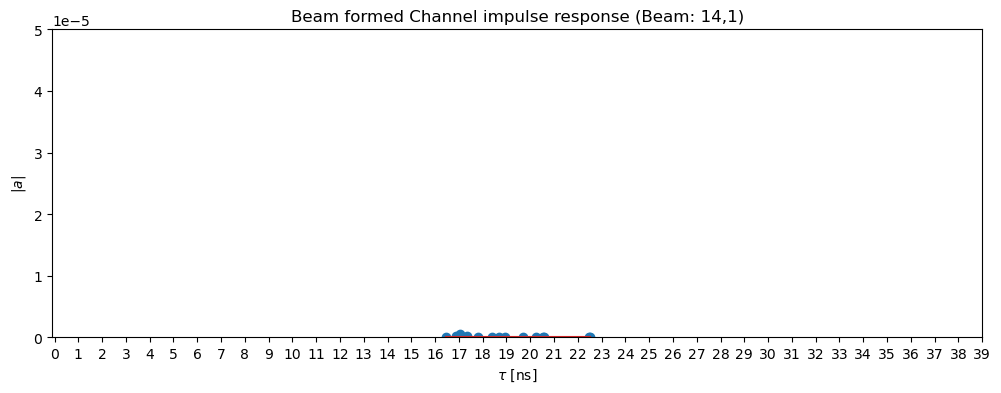

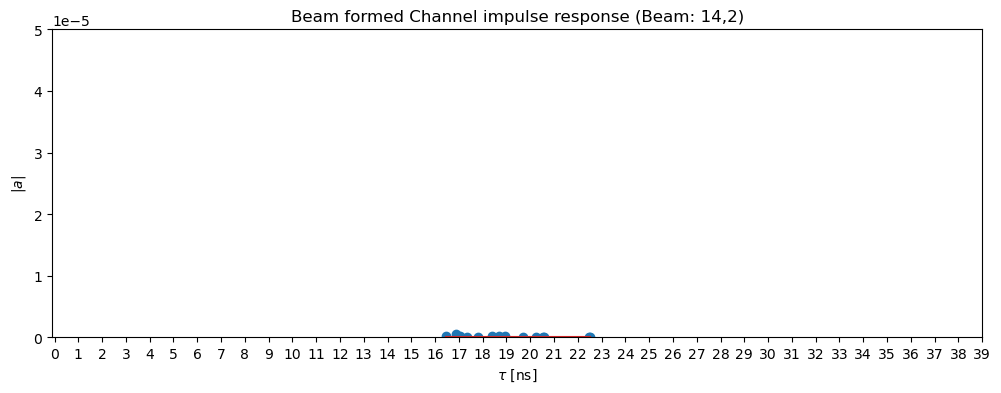

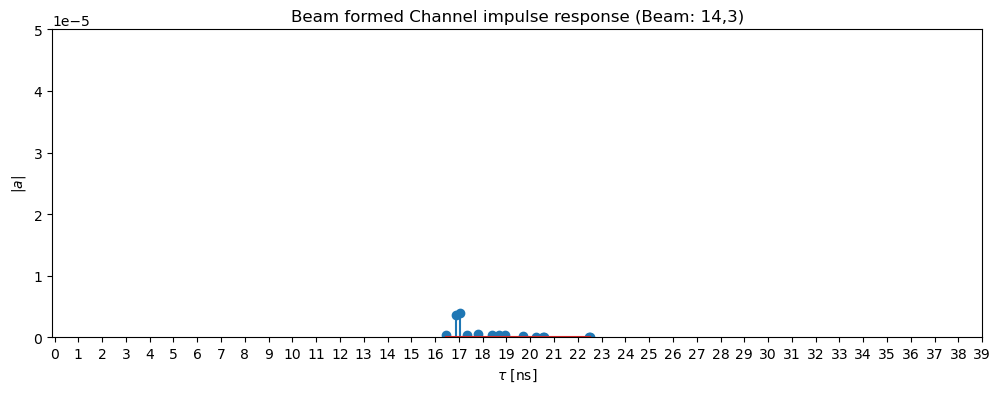

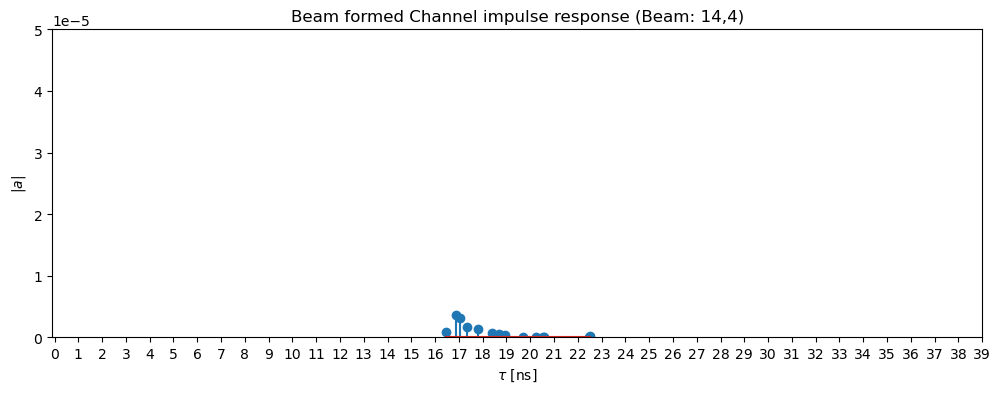

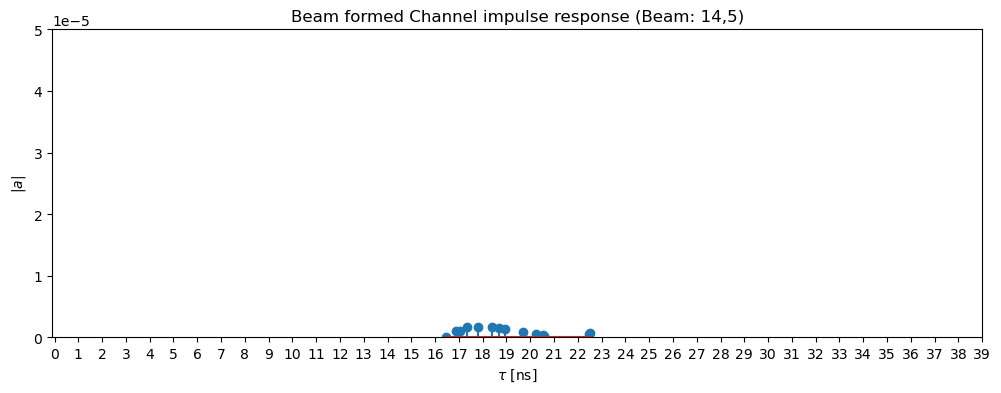

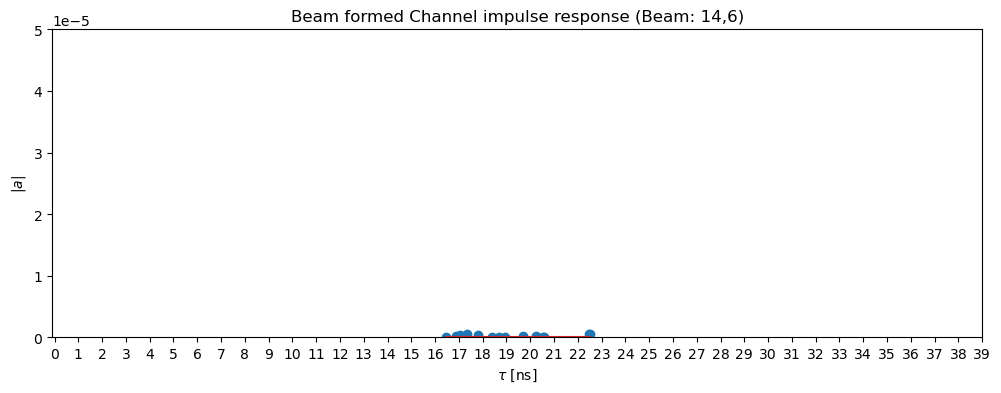

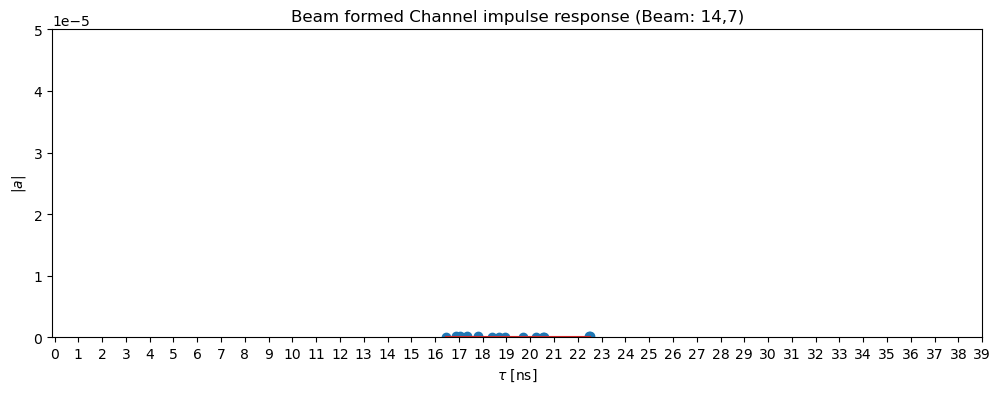

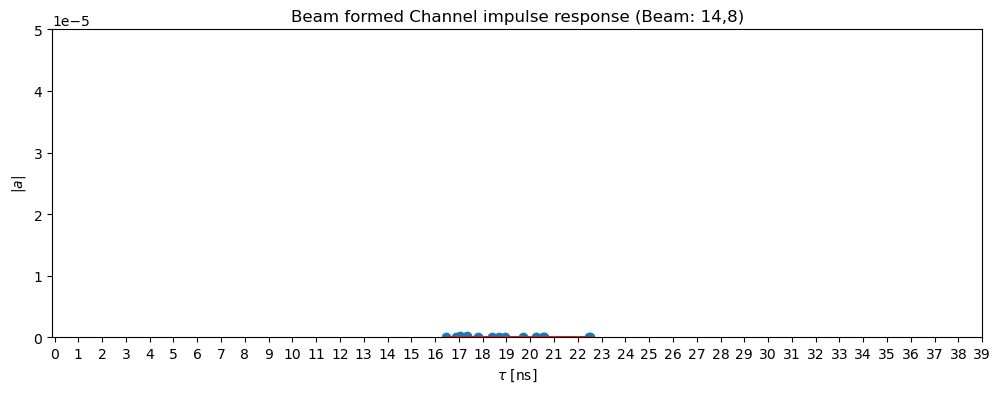

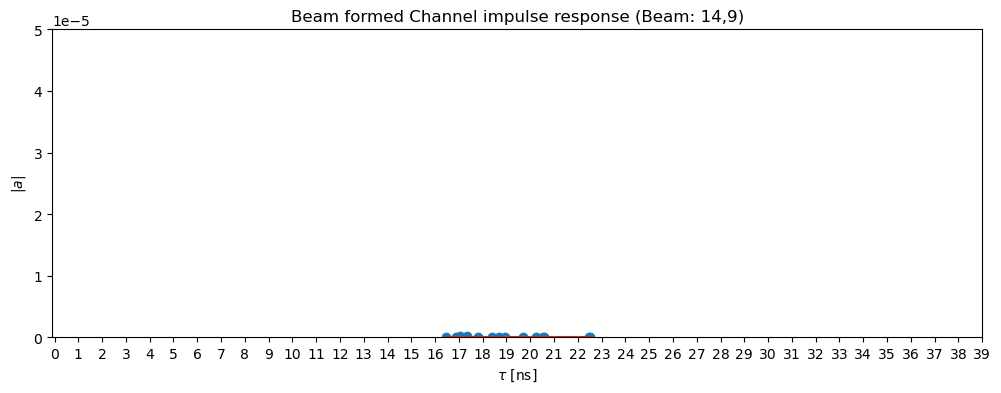

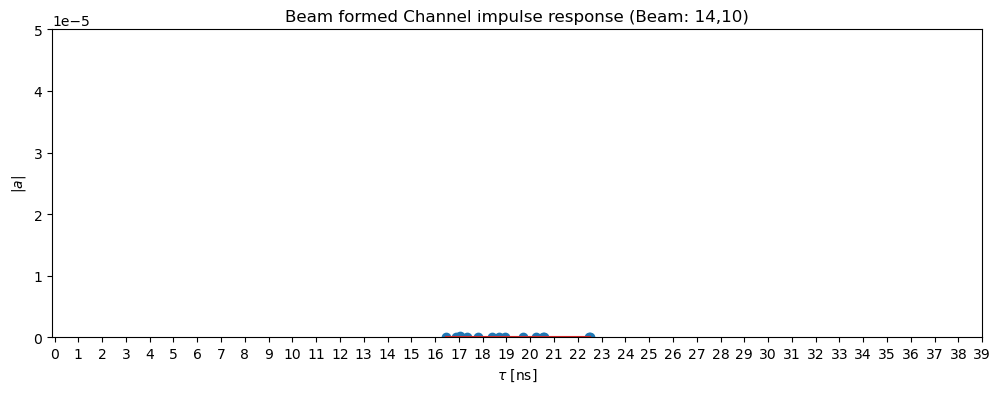

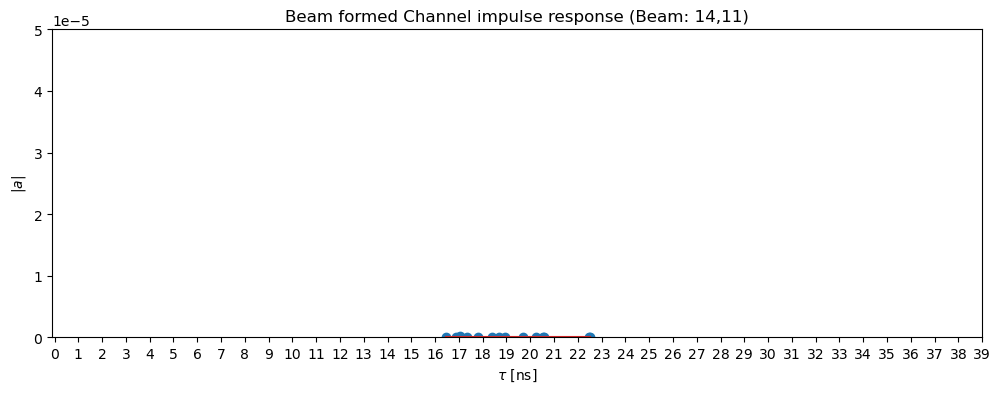

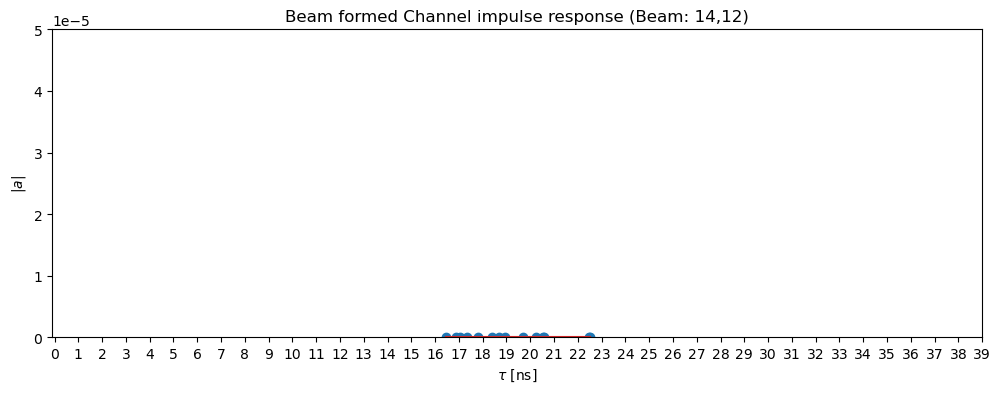

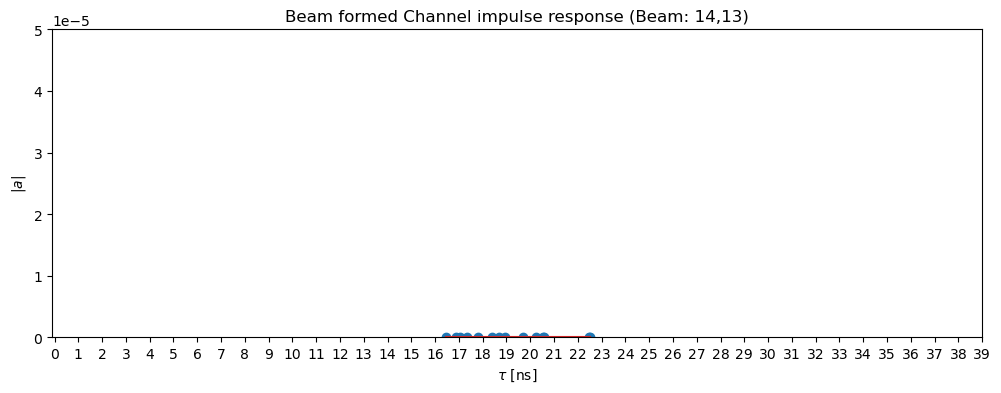

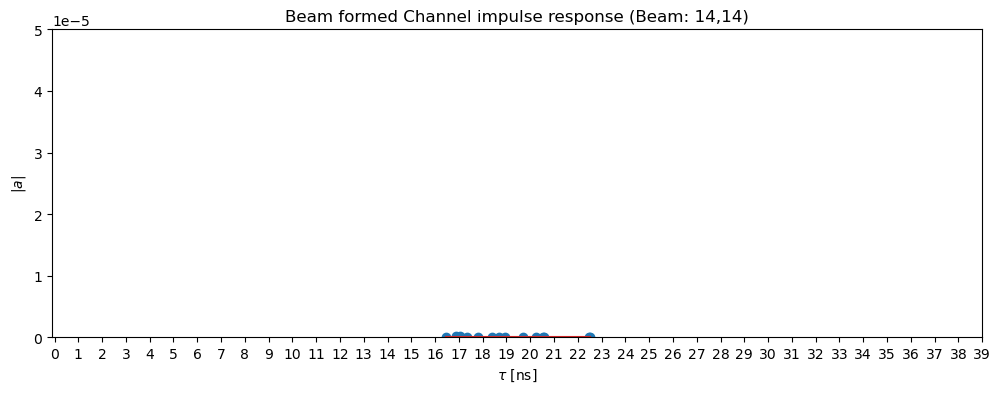

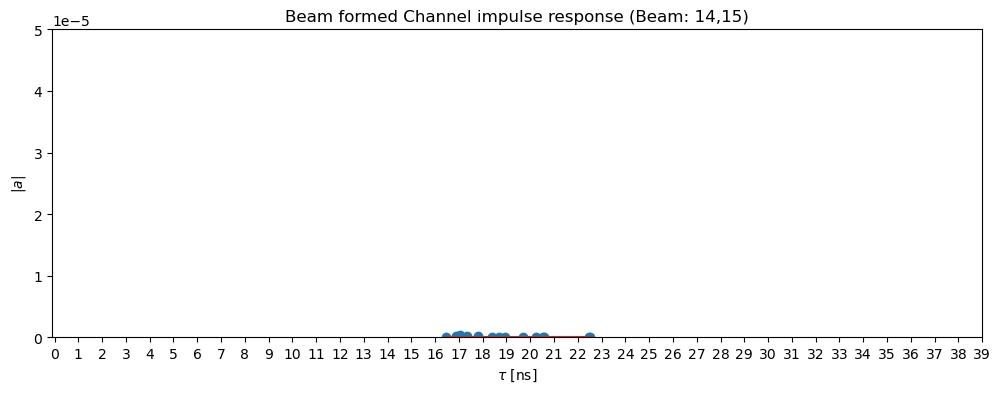

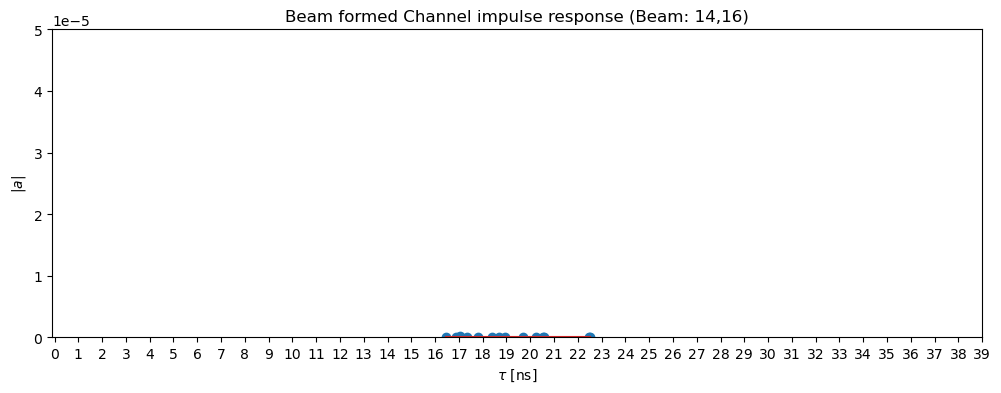

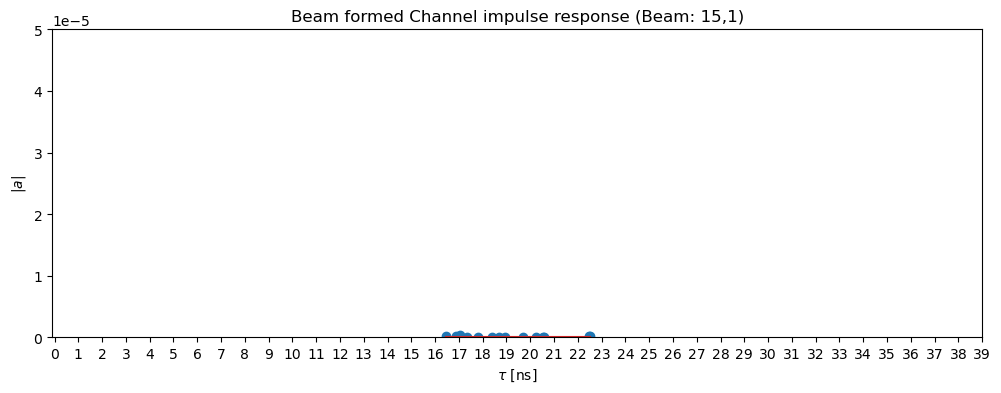

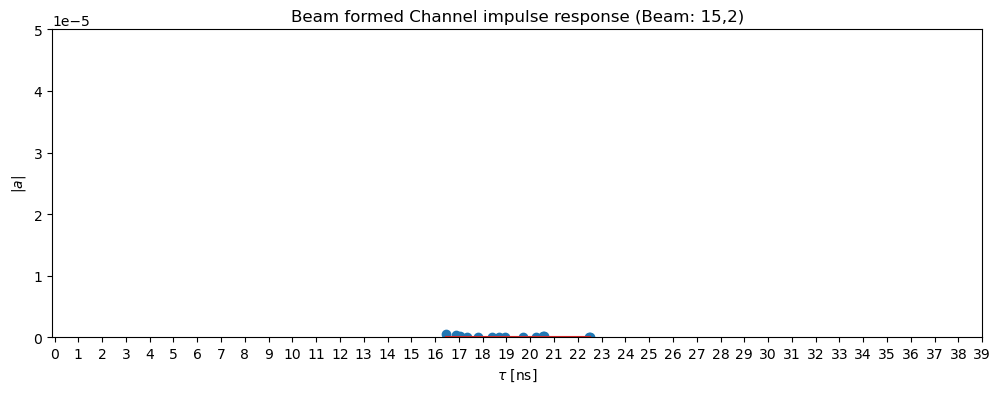

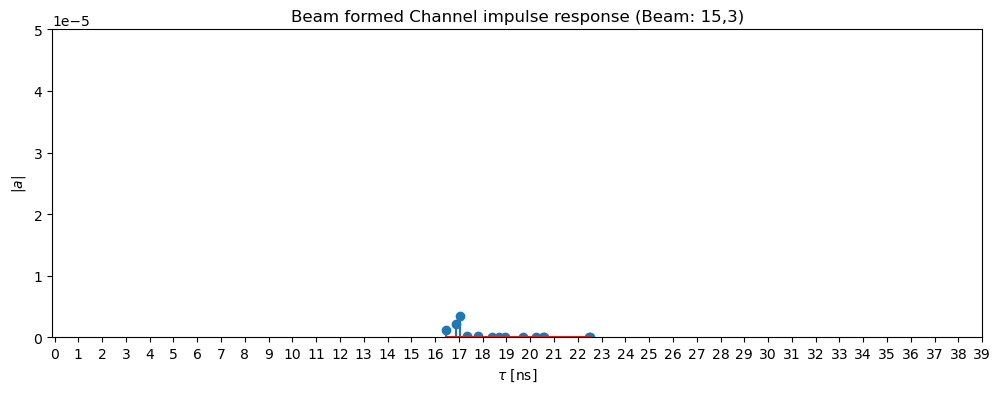

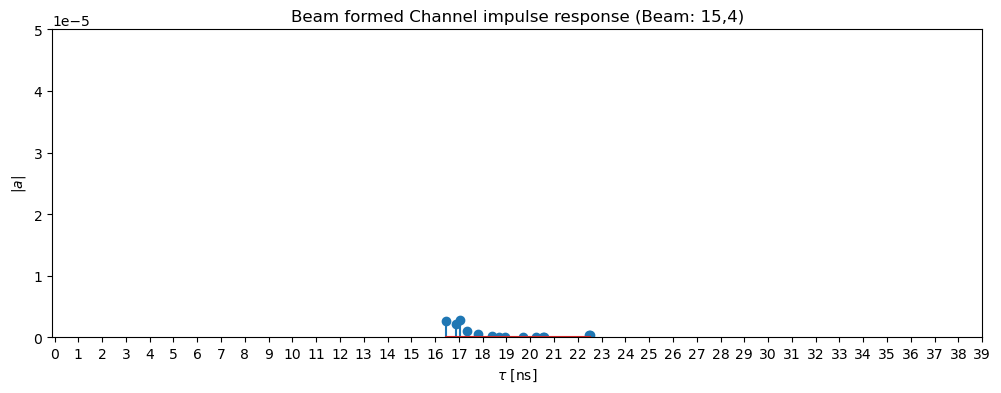

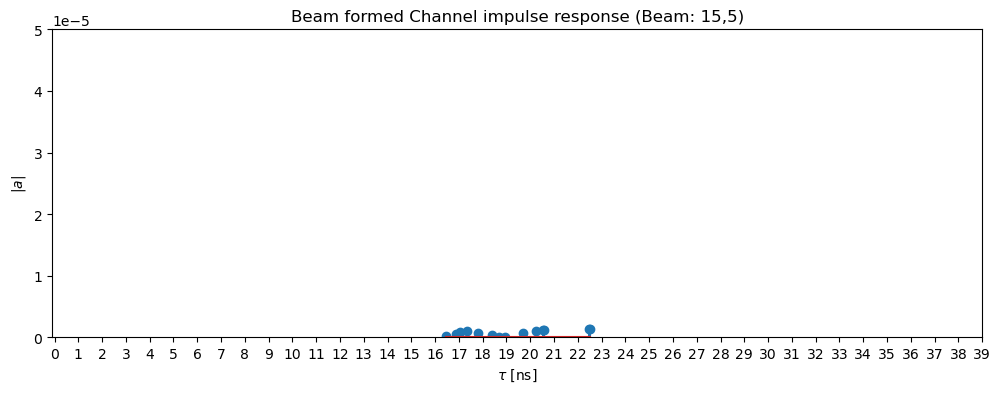

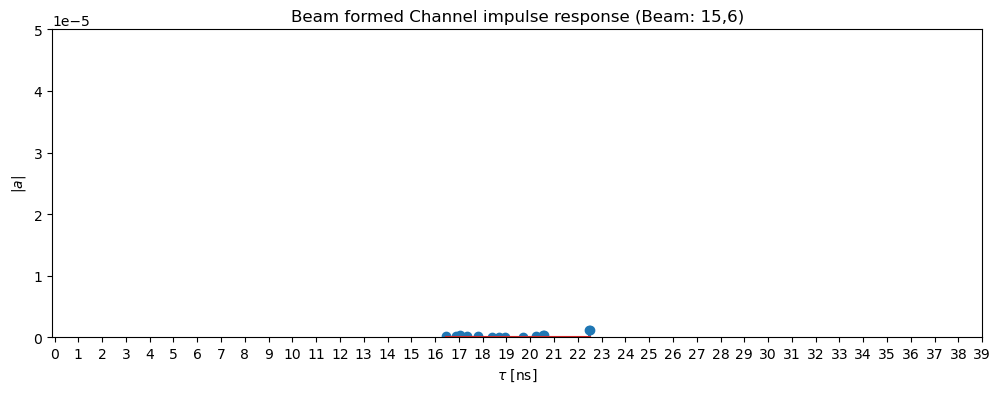

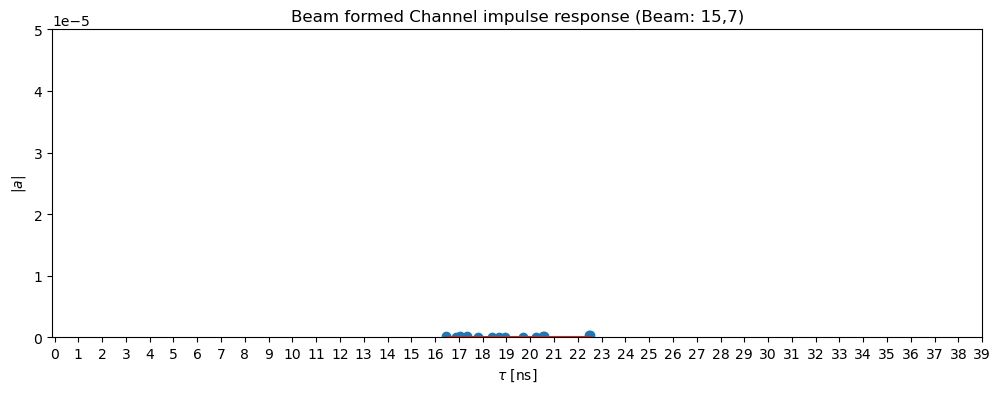

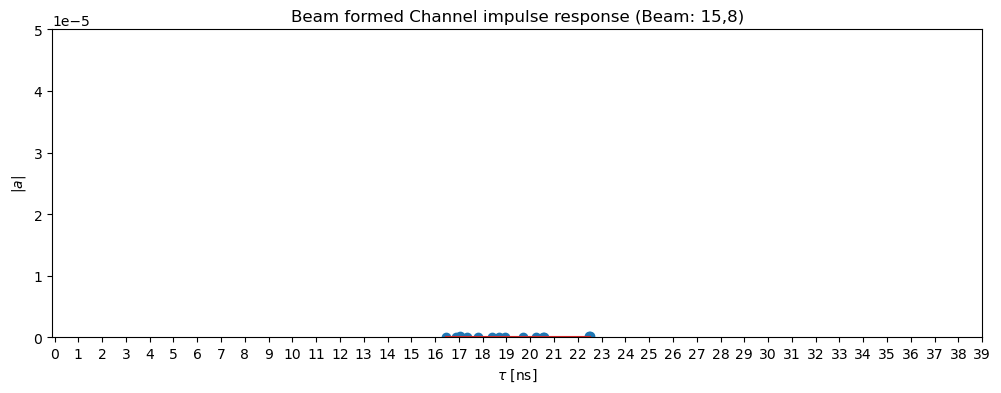

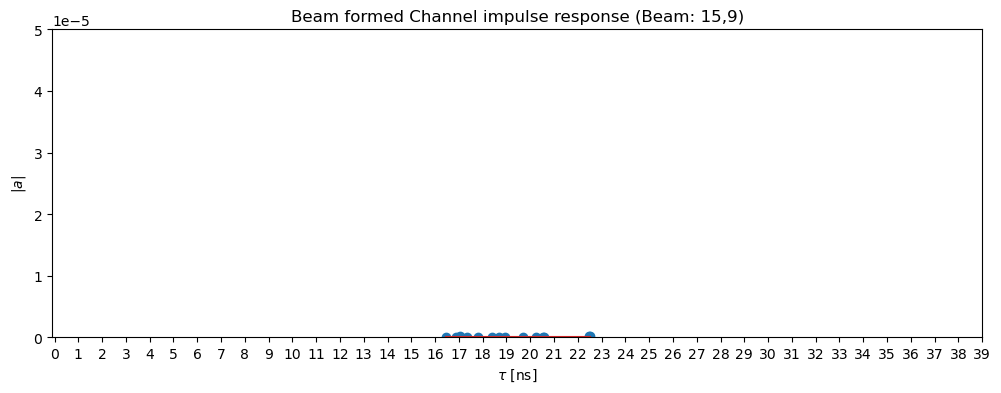

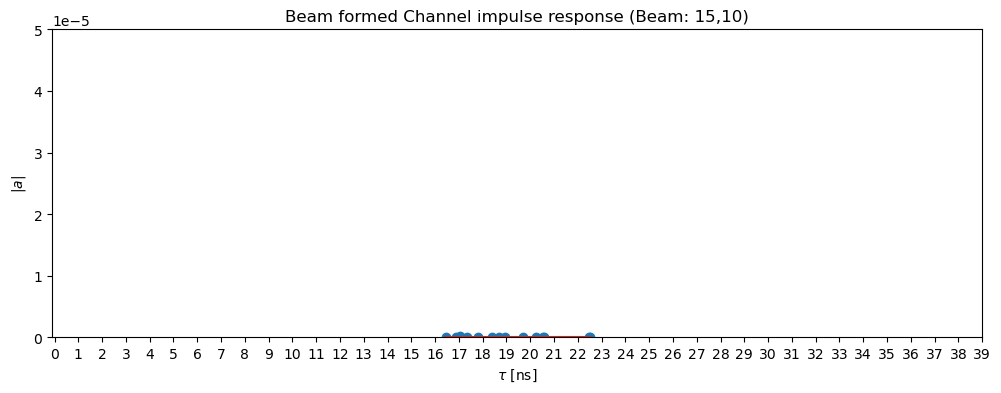

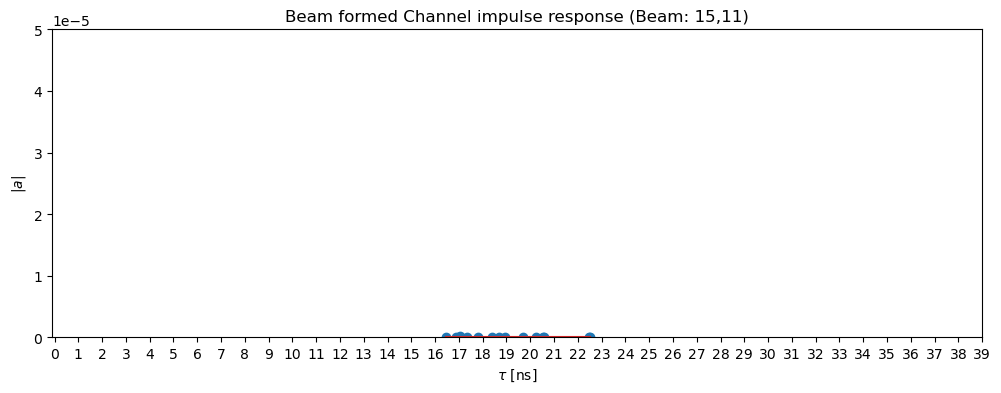

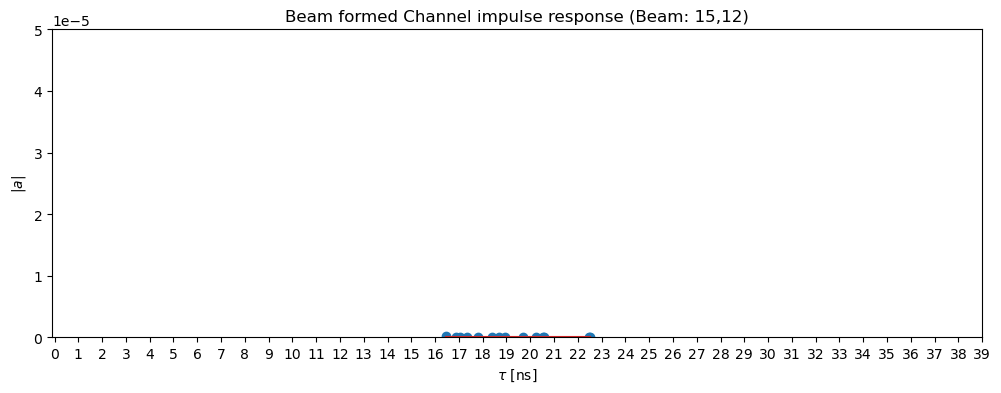

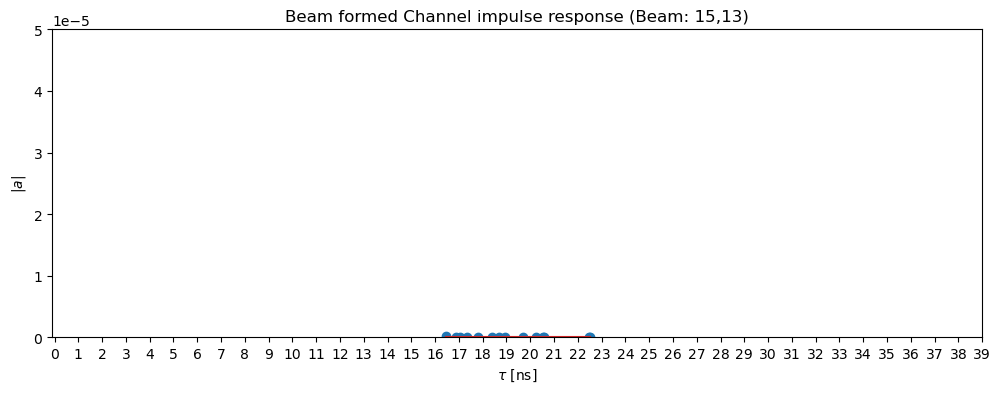

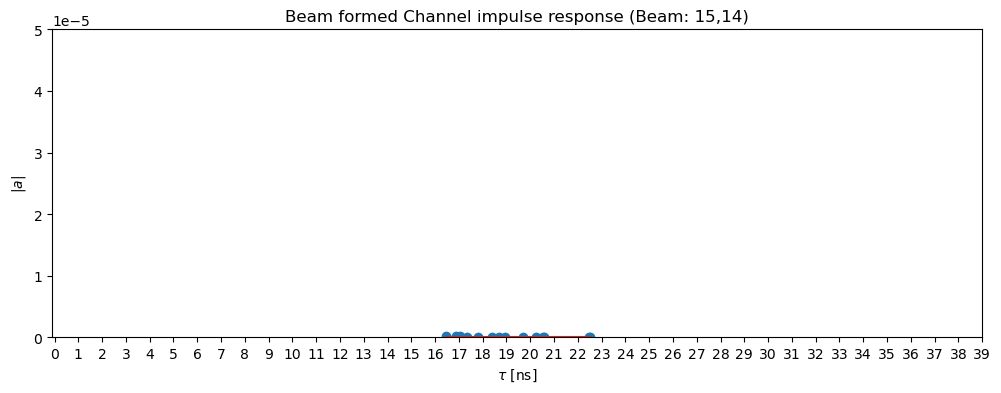

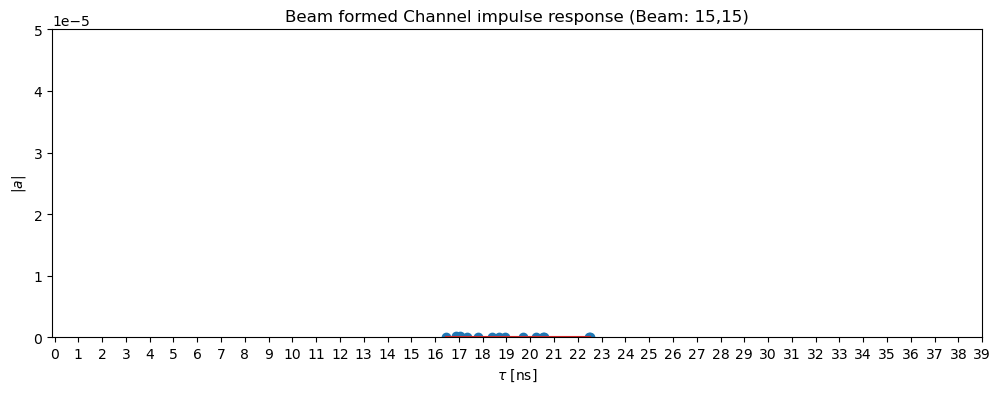

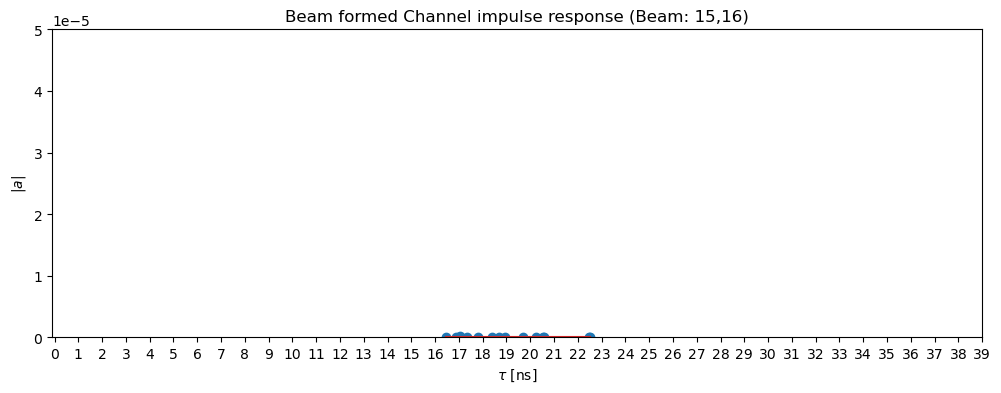

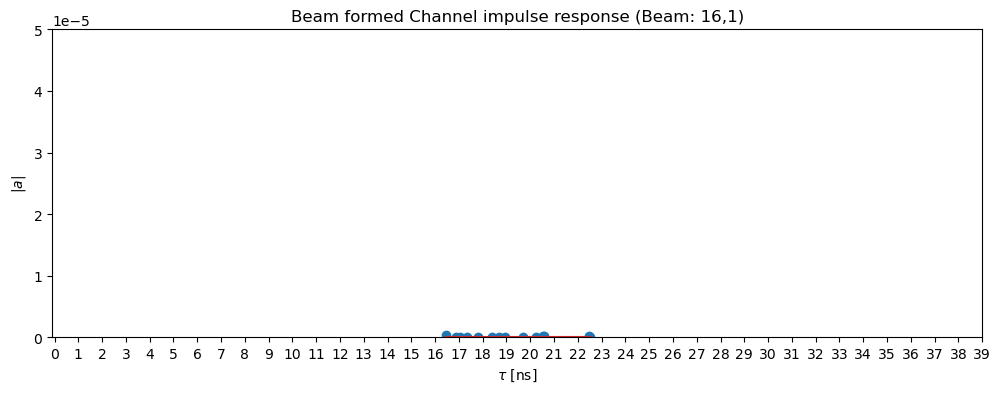

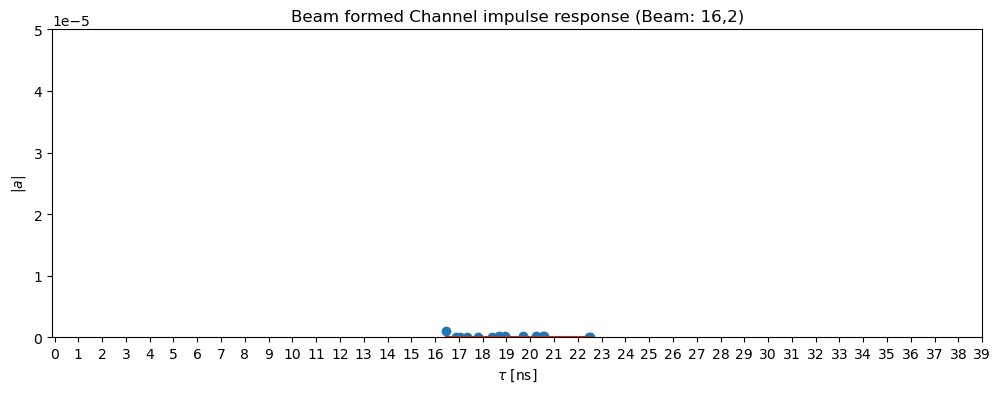

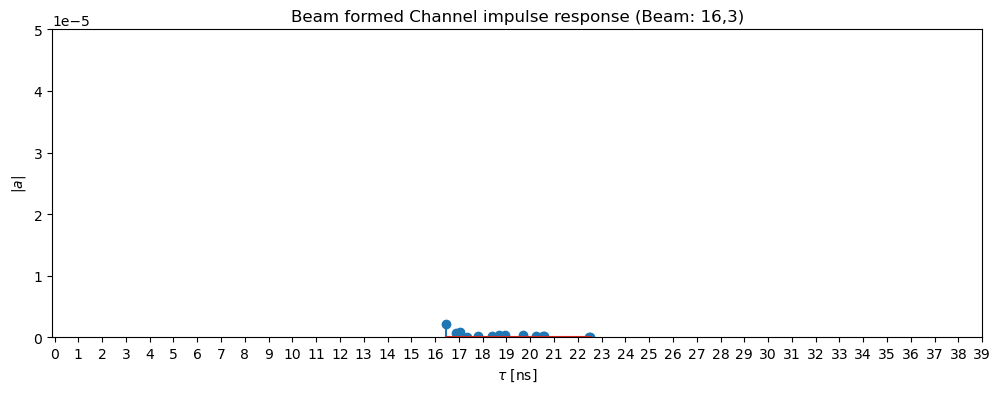

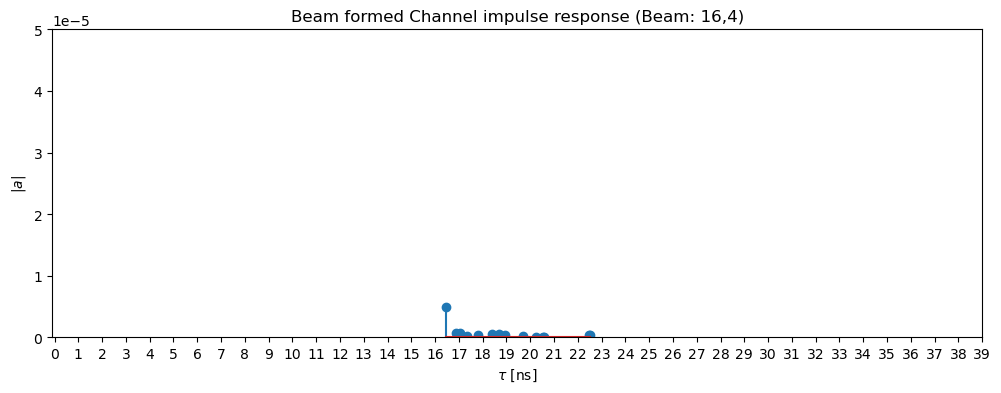

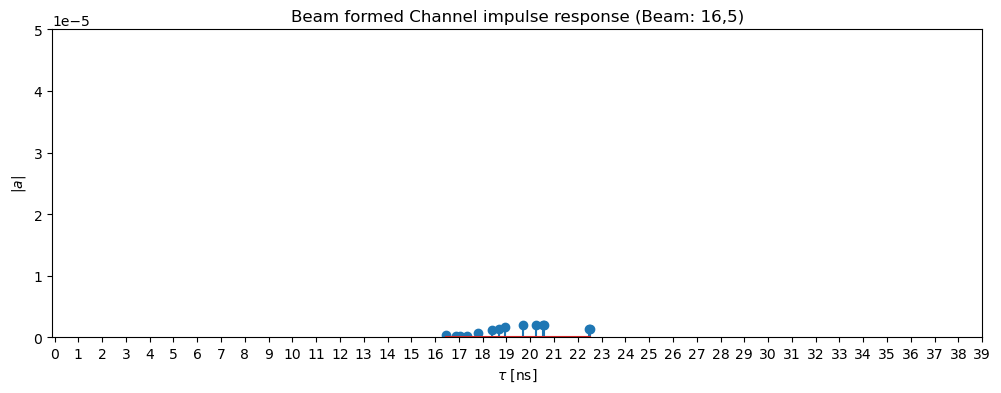

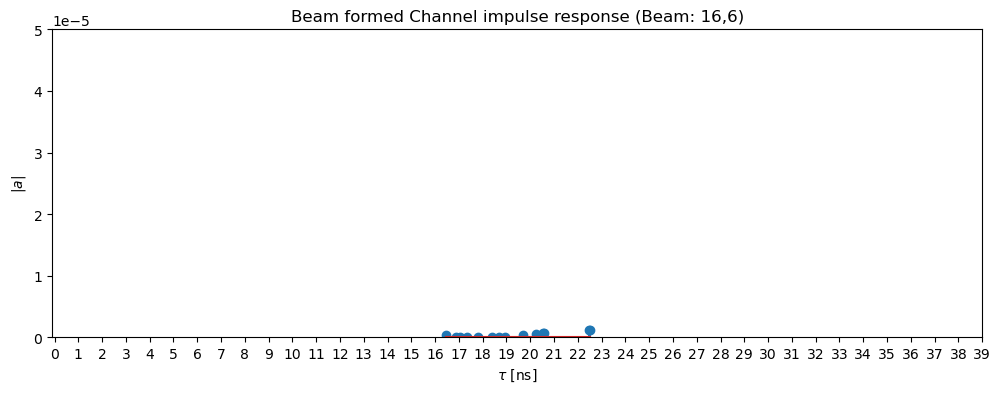

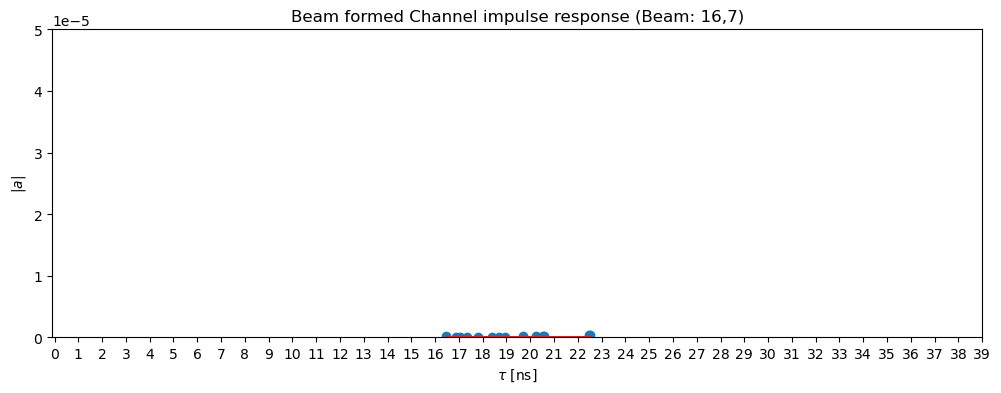

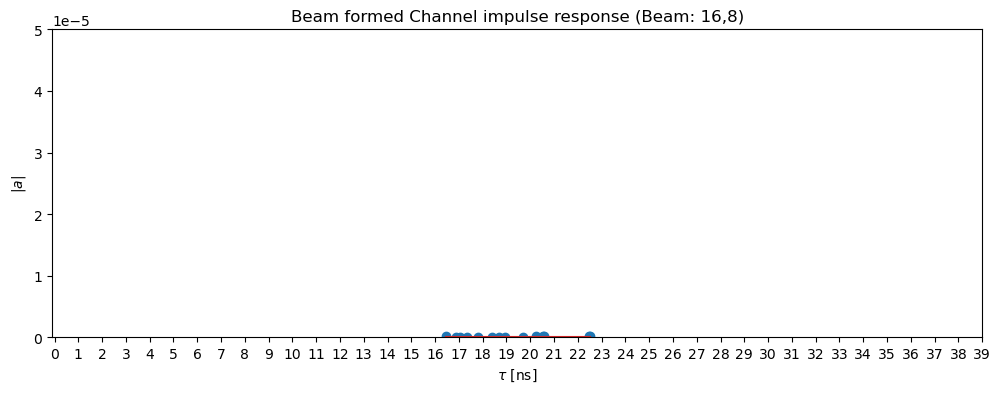

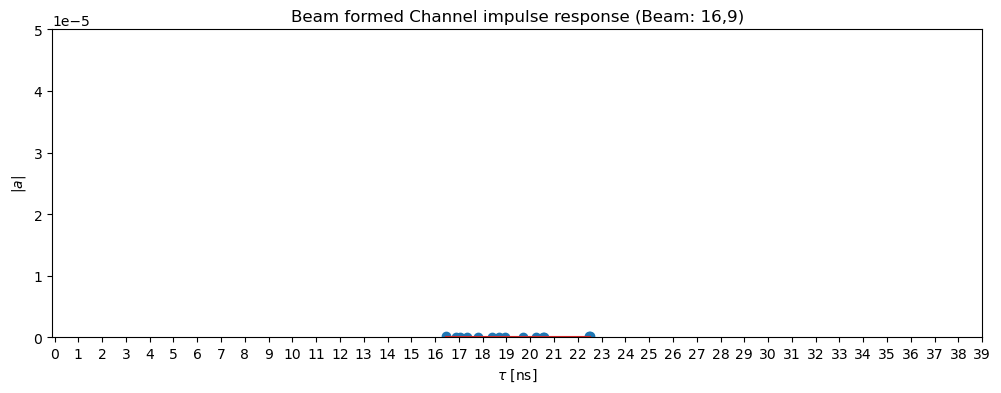

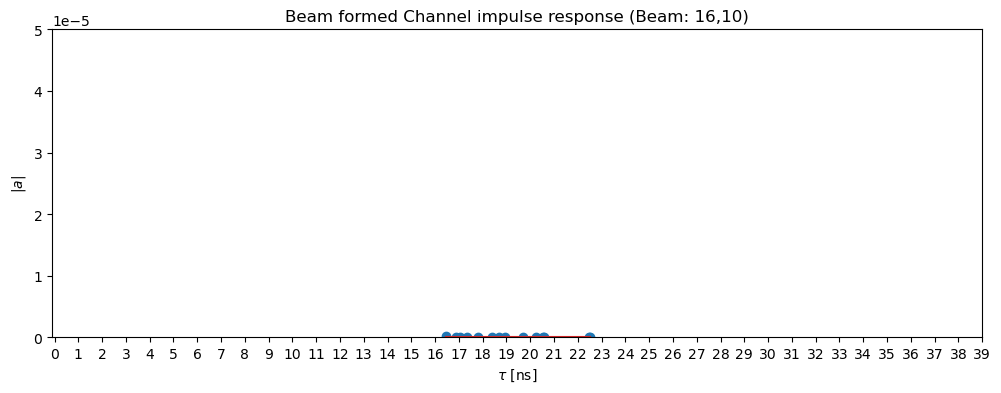

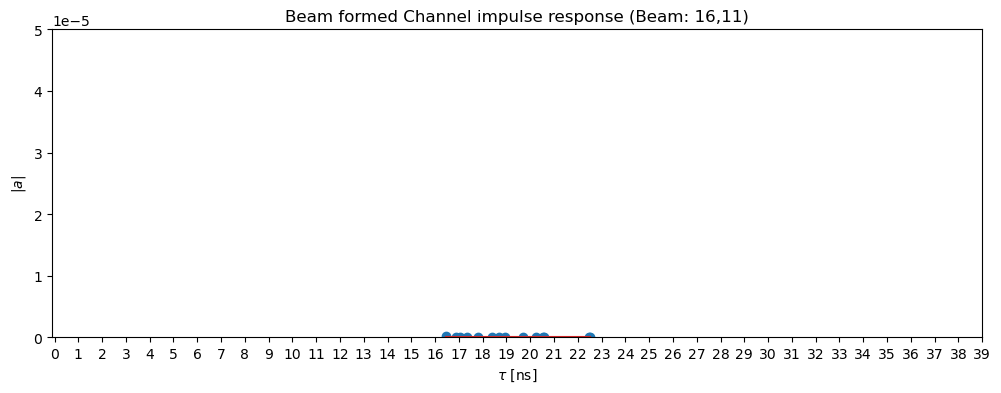

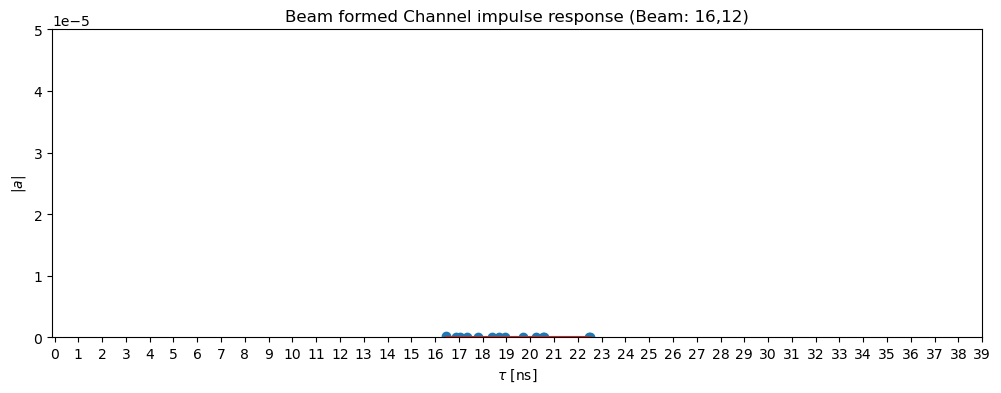

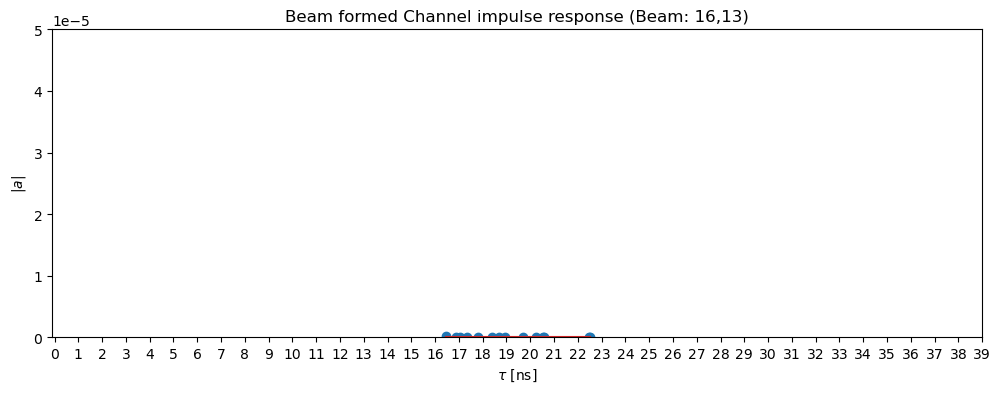

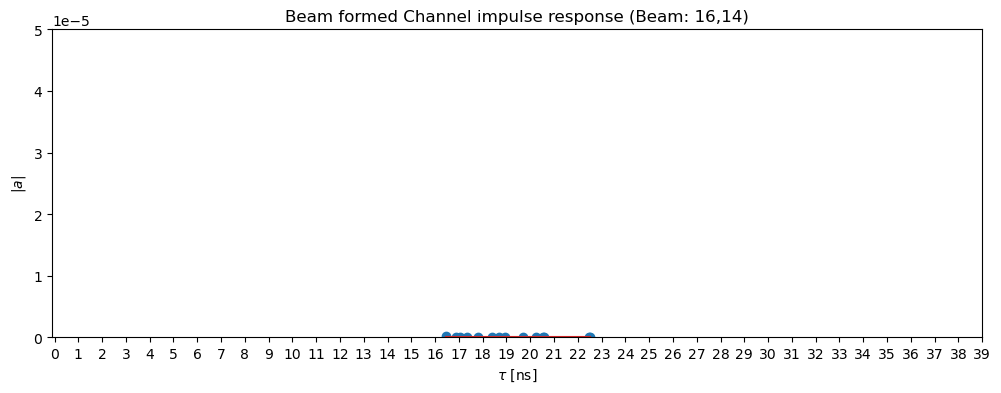

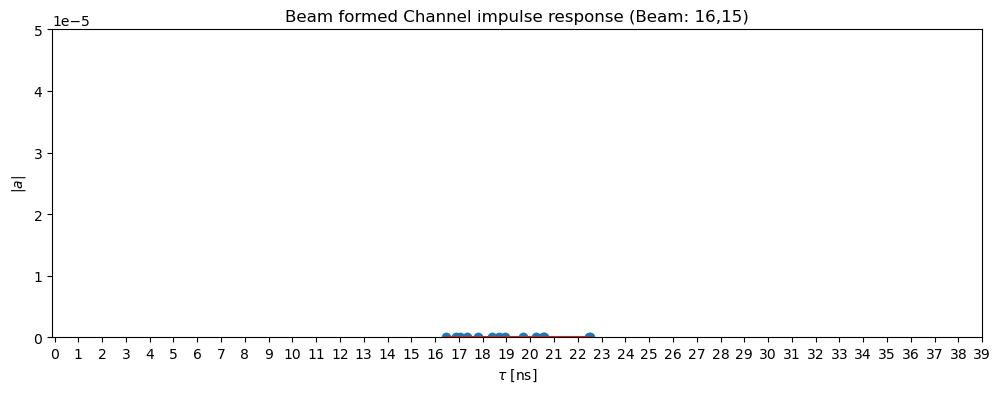

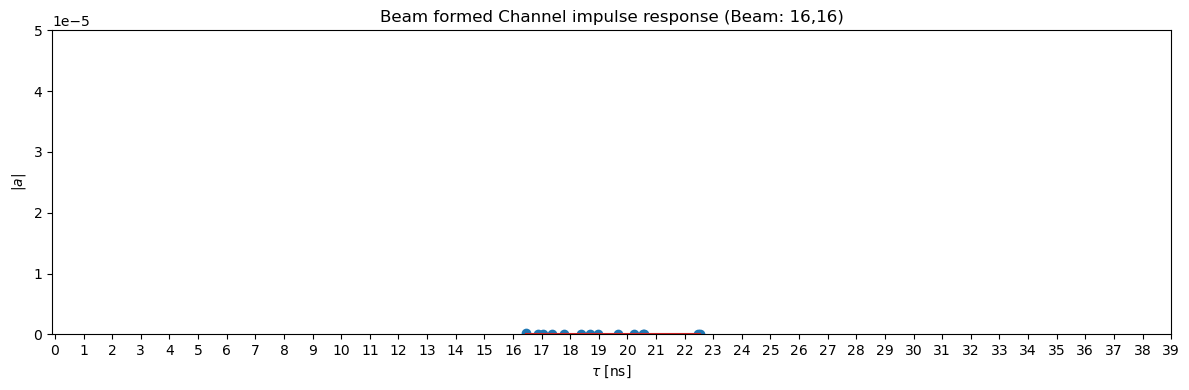

In [26]:
for column in channel_magnitude_df.columns:
    fig, ax = plt.subplots(1, 1, figsize=(12, 4))   
    ax.set_title(f"Beam formed Channel impulse response (Beam: {column})")
    ax.stem(channel_magnitude_df.index*1e9, channel_magnitude_df[column])
    ax.set_xlim([-0.1, 39])
    ax.set_ylim([-2e-12, 5e-5])
    ax.set_xlabel(r"$\tau$ [ns]")
    ax.set_ylabel(r"$|a|$")
    ax.set_xticks(np.arange(0, 40, 1))

# subplots do not overlap
plt.tight_layout()
plt.show()